# Modeling

### Marco Wong

### January 4th, 2023

## Recap

Up to this point, we have completed several crucial steps to prepare for modeling. 

In total, we started with 4 datasets:
- 2021 - 2022 player statistics 
- 2022 - 2023 player statsistics
- Player valuations
- Player name

All the datasets were fully cleaned. First, I cleaned the player valuation dataset and only kept rows in the relevant years. Then, I merged the player valuation and player name datasets using the player ID to have the correct player name with player valuation. Afterwards, I merged each respective player statistics with the valuation datasets.

Lastly, the player statistics datasets were merged vertically to give a final dataframe which contains each respective player with their player statistics and valuation.

We have also completed some basic exploratory data analysis and did a baseline model with linear regression. Our initial results had mean absolute error of 7.6 million Euros and a R^2 score of 0.375

## Model Evaluation

After developing our models, it is imperative to have a suitable method to evaluate them. By setting up an evaluation framework, we can ensure each model is fairly represented. 

Our framework will consist of looking at the R-squared, Mean Absolute Error and also the percentage mean absolute error. The R-squared score will tell us how the variance of valuation can be attributed to our features, whilst the mean absolute error will let us know how 'off' we are from the valuation, on average. Lastly, the percentage mean absolute error will give us useful information regardless of the scale of the data.

In [697]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')
from matplotlib.ticker import FormatStrFormatter

# For general use
import numpy as np
import pandas as pd

# For plotting purposes
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

# for modeling amnd statistical analysis
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

# For neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

# For decision tree and ensemble methods
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# For model intepretation
import shap

# For creating .pkl files for streamlit
import joblib

## Table of Contents

*This notebook is developed using JupyterLabs. Please use the table of contents below or the built-in TOC on the left bar for easy navigation.*

#### 1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
   - [1.1 Teams](#1.1-Teams)
   - [1.2 Nations](#1.2-Nations)
   - [1.3 Player Statistics](#1.3-Player-Statistics)
   - [1.4 One Hot Encoding Categorical Variables](#OHE)
   - [1.5 Target Variable](#1.5-Target-variable)

#### 2. [Baseline Modeling - Linear Regression](#BaselineModeling)
   - [2.1 Scaling](#2.1-Scaling-for-Linear-Regression)
   - [2.2 Evaluation](#2.2-Evaluation)
   - [2.3 Optimization](#2.3-Optimization)
   - [2.4 Using Lasso and Ridge Regularization](#2.4-Using-Regularization)

#### 3. [Decision Tree Regression](#DTC)

#### 4. [Random Forests](#RF)

#### 5. [Neural Networks](#NN)

#### 6. [Bagging](#Bagging)

#### 7. [Gradient Boosting](#GB)

#### 8. [Model Comparison](#MC)
   - [8.1 R Squared Values](#8.1-R-Squared-Values)
   - [8.2 MAE Values](#8.2-MAE-Values)
   - [8.3 PMAE Values](#8.3-PMAE-Values)
   - [8.4 Actual vs Predicted Values](#VALUES)
   
#### 9. [Optimizing the Best Model](#Optimizing)
   - [9.1 RFE](#9.1-RFE)
   - [9.2 Feature Importance](#9.2-Feature-Importance)
   - [9.3 Player Examples](#9.3Player-Examples)
   
#### 10. [Conclusion](#CONCLUSION)


### Import Data

First, we import our data from the end of the last notebook.

In [2]:
df = pd.read_csv("data/Final_DataFrame_Merged.csv")

In [3]:
# Quick checks on the dataframe
df.head()

,Name,Height,Valuation,Nation,Pos,Squad,Comp,Age,Born,MP,...,Fld,Off,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%,2023
0,Brenden Aaronson,177.0,25000000.0,USA,MFFW,Leeds United,Premier League,22.0,2000,20,...,2.26,0.17,0.0,0.0,0.00,4.86,0.34,1.19,22.2,1
1,Yunis Abdelhamid,190.0,700000.0,MAR,DF,Reims,Ligue 1,35.0,1987,22,...,0.50,0.05,0.0,0.0,0.00,6.64,2.18,1.23,64.0,1
2,Himad Abdelli,185.0,2500000.0,FRA,MFFW,Angers,Ligue 1,23.0,1999,14,...,1.28,0.00,0.0,0.0,0.00,8.14,0.93,1.05,47.1,1
3,Salis Abdul Samed,179.0,18000000.0,GHA,MF,Lens,Ligue 1,22.0,2000,20,...,1.35,0.00,0.0,0.0,0.05,6.60,0.50,0.50,50.0,1
4,Laurent Abergel,170.0,3000000.0,FRA,MF,Lorient,Ligue 1,30.0,1993,15,...,1.01,0.00,0.0,0.0,0.00,6.51,0.31,0.39,44.4,1


In [4]:
# Check rows and columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Columns: 117 entries, Name to 2023
dtypes: float64(107), int64(5), object(5)
memory usage: 4.8+ MB


# Exploratory Data Analysis

With our baseline model, we have only one hot encoded two of our categorical variables: positions and leagues. This is straightforward as there are so only 11 recorded positions and 5 leagues.

However, we have many more teams and nations, which we should further investigate.

## 1.1 Teams

First, we take a look at all the different teams. From background knowledge of European Football, my intuition is that teams that are placed lower generally have lower valued players. Let's take a look at this hypothesis.

In [5]:
# Check the number of unique teams
df['Squad'].nunique()

112

Over the two seasons, we have 112 unique squads. This makes sense since some teams in the 2021-2022 season may have been promoted/ relegated, and there are a few new teams in the 2022-2023 season.

Let's look into each league and group the teams into 3 buckets.

As there are two seasons put together, I will look at the **average** place for each team over the two seasons. Then I will make a list and put them into the buckets accordingly.

I will group them in three buckets, according to their average position:

- **1-8**: As class 1
- **9-17**: As class 2
- **17-23**: As class 3

For the Bundesliga, as there are only 18 teams, we will group by the following:
- **1-7**: As class 1
- **8-14**: As class 2
- **14-20**: As class 3

My next steps will be looking at each league and ranking the teams over the two seasons. 

**Note**: The following lines are looking at each league and the teams respective positions and then grouping it into their respective buckets. Scroll down to bypass this long section if needed.

#### Premier League
The standings for premier league 2021 - 2022.
1. Manchester City
2. Liverpool
3. Chelsea
4. Tottenham
5. Arsenal
6. Manchester United
7. West Ham United
8. Leicester City
9. Brighton
10. Wolves
11. Newcastle
12. Crystal Palace
13. Brentford
14. Aston Villa
15. Southampton
16. Everton
17. Leeds United
18. Burnley
19. Watford
20. Norwich City

For 2022 - 2023:
1. Manchester City
2. Arsenal
3. Man United
4. Newcastle
5. Liverpool
6. Brighton
7. Aston Villa
8. Tottenham
9. Brentford
10. Fulham
11. Crystal Palace
12. Chelsea
13. Wolves
14. West Ham
15. Bournemouth
16. Nottingham Forest
17. Everton
18. Leicester City
19. Leeds United
20. Southampton


Average standings as follows:
1. Manchester City: 1.0
2. Arsenal: 3.5
3. Liverpool: 3.5
4. Manchester United: 4.5
5. Tottenham: 6.0
6. Chelsea: 7.5
7. Brighton: 7.5
8. Newcastle United: 7.5
9. Aston Villa: 10.5
10. West Ham United: 10.5
11. Fulham: 10.0
12. Wolverhampton Wanderers: 11.5
13. Crystal Palace: 11.5
14. Brentford: 13.0
15. Leicester City: 13.0
16. Bournemouth: 15.0
17. Nottingham Forest: 16.0
18. Everton: 16.5
19. Southampton: 17.5
20. Leeds United: 18.0
21. Burnley: 18.0
22. Watford: 19.0
23. Norwich City: 20.0

#### Ligue 1
2021-2022 Standings:

1. PSG
2. Marseille
3. Monaco
4. Rennes
5. Nice
6. Strasbourg
7. Lens
8. Lyon
9. Nantes
10. LOSC
11. Brest
12. Reims
13. Montpellier
14. Angers
15. Troyes
16. Lorient
17. Clermont Foot
18. St-Etienne
19. Metz
20. Bordeaux

2022-2023 Standings:
1. PSG
2. Lens
3. Marseille
4. Rennes
5. LOSC
6. Monaco
7. Lyon
8. Clermont Foot
9. Nice
10. Lorient
11. Reims
12. Montpellier
13. Toulouse
14. Brest
15. Strasbourg
16. Nantes
17. Auxerre
18. Ajaccio
19. Troyes
20. Angers


Average standing in Ligue 1 as follows:

1. PSG: 1.0
2. Marseille: 2.5
3. Monaco: 4.5
4. Rennes: 4.0
5. Lens: 4.5
6. Nice: 7.0
7. Lyon: 7.5
8. LOSC: 7.5
9. Strasbourg: 10.5
10. Reims: 11.5
11. Montpellier: 12.5
12. Brest: 12.5
13. Nantes: 12.5
14. Lorient: 13.0
15. Toulouse: 13.0
16. Clermont Foot: 12.5
17. Auxerre: 17.0
18. St-Etienne: 18.0
19. Ajaccio: 18.0
20. Metz: 19.0
21. Troyes: 17.0
22. Bordeaux: 20.0
23. Angers: 20.0


#### Bundesliga 

2021-2022 season

1. Bayern Munich
2. Dortmund
3. Leverkusen
4. RB Leipzig
5. Union Berlin
6. SC Freiburg
7. Koln
8. Mainz
9. Hoffenheim
10. Monchengladbach
11. Eintracht Frankfurt
12. Wolfsburg
13. Vfl Bochum
14. Augsburg
15. Vfb Stuttgart
16. Hertha
17. Arminia
18. Furth

2022-2023 season

1. Bayern Munich
2. Dortmund
3. RB Leipzig
4. Union Berlin
5. SC Freiburg
6. Leverkusen
7. Eintracht Frankfurt
8. Wolfsburg
9. Mainz
10. Monchengladbach
11. Koln
12. Hoffenheim
13. Werder
14. Vfl Bochum
15. Augsburg
16. VfB Stuttgart
17. Schalke
18. Hertha

Average standings in Bundesliga:

1. Bayern Munich: 1.0
2. Dortmund: 2.0
3. RB Leipzig: 3.5
4. Leverkusen: 4.5
5. Union Berlin: 4.5
6. SC Freiburg: 5.5
7. Koln: 9.0
8. Eintracht Frankfurt: 9.0
9. Mainz: 8.5
10. Monchengladbach: 10.0
11. Wolfsburg: 10.0
12. Hoffenheim: 10.5
13. Vfl Bochum: 13.5
14. Werder: 13.0
15. Augsburg: 14.5
16. Vfb Stuttgart: 15.5
17. Hertha: 17.0
18. Arminia: 17.0
19. Schalke: 17.0
20. Furth: 18.0


#### Serie A standings

2021-2022 standings

1. Milan
2. Inter
3. Napoli
4. Juventus
5. Lazio
6. Roma
7. Fiorentia
8. Atalanta
9. Verona
10. Torino
11. Sassuolo
12. Udinese
13. Bologna
14. Empoli
15. Sampdoria
16. Spezia
17. Salernitana
18. Cagliari
19. Genoa
20. Venezia

2022-2023 standings

1. Napoli
2. Lazio
3. Inter
4. Milan
5. Atalanta
6. Roma
7. Juventus
8. Fiorentina
9. Bologna
10. Torino
11. Monza
12. Udinese
13. Sassuolo
14. Empoli
15. Salernitana
16. Lecce
17. Verona
18. Spezia
19. Cremonese
20. Sampdoria


Average standings in Serie A as follows:

1. Napoli: 2.0
2. Milan: 2.5
3. Inter: 2.5
4. Lazio: 3.5
5. Juventus: 5.5
6. Atalanta: 6.5
7. Roma: 6.0
8. Fiorentina: 7.5
9. Torino: 10.0
10. Bologna: 11.0
11. Udinese: 12.0
12. Sassuolo: 12.0
13. Verona: 13.0
14. Empoli: 14.0
15. Salernitana: 16.0
16. Lecce: 16.0
17. Spezia: 17.0
18. Sampdoria: 17.5
19. Genoa: 19.0
20. Cagliari: 18.0
21. Venezia: 20.0
22. Monza: 11.0
23. Cremonese: 19.0


#### La liga standings

2021-2022 season

1. Real Madrid 
2. Barcelona
3. Atletico Madrid
4. Sevilla
5. Real Betis
6. Real Sociedad
7. Villareal
8. Athletic Club
9. Valencia
10. Osasuna
11. Celta Vigo
12. Rayo Vallecano
13. Elche
14. Espanyol
15. Getafe
16. Mallorca
17. Cadiz
18. Granada
19. Levante
20. Alaves

2022-2023 season

1. Barcelona
2. Real Madrid
3. Atletico Madrid
4. Real Sociedad
5. Villareal
6. Real Betis
7. Osasuna
8. Athletic Club
9. Mallorca
10. Girona
11. Rayo Vallecano
12. Sevilla
13. Celta Vigo
14. Cadiz
15. Getafe
16. Valencia
17. Almeria
18. Valladolid
19. Espanyol
20. Elche

Average standing in La Liga as follows:
1. Barcelona: 1.5
2. Real Madrid: 1.5
3. Atletico Madrid: 3.0
4. Real Sociedad: 5.0
5. Villarreal: 6.0
6. Real Betis: 5.5
7. Osasuna: 8.5
8. Athletic Club: 8.0
9. Mallorca: 12.5
10. Girona: 10.0
11. Rayo Vallecano: 11.5
12. Sevilla: 8.0
13. Celta Vigo: 12.0
14. Cadiz: 15.5
15. Getafe: 15.0
16. Valencia: 12.5
17. Almeria: 17.0
18. Valladolid: 18.0
19. Espanyol: 16.5
20. Elche: 16.5
21. Granada: 18.0
22. Levante: 19.0
23. Alaves: 20.0


Now that we have our rankings, we can group them and compare their valuations. If there is a significant difference between the groups, I will group them accordingly. 

First, I need to check the names of the teams in our dataset. I will check it by each league.

In [6]:
# Checking the team names in our dataset
df[df['Comp'] == 'Premier League']['Squad'].unique()

array(['Leeds United', 'Southampton', 'Fulham', 'West Ham',
       'Crystal Palace', 'Brentford', 'Manchester City', 'Leicester City',
       'Liverpool', 'Everton', 'Newcastle Utd', 'Bournemouth',
       'Manchester Utd', 'Aston Villa', 'Chelsea', "Nott'ham Forest",
       'Tottenham', 'Wolves', 'Brighton', 'Arsenal', 'Norwich City',
       'Watford', 'Burnley'], dtype=object)

In [7]:
# Top 8 teams premier league
top_teams = [
    "Manchester City",
    "Arsenal",
    "Liverpool",
    "Manchester Utd",
    "Tottenham",
    "Chelsea",
    "Brighton",
    "Newcastle Utd"
]

# Mid-table teams (9-16)
mid_table = [
    "Aston Villa",
    "West Ham",
    "Fulham",
    "Wolves",
    "Crystal Palace",
    "Brentford",
    "Leicester City",
    "Bournemouth"
]

# Bottom half teams (17-23)
bottom_half = [
    "Nott'ham Forest",
    "Everton",
    "Southampton",
    "Leeds United",
    "Burnley",
    "Watford",
    "Norwich City"
]

In [8]:
# Checking team names in Ligue 1
df[df['Comp'] == 'Ligue 1']['Squad'].unique()

array(['Reims', 'Angers', 'Lens', 'Lorient', 'Auxerre', 'Rennes',
       'Toulouse', 'Nantes', 'Troyes', 'Monaco', 'Strasbourg',
       'Clermont Foot', 'Ajaccio', 'Lille', 'Lyon', 'Brest', 'Nice',
       'Marseille', 'Paris S-G', 'Montpellier', 'Saint-Étienne',
       'Bordeaux', 'Metz'], dtype=object)

In [9]:
top_teams = [
    'Paris S-G',
    'Marseille',
    'Monaco',
    'Rennes',
    'Lens',
    'Nice',
    'Lyon',
    'Lille'
]

# Mid-table teams (9-16)
mid_table = [
    'Strasbourg',
    'Reims',
    'Montpellier',
    'Brest',
    'Nantes',
    'Lorient',
    'Toulouse',
    'Clermont Foot'
]

# Bottom half teams (17-23)
bottom_teams = [
    'Auxerre',
    'Saint-Étienne',
    'Ajaccio',
    'Metz',
    'Troyes',
    'Bordeaux',
    'Angers'
]

In [10]:
# Checking team names in Bundesliga
df[df['Comp'] == 'Bundesliga']['Squad'].unique()

array(['Köln', 'Dortmund', 'Leverkusen', 'Werder Bremen', 'Stuttgart',
       'Mainz 05', 'Hoffenheim', 'Eint Frankfurt', 'Bochum', 'Wolfsburg',
       'RB Leipzig', 'Augsburg', 'Union Berlin', "M'Gladbach",
       'Bayern Munich', 'Hertha BSC', 'Schalke 04', 'Freiburg',
       'Greuther Fürth', 'Arminia'], dtype=object)

In [11]:
# Top teams (1-7)
top_teams = [
    'Bayern Munich',
    'Dortmund',
    'RB Leipzig',
    'Leverkusen',
    'Union Berlin',
    'SC Freiburg',
    'Köln'
]

# Mid-table teams (8-14)
mid_table = [
    'Eint Frankfurt',
    'Mainz',
    "M'Gladbach",
    'Wolfsburg',
    'Hoffenheim',
    'Vfl Bochum',
    'Werder'
]

# Bottom half teams (15-20)
bottom_teams = [
    'Augsburg',
    'Stuttgart',
    'Hertha BSC',
    'Arminia',
    'Schalke',
    'Greuther Fürth'
]


In [12]:
# Checking team names in Serie A
df[df['Comp'] == 'Serie A']['Squad'].unique()

array(['Hellas Verona', 'Roma', 'Inter', 'Milan', 'Bologna', 'Cremonese',
       'Spezia', 'Torino', 'Lazio', 'Sampdoria', 'Fiorentina', 'Sassuolo',
       'Monza', 'Udinese', 'Lecce', 'Empoli', 'Atalanta', 'Salernitana',
       'Juventus', 'Napoli', 'Cagliari', 'Genoa', 'Venezia'], dtype=object)

In [13]:
# Top teams (1-8)
top_teams = [
    'Napoli',
    'Milan',
    'Inter',
    'Lazio',
    'Juventus',
    'Atalanta',
    'Roma',
    'Fiorentina'
]

# Mid-table teams (9-16)
mid_table = [
    'Torino',
    'Bologna',
    'Udinese',
    'Sassuolo',
    'Hellas Verona',
    'Empoli',
    'Salernitana',
    'Lecce'
]

# Bottom half teams (17-23)
bottom_teams = [
    'Spezia',
    'Sampdoria',
    'Cagliari',
    'Genoa',
    'Venezia',
    'Monza',
    'Cremonese'
]


In [14]:
# Checking team names in La liga
df[df['Comp'] == 'La Liga']['Squad'].unique()

array(['Betis', 'Sevilla', 'Valladolid', 'Celta Vigo', 'Almería',
       'Real Madrid', 'Cádiz', 'Barcelona', 'Villarreal', 'Getafe',
       'Athletic Club', 'Mallorca', 'Elche', 'Rayo Vallecano', 'Espanyol',
       'Osasuna', 'Real Sociedad', 'Atlético Madrid', 'Girona',
       'Valencia', 'Granada', 'Levante', 'Alavés'], dtype=object)

In [15]:
# Top teams (1-8)
top_teams = [
    'Barcelona',
    'Real Madrid',
    'Atlético Madrid',
    'Real Sociedad',
    'Betis',
    'Villarreal',
    'Athletic Club',
    'Osasuna'
]

# Mid-table teams (9-16)
mid_table = [
    'Sevilla',
    'Girona',
    'Valencia',
    'Mallorca',
    'Rayo Vallecano',
    'Celta Vigo',
    'Getafe',
    'Espanyol'
]

# Bottom half teams (17-23)
bottom_teams = [
    'Elche',
    'Granada',
    'Valladolid',
    'Alaves',
    'Almeria',
    'Levante',
    'Cadiz'
]


Putting everything together to create 3 buckets. We will then add another column which will put these in different classes.

In [16]:
# Top 8 teams premier league
top_teams = [
    "Manchester City",
    "Arsenal",
    "Liverpool",
    "Manchester Utd",
    "Tottenham",
    "Chelsea",
    "Brighton",
    "Newcastle Utd",
    'Paris S-G',
    'Marseille',
    'Monaco',
    'Rennes',
    'Lens',
    'Nice',
    'Lyon',
    'Lille',
    'Bayern Munich',
    'Dortmund',
    'RB Leipzig',
    'Leverkusen',
    'Union Berlin',
    'SC Freiburg',
    'Köln',
    'Napoli',
    'Milan',
    'Inter',
    'Lazio',
    'Juventus',
    'Atalanta',
    'Roma',
    'Fiorentina',
    'Barcelona',
    'Real Madrid',
    'Atlético Madrid',
    'Real Sociedad',
    'Betis',
    'Villarreal',
    'Athletic Club',
    'Osasuna'
]

# Mid-table teams (9-16)
mid_table = [
    "Aston Villa",
    "West Ham",
    "Fulham",
    "Wolves",
    "Crystal Palace",
    "Brentford",
    "Leicester City",
    "Bournemouth",
    'Strasbourg',
    'Reims',
    'Montpellier',
    'Brest',
    'Nantes',
    'Lorient',
    'Toulouse',
    'Clermont Foot',
    'Eint Frankfurt',
    'Mainz',
    "M'Gladbach",
    'Wolfsburg',
    'Hoffenheim',
    'Vfl Bochum',
    'Werder',
    'Torino',
    'Bologna',
    'Udinese',
    'Sassuolo',
    'Hellas Verona',
    'Empoli',
    'Salernitana',
    'Lecce',
    'Sevilla',
    'Girona',
    'Valencia',
    'Mallorca',
    'Rayo Vallecano',
    'Celta Vigo',
    'Getafe',
    'Espanyol'
]

# Bottom half teams (17-23)
bottom_half = [
    "Nott'ham Forest",
    "Everton",
    "Southampton",
    "Leeds United",
    "Burnley",
    "Watford",
    "Norwich City",
    'Auxerre',
    'Saint-Étienne',
    'Ajaccio',
    'Metz',
    'Troyes',
    'Bordeaux',
    'Angers',
    'Augsburg',
    'Stuttgart',
    'Hertha BSC',
    'Arminia',
    'Schalke',
    'Greuther Fürth',
    'Spezia',
    'Sampdoria',
    'Cagliari',
    'Genoa',
    'Venezia',
    'Monza',
    'Cremonese',
    'Elche',
    'Granada',
    'Valladolid',
    'Alaves',
    'Almeria',
    'Levante',
    'Cadiz'

]

combined_names = top_teams + mid_table + bottom_half

In [17]:
# Setting the team names as a variable
team_names = df['Squad'].unique()

In [18]:
# Checking to see if names are correct; names in Dataset that are NOT in our created list
set(team_names) - set(combined_names)

{'Alavés',
 'Almería',
 'Bochum',
 'Cádiz',
 'Freiburg',
 'Mainz 05',
 'Schalke 04',
 'Werder Bremen'}

In [19]:
# Checking vice versa; checking our created list and see which names do not appear in the dataset
set(combined_names) - set(team_names)

{'Alaves',
 'Almeria',
 'Cadiz',
 'Mainz',
 'SC Freiburg',
 'Schalke',
 'Vfl Bochum',
 'Werder'}

In [20]:
# Remaking list to contain correct names
# Top teams
top_teams = [
    "Manchester City",
    "Arsenal",
    "Liverpool",
    "Manchester Utd",
    "Tottenham",
    "Chelsea",
    "Brighton",
    "Newcastle Utd",
    'Paris S-G',
    'Marseille',
    'Monaco',
    'Rennes',
    'Lens',
    'Nice',
    'Lyon',
    'Lille',
    'Bayern Munich',
    'Dortmund',
    'RB Leipzig',
    'Leverkusen',
    'Union Berlin',
    'Freiburg',
    'Köln',
    'Napoli',
    'Milan',
    'Inter',
    'Lazio',
    'Juventus',
    'Atalanta',
    'Roma',
    'Fiorentina',
    'Barcelona',
    'Real Madrid',
    'Atlético Madrid',
    'Real Sociedad',
    'Betis',
    'Villarreal',
    'Athletic Club',
    'Osasuna'
]

# Mid-table teams
mid_table = [
    "Aston Villa",
    "West Ham",
    "Fulham",
    "Wolves",
    "Crystal Palace",
    "Brentford",
    "Leicester City",
    "Bournemouth",
    'Strasbourg',
    'Reims',
    'Montpellier',
    'Brest',
    'Nantes',
    'Lorient',
    'Toulouse',
    'Clermont Foot',
    'Eint Frankfurt',
    'Mainz 05',
    "M'Gladbach",
    'Wolfsburg',
    'Hoffenheim',
    'Bochum',
    'Werder Bremen',
    'Torino',
    'Bologna',
    'Udinese',
    'Sassuolo',
    'Hellas Verona',
    'Empoli',
    'Salernitana',
    'Lecce',
    'Sevilla',
    'Girona',
    'Valencia',
    'Mallorca',
    'Rayo Vallecano',
    'Celta Vigo',
    'Getafe',
    'Espanyol'
]

# Bottom half teams
bottom_teams = [
    "Nott'ham Forest",
    "Everton",
    "Southampton",
    "Leeds United",
    "Burnley",
    "Watford",
    "Norwich City",
    'Auxerre',
    'Saint-Étienne',
    'Ajaccio',
    'Metz',
    'Troyes',
    'Bordeaux',
    'Angers',
    'Augsburg',
    'Stuttgart',
    'Hertha BSC',
    'Arminia',
    'Schalke 04',
    'Greuther Fürth',
    'Spezia',
    'Sampdoria',
    'Cagliari',
    'Genoa',
    'Venezia',
    'Monza',
    'Cremonese',
    'Elche',
    'Granada',
    'Valladolid',
    'Alavés',
    'Almería',
    'Levante',
    'Cádiz'

]

combined_names = top_teams + mid_table + bottom_teams

In [21]:
# Checking to see if names are correct; names in Dataset that are NOT in our created list
set(team_names) - set(combined_names)

set()

In [22]:
# Checking vice versa; checking our created list and see which names do not appear in the dataset
set(combined_names) - set(team_names)

set()

Names should be properly initiated. Let's add a new column for each player.

- **Top**: For players in top teams
- **Middle**: For players in mid teams
- **Bottom**: For players in bottom teams

In [458]:
# Copy the dataframe
df1 = df.copy()

In [459]:
# Create a new column
# We do a np.where statement even for the bottom teams to ensure that all teams are properly put in the right group.
df1['Team'] = np.where(df1['Squad'].isin(top_teams), 'Top',
                      np.where(df1['Squad'].isin(mid_table), 'Middle',
                               np.where(df1['Squad'].isin(bottom_teams), 'Bottom', 0)))

In [460]:
# Check no teams in group 0
df1['Team'].unique()

array(['Bottom', 'Middle', 'Top'], dtype=object)

Now that we have succesfully added the required column, let's see how the valuation varies between the different groups. First, we can make a plot for a visual reference.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


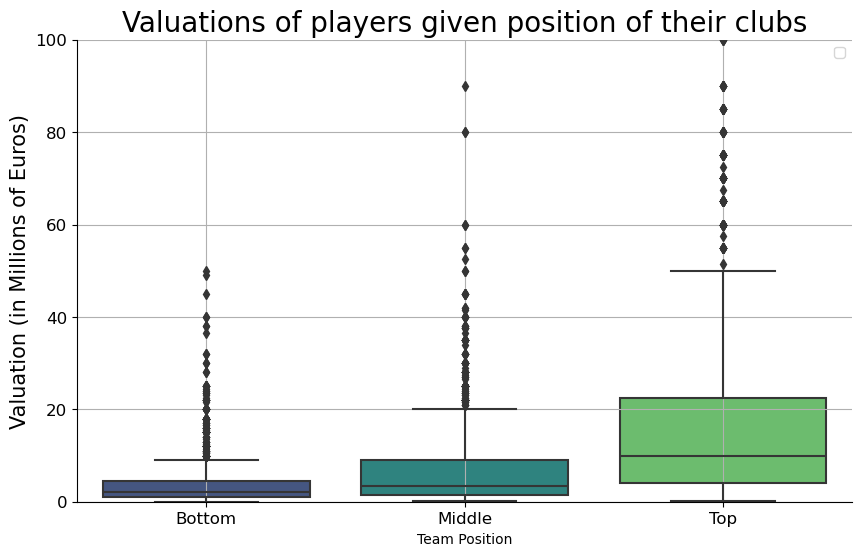

In [611]:
# Group the valuation data by 'Team'
grouped_valuations = df1.groupby('Team')['Valuation']

# Create a boxplot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Team', y='Valuation', data=df1, palette='viridis')

# Function to format y-axis ticks to represent in 100,000s (hundreds of thousands)
formatter = FuncFormatter(lambda x, _: f'{x / 1000000:.0f}')  # Divide x by 100,000 to represent in 100,000s

# Apply formatter to y-axis
plt.gca().yaxis.set_major_formatter(formatter)
# Add labels, titles, legend, and grid
plt.ylim(0,100_000_000)
plt.xlabel('Team Position', fontsize = 10)
plt.ylabel('Valuation (in Millions of Euros)', fontsize = 15)
plt.title('Valuations of players given position of their clubs', fontsize = 20)
plt.legend()
plt.grid(True)
sns.despine()

# Adjust tick label font size for both axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()


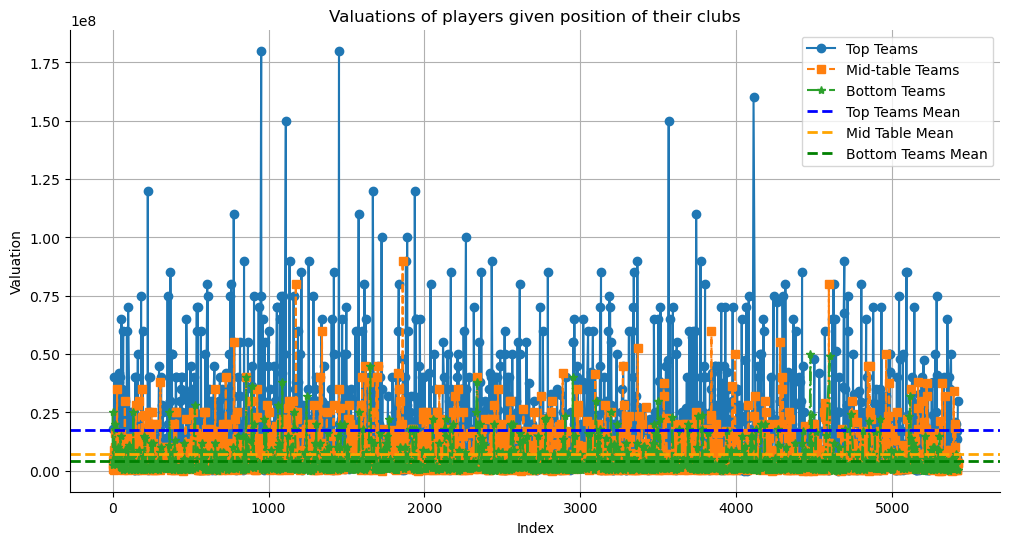

In [696]:
# Set the valuation data for each group
top_teams_valuation = df1[df1['Team'] == 'Top']['Valuation']
mid_table_valuation = df1[df1['Team'] == 'Middle']['Valuation']
bottom_teams_valuation = df1[df1['Team'] == 'Bottom']['Valuation']

# Create a plot with each mean
plt.figure(figsize = (12,6))

# Plot respective valuations
plt.plot(top_teams_valuation, label='Top Teams', marker='o', linestyle='-')
plt.plot(mid_table_valuation, label='Mid-table Teams', marker='s', linestyle='--')
plt.plot(bottom_teams_valuation, label='Bottom Teams', marker='*', linestyle='-.')


# Add mean values for each group
plt.axhline(top_teams_valuation.mean(), label = 'Top Teams Mean', linestyle = '--', color = 'Blue', linewidth = 2)
plt.axhline(mid_table_valuation.mean(), label = 'Mid Table Mean', linestyle = '--', color = 'Orange', linewidth = 2)
plt.axhline(bottom_teams_valuation.mean(), label = 'Bottom Teams Mean', linestyle = '--', color = 'Green', linewidth = 2)


# Add labels, titles, legend and grid
plt.xlabel('Index')
plt.ylabel('Valuation')
plt.title('Valuations of players given position of their clubs')
plt.legend()
plt.grid(True)
sns.despine()


# Show plot
plt.show()

In [27]:
print("Top Teams Mean valuation: €", round(top_teams_valuation.mean()))
print("Mid Table Teams Mean valuation: €", round(mid_table_valuation.mean()))
print("Bottom Teams Mean valuation: €", round(bottom_teams_valuation.mean()))

Top Teams Mean valuation: € 17506256
Mid Table Teams Mean valuation: € 7074189
Bottom Teams Mean valuation: € 4240863


**Insight**

Clearly, there is a difference in valuation between the different groups. 

- With the means of the valuation vastly different, with the top teams having over 3 times valuation of the bottom teams.
- It is also very interesting to see that there are very few players in the bottom teams that have a valuation over 25 million, whereas there are a lot for players in the top teams.

To ensure that there is a significant difference between these different groups, we can do an ANOVA test.

#### Anova Testing

We can perform ANOVA testing to see if there is a significant difference betweent the different categories.

In [28]:
# Perform ANOVA test
f_statistic, p_value = f_oneway(top_teams_valuation, mid_table_valuation, bottom_teams_valuation)

# Print results
print("F-statistic:", f_statistic)
print("P-value:", p_value)

F-statistic: 447.91148891718063
P-value: 9.447587186999546e-181


As we can see that there is a significant difference in valuation between the different groups due to the very low P-value. Lastly, we can do a tukey test to check the if there is significant difference between each of the groups.

In [29]:
# Collect all valuations into a list and create a corresponding list of labels
all_valuations = [top_teams_valuation, mid_table_valuation, bottom_teams_valuation]
labels = ['Top Teams', 'Mid-table Teams', 'Bottom Teams']

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(np.concatenate(all_valuations), np.concatenate([np.repeat(label, len(vals)) for label, vals in zip(labels, all_valuations)]))

# Show the results
print(tukey_results.summary())

                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
     group1          group2        meandiff   p-adj     lower         upper     reject
--------------------------------------------------------------------------------------
   Bottom Teams Mid-table Teams  2833325.6711   0.0  1666616.5424  4000034.7998   True
   Bottom Teams       Top Teams 13265392.6715   0.0 12116045.6061 14414739.7369   True
Mid-table Teams       Top Teams 10432067.0004   0.0  9385409.4316 11478724.5693   True
--------------------------------------------------------------------------------------


There is a significant difference between each of these groups. Thus, I will continue using these categories.

## 1.2 Nations

Similarly, we can look at the nationality of the different players.

There is a belief that there is a 'tax' for players from certain countries. Most famously is the 'English Tax', which is the belief that English players cost most more due to their nationality. We can test this theory and find a method to group players from different nations. Ideally, we could group the nationalities in a meaningful way - such as by continent, or by some common characteristic. This will make the feature more relatable.

First, we look at the total number of nations in our dataset.

In [30]:
df1['Nation'].nunique()

108

We have 108 unique nations. We will need to find a way to group these nations by valuation.

In [31]:
df1['Nation'].unique()

array(['USA', 'MAR', 'FRA', 'GHA', 'DEN', 'BRA', 'ENG', 'ITA', 'ARG',
       'SCO', 'ARM', 'GER', 'SUI', 'CIV', 'ESP', 'COL', 'NGA', 'NOR',
       'NED', 'AUT', 'CHI', 'PAR', 'GAB', 'GLP', 'URU', 'WAL', 'SRB',
       'JAM', 'BUL', 'JPN', 'KVX', 'ALB', 'TOG', 'ALG', 'SWE', 'TUR',
       'IRN', 'BEL', 'COD', 'CMR', 'SEN', 'ZAM', 'GRN', 'CZE', 'GAM',
       'CRO', 'BFA', 'IRL', 'CPV', 'SUR', 'POL', 'BIH', 'ANG', 'GNB',
       'SVN', 'MLI', 'LUX', 'MAD', 'TUN', 'POR', 'NZL', 'ECU', 'PER',
       'GUI', 'ROU', 'MKD', 'CAN', 'MTQ', 'BEN', 'SVK', 'HON', 'EGY',
       'NIR', 'AUS', 'CRC', 'LTU', 'RUS', 'MEX', 'HUN', 'EQG', 'VEN',
       'PHI', 'FIN', 'HAI', 'ISL', 'MNE', 'ZIM', 'SLE', 'GRE', 'CYP',
       'CTA', 'UKR', 'LVA', 'GEO', 'COM', 'CGO', 'MOZ', 'RSA', 'BDI',
       'GUF', 'UZB', 'ISR', 'KOR', 'REU', 'DOM', 'CHA', 'PAN', 'CHN'],
      dtype=object)

In [32]:
# Looking at the counts per nation, filtering for the top 20
df1.groupby(df1['Nation'])['Nation'].count().sort_values(ascending = False).head(20)

Nation
ESP    763
FRA    742
GER    474
ITA    458
ENG    382
BRA    198
NED    146
ARG    140
POR    126
BEL     88
DEN     84
SEN     80
CRO     77
POL     70
AUT     69
SRB     69
CIV     65
SUI     64
MAR     55
URU     55
Name: Nation, dtype: int64

In [33]:
# Looking at the counts per nation, filtering for the bottom 20
df1.groupby(df1['Nation'])['Nation'].count().sort_values(ascending = False).tail(20)

Nation
GUF    3
UZB    3
SUR    3
HON    3
CTA    3
RSA    3
GRN    2
COM    2
PHI    2
SLE    2
CYP    2
DOM    2
HAI    1
CHA    1
BDI    1
REU    1
PAN    1
LTU    1
LVA    1
CHN    1
Name: Nation, dtype: int64

Unsuprisingly, the nationality of players are of those in the top 5 leagues have the highest counts. There are a lot of nations with very few counts. Let's make a visualization for players in the top 10 nations. 

**Note:** 55 players is roughly 1% of the total count of players.

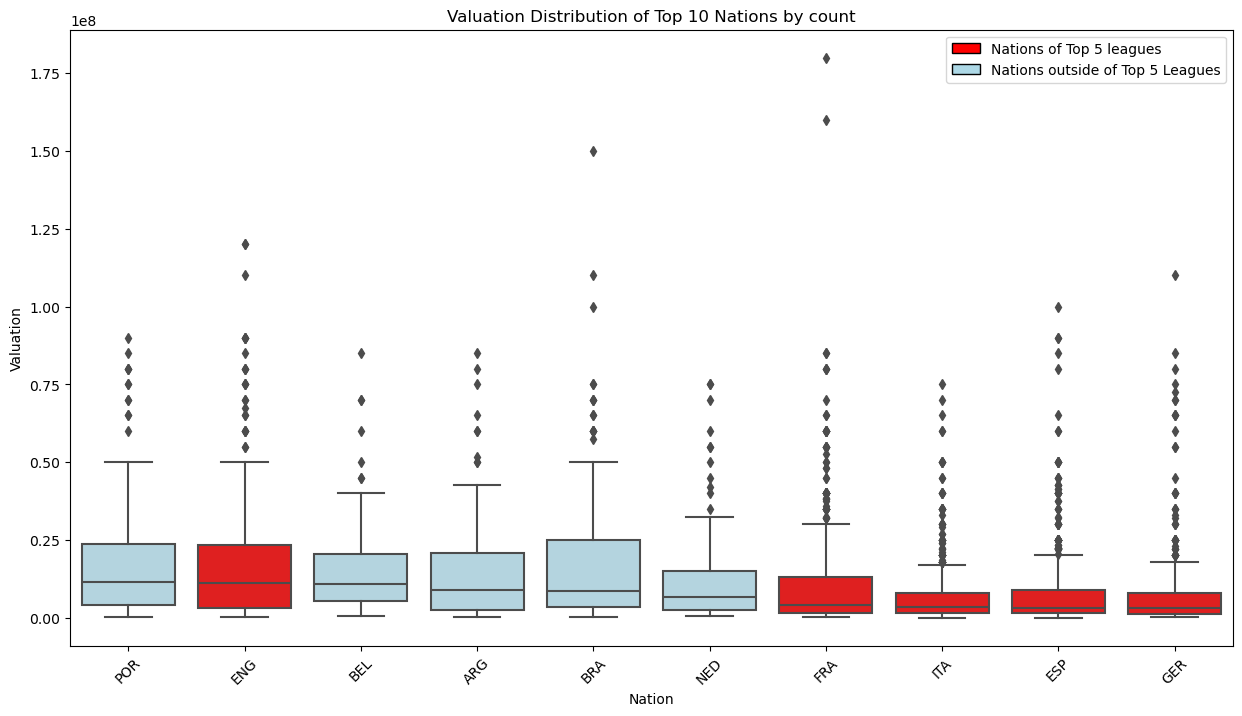

In [34]:
# Set a variable for top 10 nations by count
nation_index = df1.groupby(df1['Nation'])['Nation'].count().sort_values(ascending = False).head(10).index

# Sort nations by median value
median_valuations = df1[df1['Nation'].isin(nation_index)].groupby('Nation')['Valuation'].median().sort_values(ascending=False)
sorted_nations = median_valuations.index.tolist()

# Assign colors based on condition
colors = ['red' if nation in ['ESP', 'ENG', 'ITA', 'GER', 'FRA'] else 'lightblue' for nation in sorted_nations]

# Plot figure
plt.figure(figsize=(15, 8))
sns.boxplot(data=df1[df1['Nation'].isin(nation_index)], x='Nation', y='Valuation', order=sorted_nations, palette = colors)
plt.xticks(rotation=45)
plt.xlabel('Nation')
plt.ylabel('Valuation')
plt.title('Valuation Distribution of Top 10 Nations by count')


# Create custom legends for the plot
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Nations of Top 5 leagues'),
    Patch(facecolor='lightblue', edgecolor='black', label='Nations outside of Top 5 Leagues')
]
plt.legend(handles=legend_elements)

plt.show()

**Insight**

As we can see from above, there seems to be quite a large difference between the distributions of different nations. 
- Portuguese players have the highest median, with English players as a close second. The upper whisker (which is 1.5 times the interquartile range) is roughly 50 million for both of the countries. 
- English players do have more anomalies counts compared to Portuguese players. However, there are also roughly 3 times more English players in this dataset.
- Players from France, Italy, Spain and Germany, which host the other top 5 leagues, have significantly lower medians and have lower valuations in general. They do have a similar amount of 'high value' players that are outside of the whiskers of the boxplot.

Let's do an ANOVA test to see if there are significant difference between the nations.

In [35]:
from scipy.stats import f_oneway

# Extract valuation data for each nation in your selected top 10 nations
nation_valuations = [df1[df1['Nation'] == nation]['Valuation'] for nation in nation_index]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*nation_valuations)

print("F-statistic:", f_statistic)
print("P-value:", p_value)



F-statistic: 27.270930340563684
P-value: 4.396965428619214e-46


Due to the low p value, we can reject the null hypothesis and conclude that different nations affect the valuations. To look deeper, we can do a Tukey HSD test to compare each pair to see if there is a significant difference between each of the nations.

In [36]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(np.concatenate(nation_valuations), np.concatenate([np.repeat(nation, len(df1[df1['Nation'] == nation])) for nation in nation_index]))
print(tukey_results)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
group1 group2    meandiff    p-adj      lower          upper     reject
-----------------------------------------------------------------------
   ARG    BEL   2084772.7273 0.9933  -4633938.0746  8803483.5291  False
   ARG    BRA   4070252.5253 0.3489  -1383376.7893  9523881.8398  False
   ARG    ENG   3329685.8639 0.4847  -1549680.5273  8209052.2551  False
   ARG    ESP  -6508473.1324 0.0003 -11049368.2041 -1967578.0606   True
   ARG    FRA  -4032931.2668 0.1348  -8583777.9067    517915.373  False
   ARG    GER  -6602468.3544 0.0005   -11353138.48 -1851798.2289   True
   ARG    ITA  -6760103.7118 0.0003 -11529657.0887 -1990550.3349   True
   ARG    NED  -1855342.4658  0.992  -7697408.3319  3986723.4004  False
   ARG    POR   5106904.7619 0.1881   -957880.1918 11171689.7157  False
   BEL    BRA    1985479.798 0.9927  -4342032.0004  8312991.5964  False
   BEL    ENG   1244913.1366 0.9996  -4594911.2818   7084737.555

We can group these into several categories:
- England
- Portugal, Belgium, Argentina, Brazil, Netherlands
- France, Italy, Germany, Spain


Due to the low sample size of Portugal, even though it has the highest median, we can fit it in the second group as it makes more sense. Portugal is not one of the hosts of the top 5 leagues and has a sample size similar to the other nation in it's group.

England has a very low p value with most of the other countries, except for ones with very low counts.

Germany, Spain, Italy and France are all hosts of the top 5 leagues and has a very simliar distribution/ counts.

Let's take a look at the next 10 nations.

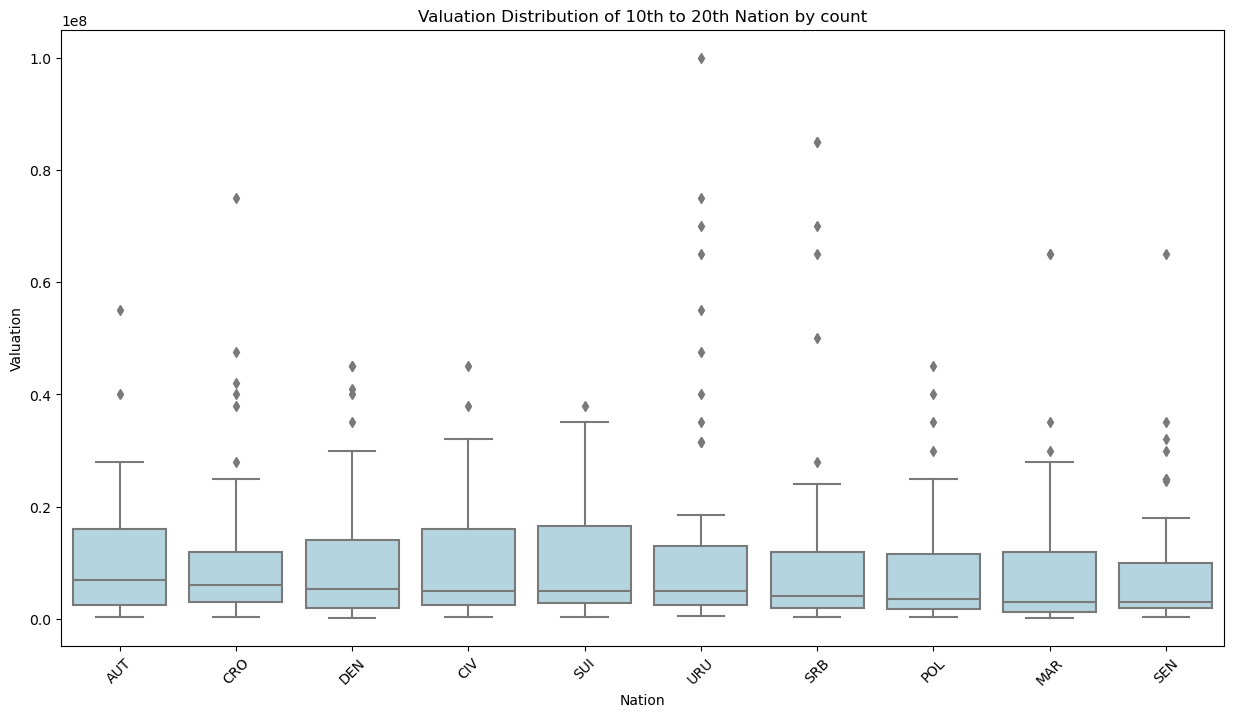

In [37]:
# Set a variable for next 10 nations by count
nation_index = df1.groupby(df1['Nation'])['Nation'].count().sort_values(ascending = False).head(20).index
nation_index = nation_index[10:20]

# Sort nations by median value
median_valuations = df1[df1['Nation'].isin(nation_index)].groupby('Nation')['Valuation'].median().sort_values(ascending=False)
sorted_nations = median_valuations.index.tolist()

# Plot figure
plt.figure(figsize=(15, 8))
sns.boxplot(data=df1[df1['Nation'].isin(nation_index)], x='Nation', y='Valuation', order=sorted_nations, color = 'lightblue')
plt.xticks(rotation=45)
plt.xlabel('Nation')
plt.ylabel('Valuation')
plt.title('Valuation Distribution of 10th to 20th Nation by count')

plt.show()

The median values seem very similar between these nations. We can check if there is a significant difference between these nations through the ANOVA test.

In [38]:
from scipy.stats import f_oneway

# Extract valuation data for each nation in your selected top 10 nations
nation_valuations = [df1[df1['Nation'] == nation]['Valuation'] for nation in nation_index]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*nation_valuations)

print("F-statistic:", f_statistic)
print("P-value:", p_value)



F-statistic: 1.2907852815017578
P-value: 0.2381604021887701


Due to the much lower counts, we have a much higher p value for the next 10 nations. Hence, we can not conclude there is a significant difference in valuations among these nations. We can look at the tukey hsd results for these too.

In [39]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(np.concatenate(nation_valuations), np.concatenate([np.repeat(nation, len(df1[df1['Nation'] == nation])) for nation in nation_index]))
print(tukey_results)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
group1 group2    meandiff   p-adj      lower         upper     reject
---------------------------------------------------------------------
   AUT    CIV  -147023.4114    1.0 -7277763.3608  6983716.5381  False
   AUT    CRO   -32947.4873    1.0 -6871590.6482  6805695.6736  False
   AUT    DEN  -702536.2319    1.0 -7405161.6629  6000089.1991  False
   AUT    MAR  -663596.8379    1.0 -8120669.5095  6793475.8336  False
   AUT    POL -2249083.8509  0.991  -9247459.621  4749291.9191  False
   AUT    SEN -2663369.5652 0.9643  -9441142.548  4114403.4175  False
   AUT    SRB   871739.1304    1.0 -6151765.5383  7895243.7992  False
   AUT    SUI  -972588.3152    1.0 -8131956.7251  6186780.0946  False
   AUT    URU  4160948.6166 0.7532 -3296124.0549 11618021.2881  False
   CIV    CRO   114075.9241    1.0 -6834655.9514  7062807.7995  False
   CIV    DEN  -555512.8205    1.0 -7370424.5634  6259398.9223  False
   CIV    MAR  -5165

Since all the p values are above 0.05, we can conclude there is not a significant difference in the dataset. Realistically, there is likely to be a significant difference if we account for players worldwide and not restrict to players in top 5 leagues. 

However, for purposes of this project, we will not investigate further. 

For all the nations outside of the top 10 nations, we will group them together.

**Creating a new column**

From the above analysis, we have concluded to make a new column with these groups:
- England -> ENG
- Portugal, Belgium, Argentina, Brazil, Netherlands -> POR_BEL_ARG_BRA_NED
- France, Italy, Germany, Spain _> FRA_ITA_GER_ESP
- All other nations -> Other

Let's create the column now.

In [40]:
# Set different groups
Nations1 = ['ENG']
Nations2 = ['POR', 'BEL', 'ARG', 'BRA', 'NED']
Nations3 = ['FRA', 'ITA', 'GER', 'ESP']

# Using np.select to assign groups based on conditions
conditions = [
    df1['Nation'].isin(Nations1),
    df1['Nation'].isin(Nations2),
    df1['Nation'].isin(Nations3)
]

choices = ['ENG', 'POR_BEL_ARG_BRA_NED', 'FRA_ITA_GER_ESP']

# Default 'Other' if none of the conditions are met
df1['Nation_Group'] = np.select(conditions, choices, default='Other')


In [41]:
# Quick check
df1.sample(10)

,Name,Height,Valuation,Nation,Pos,Squad,Comp,Age,Born,MP,...,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%,2023,Team,Nation_Group
1813,Fabio Quagliarella,180.0,500000.0,ITA,FW,Sampdoria,Serie A,40.0,1983,15,...,0.00,0.00,0.0,2.50,1.25,4.00,23.8,1,Bottom,FRA_ITA_GER_ESP
256,Pedro Bigas,181.0,1000000.0,ESP,DF,Elche,La Liga,32.0,1990,17,...,0.07,0.07,0.0,6.06,1.13,0.49,69.6,1,Bottom,FRA_ITA_GER_ESP
1946,Dikeni Salifou,191.0,200000.0,TOG,MF,Werder Bremen,Bundesliga,19.0,2003,1,...,0.00,0.00,0.0,0.00,0.00,0.00,0.0,1,Middle,Other
4100,Stephy Mavididi,182.0,10000000.0,ENG,FWMF,Montpellier,Ligue 1,23.0,1998,30,...,0.00,0.00,0.0,4.35,0.43,1.96,18.0,0,Middle,ENG
3471,Serge Gnabry,176.0,65000000.0,GER,FWDF,Bayern Munich,Bundesliga,26.0,1995,34,...,0.00,0.00,0.0,7.28,0.25,1.40,15.0,0,Top,FRA_ITA_GER_ESP
966,Mathis Hamdi,180.0,150000.0,FRA,DF,Troyes,Ligue 1,19.0,2003,1,...,0.00,0.00,0.0,0.00,0.00,0.00,0.0,1,Bottom,FRA_ITA_GER_ESP
2109,Jack Stacey,180.0,2000000.0,ENG,DF,Bournemouth,Premier League,26.0,1996,9,...,0.00,0.00,0.0,4.55,1.52,0.91,62.5,1,Middle,ENG
3710,Fredrik Jensen,183.0,1500000.0,FIN,MFFW,Augsburg,Bundesliga,24.0,1997,12,...,0.00,0.00,0.0,6.96,1.96,4.13,32.1,0,Bottom,Other
346,Juan Cabal,186.0,2500000.0,COL,DF,Hellas Verona,Serie A,22.0,2001,3,...,0.00,0.00,0.0,15.00,0.00,6.67,0.0,1,Middle,Other
5072,Ruben Vezo,182.0,4000000.0,POR,DF,Levante,La Liga,28.0,1994,32,...,0.04,0.04,0.0,9.00,2.60,1.71,60.3,0,Bottom,POR_BEL_ARG_BRA_NED


We have successfully cleaned the Nation column and seperated them into 4 groups under the column `Nation_Group`. This will be later one hot encoded and the `Nation` column will be dropped.

## 1.3 Player Statistics

We currently have over 100 columns of numeric statistics that we need to carefully look at. A lot of these columns are highly correlated with each other or tell the same information. Let's take a look at our data dictionary and our correlation matrix.

**Data Dictionary from initial Player Statistics datasets**

- **Rk**: Rank
- **Player**: Player's name
- **Nation**: Player's nation
- **Pos**: Position
- **Squad**: Squad’s name
- **Comp**: League that squad occupies
- **Age**: Player's age
- **Born**: Year of birth
- **MP**: Matches played
- **Starts**: Matches started
- **Min**: Minutes played
- **90s**: Minutes played divided by 90
- **Goals**: Goals scored or allowed
- **Shots**: Shots total (Does not include penalty kicks)
- **SoT**: Shots on target (Does not include penalty kicks)
- **SoT%**: Shots on target percentage (Does not include penalty kicks)
- **G/Sh**: Goals per shot
- **G/SoT**: Goals per shot on target (Does not include penalty kicks)
- **ShoDist**: Average distance, in yards, from goal of all shots taken (Does not include penalty kicks)
- **ShoFK**: Shots from free kicks
- **ShoPK**: Penalty kicks made
- **PKatt**: Penalty kicks attempted
- **PasTotCmp**: Passes completed
- **PasTotAtt**: Passes attempted
- **PasTotCmp%**: Pass completion percentage
- **PasTotDist**: Total distance, in yards, that completed passes have traveled in any direction
- **PasTotPrgDist**: Total distance, in yards, that completed passes have traveled towards the opponent's goal
- **PasShoCmp**: Passes completed (Passes between 5 and 15 yards)
- **PasShoAtt**: Passes attempted (Passes between 5 and 15 yards)
- **PasShoCmp%**: Pass completion percentage (Passes between 5 and 15 yards)
- **PasMedCmp**: Passes completed (Passes between 15 and 30 yards)
- **PasMedAtt**: Passes attempted (Passes between 15 and 30 yards)
- **PasMedCmp%**: Pass completion percentage (Passes between 15 and 30 yards)
- **PasLonCmp**: Passes completed (Passes longer than 30 yards)
- **PasLonAtt**: Passes attempted (Passes longer than 30 yards)
- **PasLonCmp%**: Pass completion percentage (Passes longer than 30 yards)
- **Assists**: Assists
- **PasAss**: Passes that directly lead to a shot (assisted shots)
- **Pas3rd**: Completed passes that enter the 1/3 of the pitch closest to the goal
- **PPA**: Completed passes into the 18-yard box
- **CrsPA**: Completed crosses into the 18-yard box
- **PasProg**: Completed passes that move the ball towards the opponent's goal at least 10 yards from its furthest point in the last six passes, or any completed pass into the penalty area
- **PasAtt**: Passes attempted
- **PasLive**: Live-ball passes
- **PasDead**: Dead-ball passes
- **PasFK**: Passes attempted from free kicks
- **TB**: Completed pass sent between back defenders into open space
- **Sw**: Passes that travel more than 40 yards of the width of the pitch
- **PasCrs**: Crosses
- **TI**: Throw-Ins taken
- **CK**: Corner kicks
- **CkIn**: Inswinging corner kicks
- **CkOut**: Outswinging corner kicks
- **CkStr**: Straight corner kicks
- **PasCmp**: Passes completed
- **PasOff**: Offsides
- **PasBlocks**: Blocked by the opponent who was standing it the path
- **SCA**: Shot-creating actions
- **ScaPassLive**: Completed live-ball passes that lead to a shot attempt
- **ScaPassDead**: Completed dead-ball passes that lead to a shot attempt
- **ScaDrib**: Successful dribbles that lead to a shot attempt
- **ScaSh**: Shots that lead to another shot attempt
- **ScaFld**: Fouls drawn that lead to a shot attempt
- **ScaDef**: Defensive actions that lead to a shot attempt
- **GCA**: Goal-creating actions
- **GcaPassLive**: Completed live-ball passes that lead to a goal
- **GcaPassDead**: Completed dead-ball passes that lead to a goal
- **GcaDrib**: Successful dribbles that lead to a goal
- **GcaSh**: Shots that lead to another goal-scoring shot
- **GcaFld**: Fouls drawn that lead to a goal
- **GcaDef**: Defensive actions that lead to a goal
- **Tkl**: Number of players tackled
- **TklWon**: Tackles in which the tackler's team won possession of the ball
- **TklDef3rd**: Tackles in defensive 1/3
- **TklMid3rd**: Tackles in middle 1/3
- **TklAtt3rd**: Tackles in attacking 1/3
- **TklDri**: Number of dribblers tackled
- **TklDriAtt**: Number of times dribbled past plus number of tackles
- **TklDri%**: Percentage of dribblers tackled
- **TklDriPast**: Number of times dribbled past by an opposing player
- **Blocks**: Number of times blocking the ball by standing in its path
- **BlkSh**: Number of times blocking a shot by standing in its path
- **BlkPass**: Number of times blocking a pass by standing in its path
- **Int**: Interceptions
- **Tkl+Int**: Number of players tackled plus number of interceptions
- **Clr**: Clearances
- **Err**: Mistakes leading to an opponent's shot
- **Touches**: Number of times a player touched the ball. Note: Receiving a pass, then dribbling, then sending a pass counts as one touch
- **TouDefPen**: Touches in defensive penalty area
- **TouDef3rd**: Touches in defensive 1/3
- **TouMid3rd**: Touches in middle 1/3
- **TouAtt3rd**: Touches in attacking 1/3
- **TouAttPen**: Touches in attacking penalty area
- **TouLive**: Live-ball touches. Does not include corner kicks, free kicks, throw-ins, kick-offs, goal kicks or penalty kicks.
- **ToAtt**: Number of attempts to take on defenders while dribbling
- **ToSuc**: Number of defenders taken on successfully, by dribbling past them
- **ToSuc%**: Percentage of take-ons Completed Successfully
- **ToTkl**: Number of times tackled by a defender during a take-on attempt
- **ToTkl%**: Percentage of time tackled by a defender during a take-on attempt
- **Carries**: Number of times the player controlled the ball with their feet
- **CarTotDist**: Total distance, in yards, a player moved the ball while controlling it with their feet, in any direction
- **CarPrgDist**: Total distance, in yards, a player moved the ball while controlling it with their feet towards the opponent's goal
- **CarProg**: Carries that move the ball towards the opponent's goal at least 5 yards, or any carry into the penalty area
- **Car3rd**: Carries that enter the 1/3 of the pitch closest to the goal
- **CPA**: Carries into the 18-yard box
- **CarMis**: Number of times a player failed when attempting to gain control of a ball
- **CarDis**: Number of times a player loses control of the ball after being tackled by an opposing player
- **Rec**: Number of times a player successfully received a pass
- **RecProg**: Completed passes that move the ball towards the opponent's goal at least 10 yards from its furthest point in the last six passes, or any completed pass into the penalty area
- **CrdY**: Yellow cards
- **CrdR**: Red cards
- **2CrdY**: Second yellow card
- **Fls**: Fouls committed
- **Fld**: Fouls drawn
- **Off**: Offsides
- **Crs**: Crosses
- **TklW**: Tackles in which the tackler's team won possession of the ball
- **PKwon**: Penalty kicks won
- **PKcon**: Penalty kicks conceded
- **OG**: Own goals
- **Recov**: Number of loose balls recovered
- **AerWon**: Aerials won
- **AerLost**: Aerials lost
- **AerWon%**: Percentage of aerials won


There are a few columns already removed from this data dictionary. A final data dictionary will be created later.

From visual inspection, there are a few columns that tell the same information.

- `Born` and `Age` will be perfectly correlated. I will drop `Born`.
- `Min` and `90s` tell the same information but in different units. I will drop `Min`.


We can also see there are some columns are derived statistics from other columns, which will have perfect multicolinearity.
- `Shots`, `SoT` and `SoT%`. SoT is shots on target, whilst SoT% is the shots on target percentage. These can all be derived from each other, and dropping one of these may be beneficial. 
- `G/SoT` and `G/Sh` are largely also redundant. The first tells the goals per shot on target, whilst the second is goals per shot. These both can be found from dividing `Goals` by `Shots` or `Goals` divided by (`Shots` times `SoT%`).

There are many of these columns which are derived from one another, so I will not drop them for now. This is a process of feature engineering automatically in the dataset that has potential to help the model.

Let's take a look at our correlation matrix for more information.

We can quickly visualize a heatmap of the correlation.

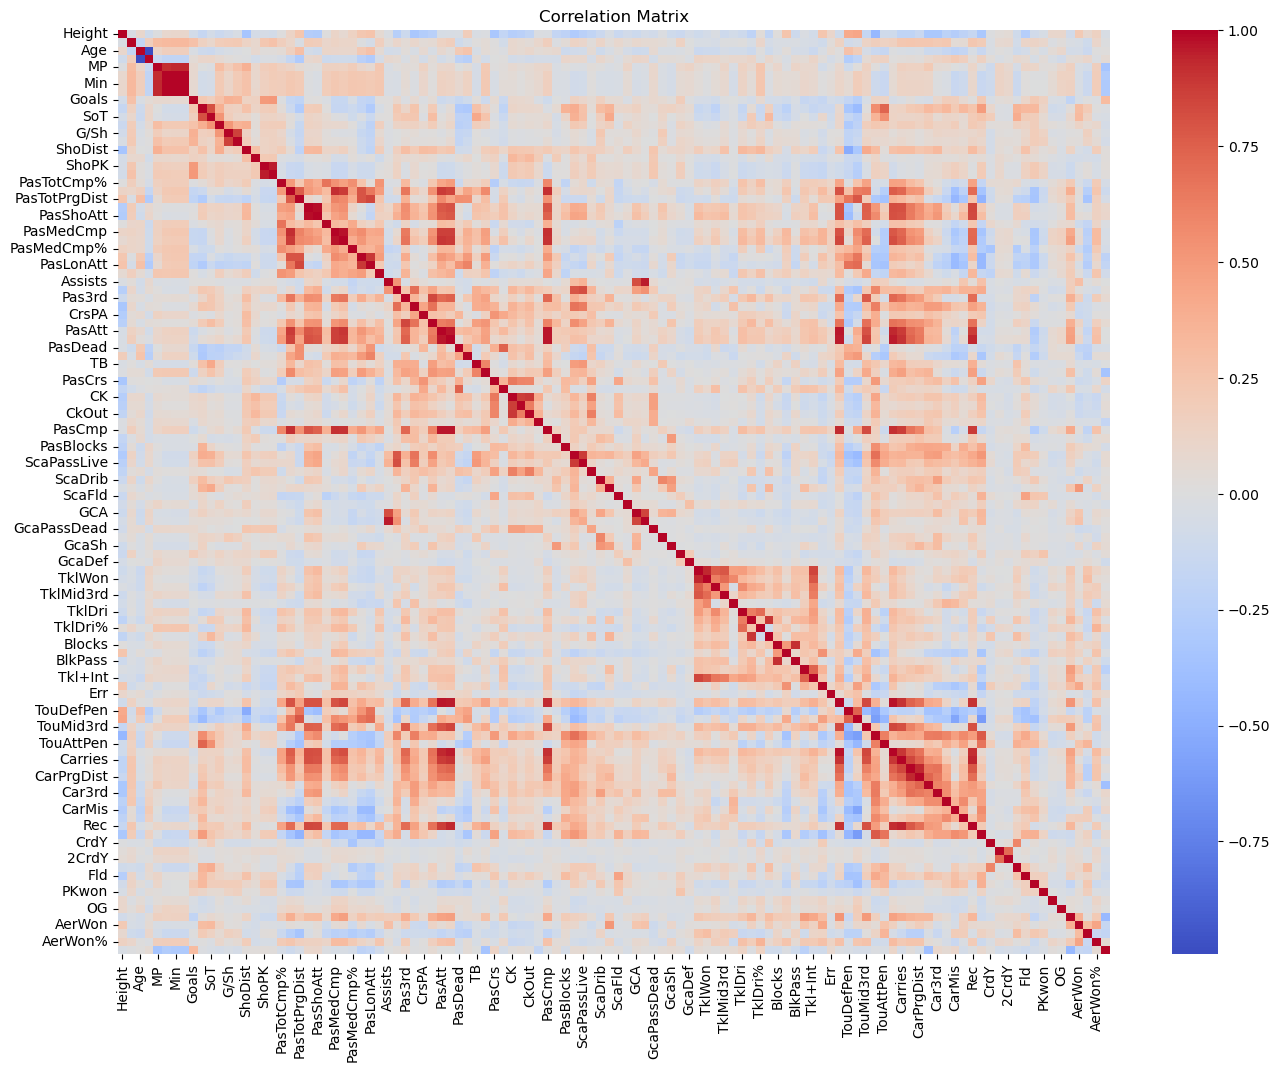

In [42]:
# Filter dataframe for only numeric variables
numeric_df = df1.select_dtypes(include = np.number)

subset = numeric_df.sample(frac=0.1, random_state=1)  # Adjust fraction as needed

correlation_matrix = subset.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()


This visualization is quite heavy. Let's create a table of our correlations, and sort by highest correlations instead.

In [43]:
corr_matrix = numeric_df.corr()

# Create a mask to only display upper triangle (excluding diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Apply the mask to select correlations above the threshold
high_corr = corr_matrix.mask(mask) > 0.50

# Filter the correlations above the threshold
high_corr_values = corr_matrix[high_corr].unstack().sort_values(ascending=False)

# Display as a table
high_corr_table = high_corr_values[high_corr_values != 1.0]  # Exclude self-correlations
high_corr_table = high_corr_table.reset_index()
high_corr_table.columns = ['Feature 1', 'Feature 2', 'Correlation']

high_corr_table[high_corr_table['Correlation'].notna()]


,Feature 1,Feature 2,Correlation
0,Min,90s,0.999996
1,Starts,Min,0.994365
2,Starts,90s,0.994360
3,Touches,TouLive,0.982302
4,PasMedCmp,PasMedAtt,0.981928
...,...,...,...
242,PasMedAtt,PasProg,0.508026
243,PasTotDist,PasShoAtt,0.504319
244,PasTotPrgDist,Touches,0.501870
245,TouAtt3rd,CPA,0.501655


We can also look at the Variance Inflation Factor values to see if there is heavy multicolinearity between different features.

In [44]:
# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(len(numeric_df.columns))]

# Display the VIF values
vif_data.sort_values(by = 'VIF', ascending = False).head(20)

,Feature,VIF
7,90s,294556.225969
6,Min,294504.727320
71,TklDriAtt,232258.083718
65,Tkl,223121.480915
51,SCA,212036.836694
74,Blocks,191898.792360
76,BlkPass,133236.894382
52,ScaPassLive,117978.515397
36,PasAtt,113192.212786
37,PasLive,95532.471088


**Insight**

It is clear that there are many features that are highly correlated with each other. 
- Generally, a VIF score of 10 and above indicates high multicolinearity.
- Due to all the features being easily interpretable, I will keep the features for now. 

For now, we will leave these features as is. However, as we model, removing features with high VIF is a possibility due to the high multicolinearity between the features.

<a id="OHE"></a>
## 1.4 One Hot Encoding Categorical Variables

Now, we need to one hot encode our two new columns: `Team` and `Nation_Group`.

In [45]:
df1.head()

,Name,Height,Valuation,Nation,Pos,Squad,Comp,Age,Born,MP,...,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%,2023,Team,Nation_Group
0,Brenden Aaronson,177.0,25000000.0,USA,MFFW,Leeds United,Premier League,22.0,2000,20,...,0.0,0.0,0.00,4.86,0.34,1.19,22.2,1,Bottom,Other
1,Yunis Abdelhamid,190.0,700000.0,MAR,DF,Reims,Ligue 1,35.0,1987,22,...,0.0,0.0,0.00,6.64,2.18,1.23,64.0,1,Middle,Other
2,Himad Abdelli,185.0,2500000.0,FRA,MFFW,Angers,Ligue 1,23.0,1999,14,...,0.0,0.0,0.00,8.14,0.93,1.05,47.1,1,Bottom,FRA_ITA_GER_ESP
3,Salis Abdul Samed,179.0,18000000.0,GHA,MF,Lens,Ligue 1,22.0,2000,20,...,0.0,0.0,0.05,6.60,0.50,0.50,50.0,1,Top,Other
4,Laurent Abergel,170.0,3000000.0,FRA,MF,Lorient,Ligue 1,30.0,1993,15,...,0.0,0.0,0.00,6.51,0.31,0.39,44.4,1,Middle,FRA_ITA_GER_ESP


We have a few non numeric columns:
- Name: We can remove this.
- Nation: We have created the `Nation_Group` to address this.
- Pos: We need to one hot encode this.
- Squad: We created `Team` to address this. We can remove this.
- Comp: We need to one hot encode this.
- Nation_Group: We will one hot encode this.
- Team: We will one hot encode this.

In [46]:
# Create a categorical dataframe seperate from main dataframe
categorical_df = df1[['Pos', 'Comp', 'Team', 'Nation_Group']]

In [47]:
categorical_df.head()

,Pos,Comp,Team,Nation_Group
0,MFFW,Premier League,Bottom,Other
1,DF,Ligue 1,Middle,Other
2,MFFW,Ligue 1,Bottom,FRA_ITA_GER_ESP
3,MF,Ligue 1,Top,Other
4,MF,Ligue 1,Middle,FRA_ITA_GER_ESP


In [48]:
# Proceed to one hot encode variables
encoder = OneHotEncoder() 
encoded_values = encoder.fit_transform(categorical_df[['Pos','Comp','Team','Nation_Group']])

#Add column_ as prefix to newly created encoded variables
encoded_df = pd.DataFrame(encoded_values.toarray(),columns=encoder.get_feature_names_out(['Pos','Comp', 'Team', 'Nation_Group'])) 

In [49]:
# Quick check
encoded_df.head()

,Pos_DF,Pos_DFFW,Pos_DFMF,Pos_FW,Pos_FWDF,Pos_FWMF,Pos_GK,Pos_GKMF,Pos_MF,Pos_MFDF,...,Comp_Ligue 1,Comp_Premier League,Comp_Serie A,Team_Bottom,Team_Middle,Team_Top,Nation_Group_ENG,Nation_Group_FRA_ITA_GER_ESP,Nation_Group_Other,Nation_Group_POR_BEL_ARG_BRA_NED
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [50]:
# Quickly check columns are correct
encoded_df.columns

Index(['Pos_DF', 'Pos_DFFW', 'Pos_DFMF', 'Pos_FW', 'Pos_FWDF', 'Pos_FWMF',
       'Pos_GK', 'Pos_GKMF', 'Pos_MF', 'Pos_MFDF', 'Pos_MFFW',
       'Comp_Bundesliga', 'Comp_La Liga', 'Comp_Ligue 1',
       'Comp_Premier League', 'Comp_Serie A', 'Team_Bottom', 'Team_Middle',
       'Team_Top', 'Nation_Group_ENG', 'Nation_Group_FRA_ITA_GER_ESP',
       'Nation_Group_Other', 'Nation_Group_POR_BEL_ARG_BRA_NED'],
      dtype='object')

In [51]:
# Drop one of the newly created columns. 
encoded_df.drop(columns = ['Pos_DF','Comp_Ligue 1','Team_Bottom','Nation_Group_Other'], inplace = True)

In [52]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Pos_DFFW                          5422 non-null   float64
 1   Pos_DFMF                          5422 non-null   float64
 2   Pos_FW                            5422 non-null   float64
 3   Pos_FWDF                          5422 non-null   float64
 4   Pos_FWMF                          5422 non-null   float64
 5   Pos_GK                            5422 non-null   float64
 6   Pos_GKMF                          5422 non-null   float64
 7   Pos_MF                            5422 non-null   float64
 8   Pos_MFDF                          5422 non-null   float64
 9   Pos_MFFW                          5422 non-null   float64
 10  Comp_Bundesliga                   5422 non-null   float64
 11  Comp_La Liga                      5422 non-null   float64
 12  Comp_P

The categorical variables have been successfully encoded.

Let's recreate a numeric dataframe and merge them together afterwards. We can also drop a few columns we listed earlier.

In [53]:
# Recreate numeric dataframe
numeric_df = df1.select_dtypes(include = np.number)

In [54]:
# Check initial shape
numeric_df.shape

(5422, 112)

In [55]:
# Drop columns determined earlier
numeric_df.drop(columns = ['Born','Min'], inplace = True)

In [56]:
# Recheck shape
numeric_df.shape

(5422, 110)

In [57]:
# Merge our two dataframes together
merged_df = pd.concat([encoded_df, numeric_df], axis = 1)

In [58]:
# Recheck shape
merged_df.shape

(5422, 129)

The shape is correct! 110 + 19 = 129 columns for our merged dataframe.

In [59]:
merged_df.head()

,Pos_DFFW,Pos_DFMF,Pos_FW,Pos_FWDF,Pos_FWMF,Pos_GK,Pos_GKMF,Pos_MF,Pos_MFDF,Pos_MFFW,...,Fld,Off,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%,2023
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.26,0.17,0.0,0.0,0.00,4.86,0.34,1.19,22.2,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.50,0.05,0.0,0.0,0.00,6.64,2.18,1.23,64.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.28,0.00,0.0,0.0,0.00,8.14,0.93,1.05,47.1,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.35,0.00,0.0,0.0,0.05,6.60,0.50,0.50,50.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.01,0.00,0.0,0.0,0.00,6.51,0.31,0.39,44.4,1


We still have our valuation as part of this dataset, which we will promptly remove in the next section.

## 1.5 Target variable

From the previous notebook, we can see the distribution for our target variable - Valuation - is extremely skewed to the right. Thus, we can perform a log transform to help normalize this.

In [60]:
# Add a new column which will take the log base e of the valuation
merged_df['Log_Valuation'] = merged_df['Valuation'].apply(np.log)

In [61]:
merged_df[['Log_Valuation','Valuation']]

,Log_Valuation,Valuation
0,17.034386,25000000.0
1,13.458836,700000.0
2,14.731801,2500000.0
3,16.705882,18000000.0
4,14.914123,3000000.0
...,...,...
5417,14.038654,1250000.0
5418,15.068274,3500000.0
5419,15.068274,3500000.0
5420,17.216708,30000000.0


In [62]:
y = merged_df['Log_Valuation']

We can compare the distributions of the original valuation and our log transform. This can help visualize the effect of the transformation and how it can help our model.

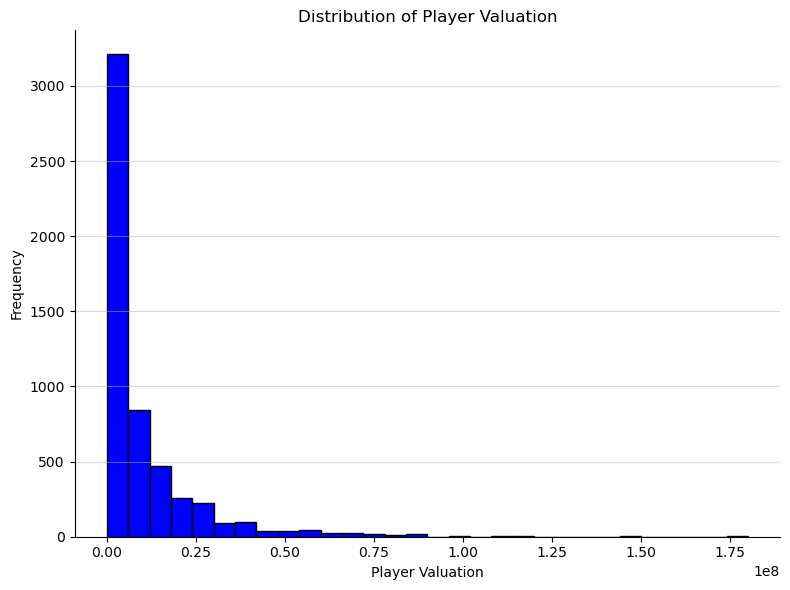

In [63]:
# Set up the figure and axes
plt.figure(figsize=(8, 6))

# Create the histogram
plt.hist(merged_df['Valuation'], bins=30, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Player Valuation')
plt.ylabel('Frequency')
plt.title('Distribution of Player Valuation')

# Add gridlines
plt.grid(axis='y', alpha=0.5)

sns.despine()

# Show plot
plt.tight_layout()
plt.show()

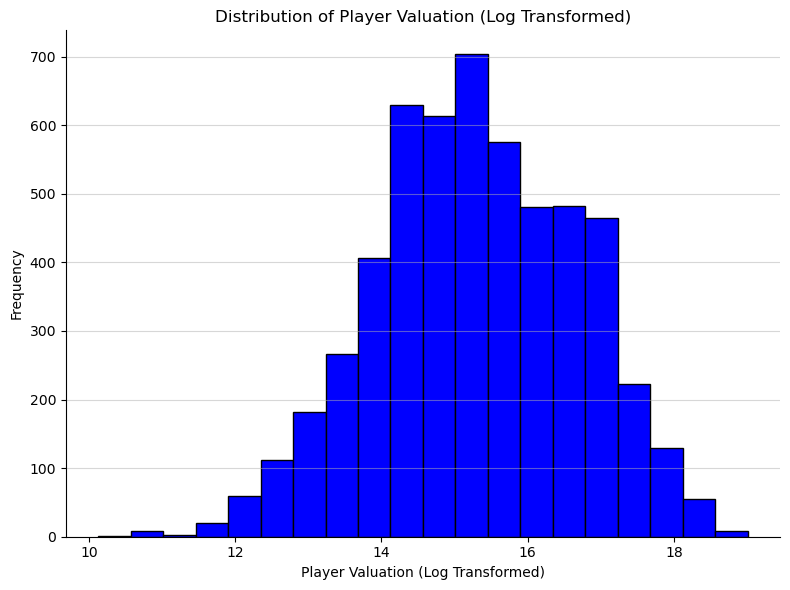

In [64]:
# Set up the figure and axes
plt.figure(figsize=(8, 6))

# Create the histogram
plt.hist(y, bins=20, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Player Valuation (Log Transformed)')
plt.ylabel('Frequency')
plt.title('Distribution of Player Valuation (Log Transformed)')

# Add gridlines
plt.grid(axis='y', alpha=0.5)

sns.despine()

# Show plot
plt.tight_layout()
plt.show()

Compared the the original distribution, our tranformed distribution is much more normally distributed. This should help our models tremendously.

Finally, we can create our final features dataframe by dropping our target variables.

In [65]:
# Drop target variables
final_df = merged_df.drop(columns = ['Valuation','Log_Valuation'])

In [66]:
# Sanity check
final_df

,Pos_DFFW,Pos_DFMF,Pos_FW,Pos_FWDF,Pos_FWMF,Pos_GK,Pos_GKMF,Pos_MF,Pos_MFDF,Pos_MFFW,...,Fld,Off,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%,2023
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.26,0.17,0.00,0.0,0.00,4.86,0.34,1.19,22.2,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.50,0.05,0.00,0.0,0.00,6.64,2.18,1.23,64.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.28,0.00,0.00,0.0,0.00,8.14,0.93,1.05,47.1,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.35,0.00,0.00,0.0,0.05,6.60,0.50,0.50,50.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.01,0.00,0.00,0.0,0.00,6.51,0.31,0.39,44.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5417,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.06,1.67,0.04,0.0,0.00,2.40,1.06,1.63,39.4,0
5418,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.25,0.00,0.00,0.0,0.00,13.10,4.38,1.25,77.8,0
5419,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.96,0.00,0.00,0.0,0.00,11.00,3.08,1.35,69.6,0
5420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.64,0.00,0.00,0.0,0.00,7.94,1.21,1.26,49.1,0


We are ready to do our first baseline model. Even though we have done a baseline model previously, I will redo it as we now have fully included all required columns.

<a id="BaselineModeling"></a>
# Baseline Modeling - Linear Regression

Our first baseline model will be a simple linear regression. We will first scale our data and then we will proceed to do a first test, and a quick evaluation. Afterwards, we will apply PCA to reduce the dimensionality of the data. We will also try some regularization. Lastly, we will then evaluate the model and use it as a benchmark.

### Train Test Split

We first create a Train Test split to create our training set and test set. 

In [67]:
# Split into remainder and test set
X_train, X_test, y_train, y_test = train_test_split(final_df, y, test_size = 0.25, random_state=717)


In [68]:
print(X_train.shape)
print(y_train.shape)

(4066, 128)
(4066,)


## 2.1 Scaling for Linear Regression

First, we scale our training and test data. This should help with our model performance.

In [698]:
# Set our scaler and fit on train data
scaler = StandardScaler()
scaler.fit(X_train)

# Transform train and test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames, set the correct index
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled.index = X_train.index

X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled.index = X_test.index

joblib.dump(scaler,'scaler.pkl')

I will perform a basic model on the scaled data and record it's evaluation scores.

In [70]:
# Add constant to prepare for linear regression
X_train_scaled_constant = sm.add_constant(X_train_scaled)
X_test_scaled_constant = sm.add_constant(X_test_scaled)


In [71]:
X_train_scaled_constant

,const,Pos_DFFW,Pos_DFMF,Pos_FW,Pos_FWDF,Pos_FWMF,Pos_GK,Pos_GKMF,Pos_MF,Pos_MFDF,...,Fld,Off,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%,2023
947,1.0,-0.117099,-0.175878,-0.415658,-0.105789,-0.326643,-0.276615,0.0,1.932204,-0.154672,...,0.536321,-0.359475,-0.075218,-0.20218,-0.154938,-0.311960,-0.672186,-0.646461,0.311213,1.067181
46,1.0,-0.117099,-0.175878,-0.415658,-0.105789,-0.326643,-0.276615,0.0,1.932204,-0.154672,...,-0.004690,-0.359475,-0.075218,-0.20218,-0.154938,-0.191760,-0.177277,-0.622390,1.302544,1.067181
1049,1.0,-0.117099,-0.175878,2.405822,-0.105789,-0.326643,-0.276615,0.0,-0.517544,-0.154672,...,3.018607,-0.359475,-0.075218,-0.20218,-0.154938,0.589543,0.096378,2.396127,-0.878385,1.067181
66,1.0,-0.117099,-0.175878,2.405822,-0.105789,-0.326643,-0.276615,0.0,-0.517544,-0.154672,...,-0.959416,-0.359475,-0.075218,-0.20218,-0.154938,-1.794433,-0.875972,-0.814959,-1.671449,1.067181
4641,1.0,-0.117099,-0.175878,2.405822,-0.105789,-0.326643,-0.276615,0.0,-0.517544,-0.154672,...,1.689947,-0.359475,-0.075218,-0.20218,-0.154938,-0.841415,-0.875972,-0.280581,-1.671449,-0.937049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2801,1.0,-0.117099,-0.175878,-0.415658,-0.105789,3.061446,-0.276615,0.0,-0.517544,-0.154672,...,-0.959416,-0.359475,-0.075218,-0.20218,-0.154938,0.114465,1.062906,-0.010984,0.973422,-0.937049
4443,1.0,-0.117099,-0.175878,-0.415658,-0.105789,3.061446,-0.276615,0.0,-0.517544,-0.154672,...,-0.299064,-0.026642,-0.075218,-0.20218,-0.154938,-0.203207,0.469016,0.788177,-0.045667,-0.937049
5196,1.0,-0.117099,-0.175878,-0.415658,-0.105789,-0.326643,3.615135,0.0,-0.517544,-0.154672,...,-0.959416,-0.359475,-0.075218,-0.20218,-0.154938,-0.841415,-0.875972,-0.814959,-1.671449,-0.937049
1560,1.0,-0.117099,-0.175878,2.405822,-0.105789,-0.326643,-0.276615,0.0,-0.517544,-0.154672,...,1.284189,0.095980,-0.075218,-0.20218,-0.154938,-0.804210,3.077477,2.088017,0.430172,1.067181


We are ready to instantiate our first linear model.

In [72]:
# Instantiate linear model on our scaled data
linear_model = sm.OLS(y_train, X_train_scaled_constant).fit()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:          Log_Valuation   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     55.76
Date:                Sat, 06 Jan 2024   Prob (F-statistic):               0.00
Time:                        06:14:53   Log-Likelihood:                -5016.4
No. Observations:                4066   AIC:                         1.029e+04
Df Residuals:                    3938   BIC:                         1.110e+04
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

Compared to our baseline model in our last notebook, this model has a much higher R squared score of 0.654 and an adjusted R squared score of 0.641.

We can see many features have a high p value, and from earlier discovery, many features have a high variance inflation factor. For now, we will simply evaluate it and store the evaluation metrics as a baseline value. 

However, we should first check our assumptions for linear regression for this dataset.
- We will plot a histogram of residuals
- We will plot a QQ plot to evaluate normality of residuals
- We will do Shapiro Wilk test to definitively evaluate normailty of residuals

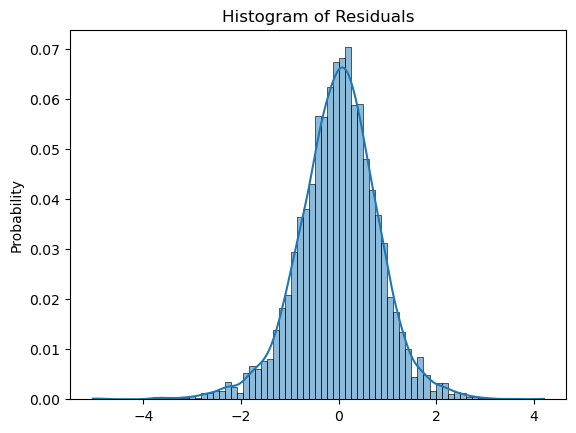

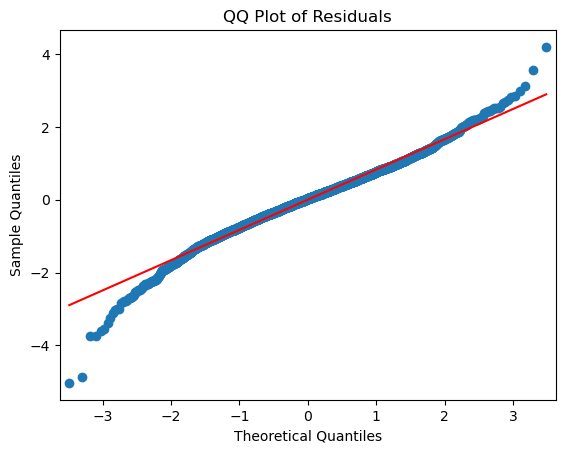

Shapiro Wilk test on residuals: 
Tstat: 0.98 
P value: 0.0


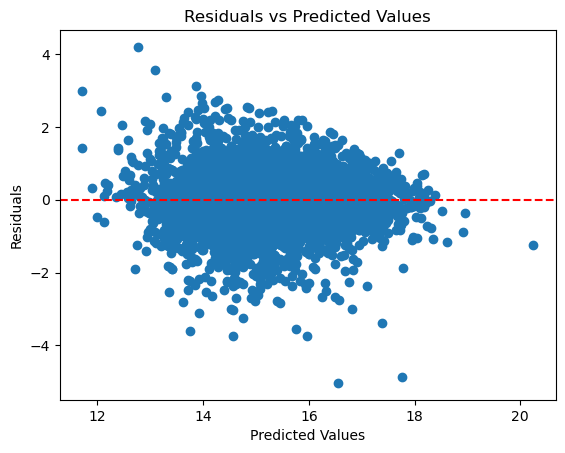

In [73]:
# Check for residual normality
# Plot histogram of residuals to check if normal
sns.histplot(linear_model.resid, stat = 'probability', kde = True)
plt.title('Histogram of Residuals')
plt.show()

# QQ plot to further look into residuals
linear_model_qqplot = sm.qqplot(linear_model.resid, line = 's')
plt.title('QQ Plot of Residuals')
plt.show()

# Check Shapiro Wilk test on residuals
tstat, pval = stats.shapiro(linear_model.resid)
print(f"Shapiro Wilk test on residuals: \nTstat: {round(tstat, 2)} \nP value: {round(pval, 2)}")

# Check if variance increases/ decreases over fitted values/ homoscedasticityl
residuals = linear_model.resid
predicted_values = linear_model.fittedvalues

plt.scatter(predicted_values, residuals)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

**Insight**

- From above, we can see from the histogram that the residuals seem somewhat normally distributed. 
- However, from the qq plot, we see that it does not follow the red line, meaning it is not a normal distribution. 
- The Shapiro Wilk test has a p value of less than 0.05, meaning we reject the null hypothesis and conclude that the residual distribution is not normally distributed. 
- There is no pattern to the residuals vs predicted values, which implies the data is homoscedastic. 

Thus, we need to take this linear model with this caveat in mind - that the assumptions are not fully held. This will reduce the power of the model. However, it does not seem the model violates the assumptions spectacularly.

## 2.2 Evaluation

Our next step is to find the mean absolute error and mean percentage error for this model. We can create these by creating predictions from our model and comparing it to our target values (y_train and y_test).

In [292]:
# Get predicted values from our model
predictions_train = linear_model.predict(X_train_scaled_constant)
predictions_test = linear_model.predict(X_test_scaled_constant)

# Inverse log transform on predictions
predictions_train_original_scale = np.exp(predictions_train)
predictions_test_original_scale = np.exp(predictions_test)

# Calculate MAE on original scale
train_mae_original_scale = np.mean(abs(np.exp(y_train) - predictions_train_original_scale))
test_mae_original_scale = np.mean(abs(np.exp(y_test) - predictions_test_original_scale))

# Calculate PMAE on original scale
train_pmae_original_scale = np.mean(abs((np.exp(y_train) - predictions_train_original_scale) / np.exp(y_train))) * 100
test_pmae_original_scale = np.mean(abs((np.exp(y_test) - predictions_test_original_scale) / np.exp(y_test))) * 100


In [293]:
# Quick check on the different scores
print(train_mae_original_scale)
print(test_mae_original_scale)
print(train_pmae_original_scale)
print(test_pmae_original_scale)

5261096.199543136
5403642.507740088
94.50064583456643
142.4077750903075


From above, we can see our evaluation scores have been successfully calculated. Let's save these scores into a DataFrame.

In [76]:
# Create a new dataframe, with the first entry as log_model
log_model = {
    'Model': 'Linear_Regression',
    'R_Squared': np.round(linear_model.rsquared, 2),
    'Adj_R_Squared': np.round(linear_model.rsquared_adj, 2),
    'MAE_train': round(train_mae_original_scale),
    'MAE_test': round(test_mae_original_scale),
    'PMAE_train': round(train_pmae_original_scale, 1),
    'PMAE_test': round(test_pmae_original_scale, 1)
}

# Creating a new dataframe called model_scores.
model_scores = pd.DataFrame([log_model])


In [77]:
# Check our new dataframe
model_scores

,Model,R_Squared,Adj_R_Squared,MAE_train,MAE_test,PMAE_train,PMAE_test
0,Linear_Regression,0.64,0.63,5261096,5403643,94.5,142.4


**Insights**

We have our first baseline model with it's evaluation metrics in this dataframe. 
- With close values between the train metrics and test metrics, it is unlikely our data is overfitting. However, as this is our baseline model, we do not have much to compare to as of yet.
- This is significantly better than our initial baseline model in the last notebook, which had a r squared value of roughly 0.375 and mean absolute error of 7,000,000.

Our next step is to do some basic optimization of the model.

## 2.3 Optimization

Let's take a look at our summary chart for our model again. We can look into removing the factors with high p values.

**Note**: After proceeding with RFE in the final model, RFE could be performed here instead of this manual process.

In [294]:
# Taking a look at our initial model
linear_model = sm.OLS(y_train, X_train_scaled_constant).fit()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:          Log_Valuation   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     55.76
Date:                Sun, 07 Jan 2024   Prob (F-statistic):               0.00
Time:                        05:43:46   Log-Likelihood:                -5016.4
No. Observations:                4066   AIC:                         1.029e+04
Df Residuals:                    3938   BIC:                         1.110e+04
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

Clearly, there are too many features to efficiently remove columns with high p values one by one.

I can imagine several possible approaches here:

1. Remove all the features that have high p values, but only in it's 'category'. For example, I would only remove one column from the `Pos` features at a time. I could only remove `Shots` but not `SoT`, even though they both have over 0.05 p value, they are related and the subsequent p value may go down after removal of these similar elements.
2. Look at VIF factors and remove features with the highest VIF.
3. Perform some form of dimensionality reduction such as PCA or SelectKBest. This should automatically reduce the significance of less relevant features. However, this makes the features more difficult to explain and harder to interpret.
4. Perform some regularization to reduce the effect of irrelevant features.
5. Introduce interaction terms, which is a form of feature engineering. 

Due to time constraints, I will perform a mix of regularization and removing features with high VIF. This should reduce multicolinearity between features and potentially improve the model, which is our ultimate goal.

In [295]:
# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_scaled_constant.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled_constant.values, i) for i in range(len(X_train_scaled_constant.columns))]

# Display the VIF values
vif_data.sort_values(by = 'VIF', ascending = False).head(30)

,Feature,VIF
95,Tkl+Int,255977.569365
82,Tkl,180268.450906
68,SCA,102408.496438
88,TklDriAtt,100811.491548
91,Blocks,89843.054885
94,Int,73690.753317
93,BlkPass,71204.920311
69,ScaPassLive,61322.730731
90,TklDriPast,47335.515280
84,TklDef3rd,45304.413000


The process is as follows:
- I will drop features by 10 at a time, check the VIF scores and check the R squared score. If the model accuracy decreases, we will stop the process.
- To select the features to drop, I will not drop all of the features above, but select ones from each category. This is because dropping one feature may reduce the VIF score of the features similar to the dropped feature.
- The features to dropped will be ones with less interpretability/ explainability. This will largely be derived from domain knowledge and the data dictionary.

In [296]:
columns_to_drop = ['SCA','TklDriAtt','BlkPass','TklDriPast','PasLive','GcaPassLive','ScaFld','PasDead','PasMedCmp','GcaFld']

# Create new dataframe that drops above columns
X_train_scaled_constant_drop = X_train_scaled_constant.drop(columns = columns_to_drop)
X_test_scaled_constant_drop = X_test_scaled_constant.drop(columns = columns_to_drop)

In [297]:
linear_model_1 = sm.OLS(y_train, X_train_scaled_constant_drop).fit()
print(linear_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:          Log_Valuation   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     60.06
Date:                Sun, 07 Jan 2024   Prob (F-statistic):               0.00
Time:                        05:44:05   Log-Likelihood:                -5029.7
No. Observations:                4066   AIC:                         1.030e+04
Df Residuals:                    3948   BIC:                         1.104e+04
Df Model:                         117                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

Our R squared result is practically the same. Let's iterate again to see if there is any significant difference.

We check the new VIF scores.

In [298]:
# Check new VIF scores
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_scaled_constant_drop.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled_constant_drop.values, i) for i in range(len(X_train_scaled_constant_drop.columns))]

# Display the VIF values
vif_data.sort_values(by = 'VIF', ascending = False).head(30)

,Feature,VIF
85,Tkl+Int,253228.714821
75,Tkl,179299.240687
84,Int,72899.329281
77,TklDef3rd,43846.989901
78,TklMid3rd,29063.618295
79,TklAtt3rd,8903.761752
88,Touches,566.604419
52,PasAtt,462.533555
62,PasCmp,380.114048
36,PasTotDist,225.649086


This has reduced a lot of the VIF scores. We can iterate again. This time I will drop less columns as we are nearing an acceptable VIF level. Tradionally, most columns with VIF over 10 is removed.

In [299]:
# Create new columns to drop
columns_to_drop = ['Tkl','TklAtt3rd','PasAtt','TouAtt3rd','Starts','PasLonAtt','TouLive','CarTotDist']

X_train_scaled_constant_drop_2 = X_train_scaled_constant_drop.drop(columns = columns_to_drop)
X_test_scaled_constant_drop_2 = X_test_scaled_constant_drop.drop(columns = columns_to_drop)

In [300]:
# Initiate new model
linear_model_2 = sm.OLS(y_train, X_train_scaled_constant_drop_2).fit()
print(linear_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:          Log_Valuation   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     64.26
Date:                Sun, 07 Jan 2024   Prob (F-statistic):               0.00
Time:                        05:44:23   Log-Likelihood:                -5036.6
No. Observations:                4066   AIC:                         1.029e+04
Df Residuals:                    3956   BIC:                         1.099e+04
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

Once again, no substantial difference in R squared values - slightly worse results. Let's check our VIF factors again.

In [307]:
# Check new VIF scores
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_scaled_constant_drop_2.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled_constant_drop_2.values, i) for i in range(len(X_train_scaled_constant_drop_2.columns))]

# Display the VIF values
vif_data.sort_values(by = 'VIF', ascending = False).head(30)

,Feature,VIF
59,PasCmp,269.051815
35,PasTotDist,202.646718
37,PasShoCmp,113.811935
83,Touches,100.786483
38,PasShoAtt,69.024815
95,Rec,62.799627
40,PasMedAtt,46.519799
80,Tkl+Int,33.814219
42,PasLonCmp,29.913962
84,TouDefPen,24.402668


We can see our VIF scores are rapidly decreasing, and the top features are reducing in VIF scores.

Let's check our other metrics.

In [310]:
# Get predicted values from our model
predictions_train = linear_model_2.predict(X_train_scaled_constant_drop_2)
predictions_test = linear_model_2.predict(X_test_scaled_constant_drop_2)
# Calculate MAE on original scale
train_mae_original_scale = np.mean(abs(np.exp(y_train) - predictions_train_original_scale))
test_mae_original_scale = np.mean(abs(np.exp(y_test) - predictions_test_original_scale))

# Calculate PMAE on original scale
train_pmae_original_scale = np.mean(abs((np.exp(y_train) - predictions_train_original_scale) / np.exp(y_train))) * 100
test_pmae_original_scale = np.mean(abs((np.exp(y_test) - predictions_test_original_scale) / np.exp(y_test))) * 100
# Inverse log transform on predictions
predictions_train_original_scale = np.exp(predictions_train)
predictions_test_original_scale = np.exp(predictions_test)



In [311]:
# Quick check on the different scores
print(train_mae_original_scale)
print(test_mae_original_scale)
print(train_pmae_original_scale)
print(test_pmae_original_scale)

5257637.228703106
5045466.297331284
95.49231152509367
139.18999561760472


In [ ]:
# Create a DataFrame for lin_model_2
lin_model_2 = pd.DataFrame({
    'Model': ['Linear_Regression_2'],
    'R_Squared': [np.round(linear_model_2.rsquared, 2)],
    'Adj_R_Squared': [np.round(linear_model_2.rsquared_adj, 2)],
    'MAE_train': [round(train_mae_original_scale)],
    'MAE_test': [round(test_mae_original_scale)],
    'PMAE_train': [round(train_pmae_original_scale, 1)],
    'PMAE_test': [round(test_pmae_original_scale, 1)]
})

# Append lin_model_2 to model_scores using pd.concat
model_scores = pd.concat([model_scores, lin_model_2], ignore_index=True)


In [ ]:
model_scores

,Model,R_Squared,Adj_R_Squared,MAE_train,MAE_test,PMAE_train,PMAE_test
0,Linear_Regression,0.64,0.63,5261096,5403643,94.5,142.4
1,Linear_Regression_2,0.64,0.63,5257637,5045466,95.5,139.2


We can see that the mean absolute error is actually going down. We can try reducing a few more factors with high VIF.

In [312]:
# Check new VIF scores
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_scaled_constant_drop_2.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled_constant_drop_2.values, i) for i in range(len(X_train_scaled_constant_drop_2.columns))]

# Display the VIF values
vif_data.sort_values(by = 'VIF', ascending = False).head(30)

,Feature,VIF
59,PasCmp,269.051815
35,PasTotDist,202.646718
37,PasShoCmp,113.811935
83,Touches,100.786483
38,PasShoAtt,69.024815
95,Rec,62.799627
40,PasMedAtt,46.519799
80,Tkl+Int,33.814219
42,PasLonCmp,29.913962
84,TouDefPen,24.402668


In [313]:
# Create new columns to drop
columns_to_drop = ['PasTotDist','PasShoCmp','Rec','PasMedAtt','Tkl+Int','PasLonCmp','TouDefPen','Pos_GK','TouMid3rd','MP','CK']

X_train_scaled_constant_drop_3 = X_train_scaled_constant_drop_2.drop(columns = columns_to_drop)
X_test_scaled_constant_drop_3 = X_test_scaled_constant_drop_2.drop(columns = columns_to_drop)

In [314]:
# Initiate new model
linear_model_3 = sm.OLS(y_train, X_train_scaled_constant_drop_3).fit()
print(linear_model_3.summary())

                            OLS Regression Results                            
Dep. Variable:          Log_Valuation   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     70.84
Date:                Sun, 07 Jan 2024   Prob (F-statistic):               0.00
Time:                        05:47:52   Log-Likelihood:                -5051.7
No. Observations:                4066   AIC:                         1.030e+04
Df Residuals:                    3967   BIC:                         1.093e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [315]:
# Get predicted values from our model
predictions_train = linear_model_3.predict(X_train_scaled_constant_drop_3)
predictions_test = linear_model_3.predict(X_test_scaled_constant_drop_3)

# Calculate MAE on original scale
train_mae_original_scale = np.mean(abs(np.exp(y_train) - predictions_train_original_scale))
test_mae_original_scale = np.mean(abs(np.exp(y_test) - predictions_test_original_scale))

# Calculate PMAE on original scale
train_pmae_original_scale = np.mean(abs((np.exp(y_train) - predictions_train_original_scale) / np.exp(y_train))) * 100
test_pmae_original_scale = np.mean(abs((np.exp(y_test) - predictions_test_original_scale) / np.exp(y_test))) * 100
# Inverse log transform on predictions
predictions_train_original_scale = np.exp(predictions_train)
predictions_test_original_scale = np.exp(predictions_test)

# Quick check on the different scores
print(train_mae_original_scale)
print(test_mae_original_scale)
print(train_pmae_original_scale)
print(test_pmae_original_scale)

5257637.228703106
5045466.297331284
95.49231152509367
139.18999561760472


In [105]:
# Create a DataFrame for lin_model_2
lin_model_3 = pd.DataFrame({
    'Model': ['Linear_Regression_3'],
    'R_Squared': [np.round(linear_model_3.rsquared, 2)],
    'Adj_R_Squared': [np.round(linear_model_3.rsquared_adj, 2)],
    'MAE_train': [round(train_mae_original_scale)],
    'MAE_test': [round(test_mae_original_scale)],
    'PMAE_train': [round(train_pmae_original_scale, 1)],
    'PMAE_test': [round(test_pmae_original_scale, 1)]
})

# Append lin_model_3 to model_scores using pd.concat
model_scores = pd.concat([model_scores, lin_model_3], ignore_index=True)


In [106]:
model_scores

,Model,R_Squared,Adj_R_Squared,MAE_train,MAE_test,PMAE_train,PMAE_test
0,Linear_Regression,0.64,0.63,5261096,5403643,94.5,142.4
1,Linear_Regression_2,0.64,0.63,5257637,5045466,95.5,139.2
2,Linear_Regression_3,0.64,0.63,5257637,5045466,95.5,139.2


**Insights**

Since the model has not improved in any metric, we will stop here.
- The mean absolute error and percentage mean absolute error has normalized.
- The R squared error and adjusted R squared error has slightly decrease, to a very insignificant degree.
- Overall, iterating through by removing features with high VIF features have slightly improved our MAE and PMAE scores.

## 2.4 Using Regularization

We can now procced to do some regularization testing to see if this will help our model.

Unfortunately, lasso or ridge regularization can not be applied to `sm.OLS`. We will proceed to use the sklearn package.

We first proceed with a lasso (L1) regression. This is effectively a form of feature selection.

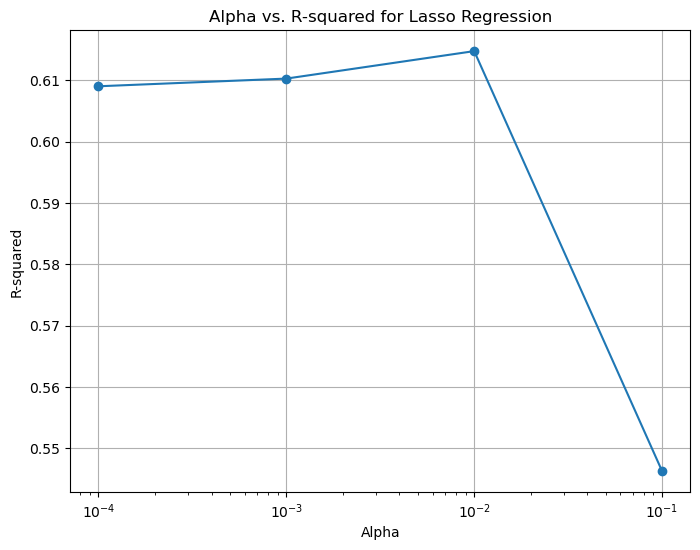

In [ ]:
# List of alpha values to test
alphas = [0.0001, 0.001, 0.01, 0.1]  

# Set empty list for r squared values
r_squared_values = []

# Apply on our original scaled dataframe, not the dropped columns
for alpha in alphas:
    lasso = Lasso(alpha=alpha, fit_intercept=False)
    lasso.fit(X_train_scaled_constant, y_train)
    y_pred = lasso.predict(X_test_scaled_constant)
    r_squared = r2_score(y_test, y_pred)
    r_squared_values.append(r_squared)
    
plt.figure(figsize=(8, 6))
plt.plot(alphas, r_squared_values, marker='o', linestyle='-')
plt.xscale('log')  # Set x-axis to logarithmic scale for better visualization if alphas span multiple orders of magnitude
plt.xlabel('Alpha')
plt.ylabel('R-squared')
plt.title('Alpha vs. R-squared for Lasso Regression')
plt.grid(True)
plt.show()

There seems to be no improvement from using lasso regularization for any alpha. Let's try ridge regression instead. However, we can look at the MAE and PMAE values for reference. We will instantiate the model with the alpha that led to the highest R squared value.

In [108]:
# Set alpha = 0.01
lasso = Lasso(alpha = 0.01, fit_intercept=False)
lasso.fit(X_train_scaled_constant, y_train)
y_pred = lasso.predict(X_test_scaled_constant)
r_squared = r2_score(y_test, y_pred)

# Get predicted values from our model
predictions_train = lasso.predict(X_train_scaled_constant)
predictions_test = lasso.predict(X_test_scaled_constant)

# Calculate MAE on original scale
train_mae_original_scale = np.mean(abs(np.exp(y_train) - predictions_train_original_scale))
test_mae_original_scale = np.mean(abs(np.exp(y_test) - predictions_test_original_scale))

# Calculate PMAE on original scale
train_pmae_original_scale = np.mean(abs((np.exp(y_train) - predictions_train_original_scale) / np.exp(y_train))) * 100
test_pmae_original_scale = np.mean(abs((np.exp(y_test) - predictions_test_original_scale) / np.exp(y_test))) * 100

# Inverse log transform on predictions
predictions_train_original_scale = np.exp(predictions_train)
predictions_test_original_scale = np.exp(predictions_test)

# Quick check on the different scores
print(r_squared)
print(train_mae_original_scale)
print(test_mae_original_scale)
print(train_pmae_original_scale)
print(test_pmae_original_scale)

0.6147682865646534
5314341.065507206
5031679.253250371
96.02245981674588
112.8937580443752


In [110]:
# Create a DataFrame for lasso regression
lasso_model = pd.DataFrame({
    'Model': ['Lasso'],
    'R_Squared': [np.round(r_squared, 2)],
    'Adj_R_Squared': [np.round(r_squared, 2)],
    'MAE_train': [round(train_mae_original_scale)],
    'MAE_test': [round(test_mae_original_scale)],
    'PMAE_train': [round(train_pmae_original_scale, 1)],
    'PMAE_test': [round(test_pmae_original_scale, 1)]
})

# Append lasso to model_scores using pd.concat
model_scores = pd.concat([model_scores, lasso_model], ignore_index=True)


In [111]:
model_scores

,Model,R_Squared,Adj_R_Squared,MAE_train,MAE_test,PMAE_train,PMAE_test
0,Linear_Regression,0.64,0.63,5261096,5403643,94.5,142.4
1,Linear_Regression_2,0.64,0.63,5257637,5045466,95.5,139.2
2,Linear_Regression_3,0.64,0.63,5257637,5045466,95.5,139.2
3,Lasso,0.61,0.61,5314341,5031679,96.0,112.9


**Insights**

- Adding regularization seems to have helped this model in terms of MAE and PMAE.
- The R squared value has increased (the adjusted R squared value does not exist for lasso regression due to feature selection).

We can try a ridge regression to see if scores improve.

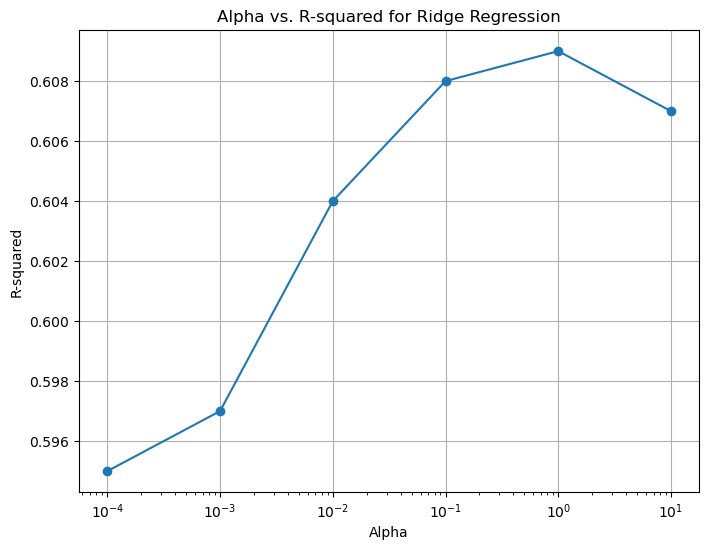

In [249]:
# List of alpha values to test
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]  

# Set empty list for R-squared values
r_squared_values = []

# Use our original X train scaled dataframe, not the dropped columns version
for alpha in alphas:
    ridge = Ridge(alpha=alpha, fit_intercept=False)
    ridge.fit(X_train_scaled_constant, y_train)
    y_pred = ridge.predict(X_test_scaled_constant)
    r_squared = round(r2_score(y_test, y_pred), 3)
    r_squared_values.append(r_squared)
    
plt.figure(figsize=(8, 6))
plt.plot(alphas, r_squared_values, marker='o', linestyle='-')
plt.xscale('log')  # Set x-axis to logarithmic scale for better visualization if alphas span multiple orders of magnitude
plt.xlabel('Alpha')
plt.ylabel('R-squared')
plt.title('Alpha vs. R-squared for Ridge Regression')
plt.grid(True)
# Set y axis format to 2 decimal places

plt.show()

Once again, we will instantiate a model with the alpha that led to the best performing model.

In [135]:
# Instantiate model with alpha = 1
ridge = Ridge(alpha=1, fit_intercept=False)
ridge.fit(X_train_scaled_constant, y_train)

# To derive r squared value
y_pred = ridge.predict(X_test_scaled_constant)
r_squared = r2_score(y_test, y_pred)

# Get predicted values from our model
predictions_train = ridge.predict(X_train_scaled_constant)
predictions_test = ridge.predict(X_test_scaled_constant)

# Inverse log transform on predictions
predictions_train_original_scale = np.exp(predictions_train)
predictions_test_original_scale = np.exp(predictions_test)

# Calculate MAE on original scale
train_mae_original_scale = np.mean(abs(np.exp(y_train) - predictions_train_original_scale))
test_mae_original_scale = np.mean(abs(np.exp(y_test) - predictions_test_original_scale))

# Calculate PMAE on original scale
train_pmae_original_scale = np.mean(abs((np.exp(y_train) - predictions_train_original_scale) / np.exp(y_train))) * 100
test_pmae_original_scale = np.mean(abs((np.exp(y_test) - predictions_test_original_scale) / np.exp(y_test))) * 100

# Quick check on the different scores
print(r_squared)
print(train_mae_original_scale)
print(test_mae_original_scale)
print(train_pmae_original_scale)
print(test_pmae_original_scale)


0.6086116148347762
5267746.861118165
4987983.491602175
94.81285380704165
119.73363658357911


In [119]:
# Create a DataFrame for lasso regression
ridge_model = pd.DataFrame({
    'Model': ['Ridge'],
    'R_Squared': [np.round(r_squared, 2)],
    'Adj_R_Squared': [np.round(r_squared, 2)],
    'MAE_train': [round(train_mae_original_scale)],
    'MAE_test': [round(test_mae_original_scale)],
    'PMAE_train': [round(train_pmae_original_scale, 1)],
    'PMAE_test': [round(test_pmae_original_scale, 1)]
})

# Append lasso to model_scores using pd.concat
model_scores = pd.concat([model_scores, ridge_model], ignore_index=True)


In [128]:
model_scores

,Model,R_Squared,Adj_R_Squared,MAE_train,MAE_test,PMAE_train,PMAE_test
0,Linear_Regression,0.64,0.63,5261096,5403643,94.5,142.4
1,Linear_Regression_2,0.64,0.63,5257637,5045466,95.5,139.2
2,Linear_Regression_3,0.64,0.63,5257637,5045466,95.5,139.2
3,Lasso,0.61,0.61,5314341,5031679,96.0,112.9
4,Ridge,0.61,0.61,5267747,4987983,94.8,119.7


**Insights**

- Our ridge regression model has the lowest mean absolute error so far.
- However, the PMAE is higher than the lasso regression. This is interesting as they are highly correlated with each other. This can be explained by the ridge regression performing better for higher valued players, relatively reducing the MAE, but may perform worse for lower valued players, which lead to a higher relative PMAE.


<a id="DTC"></a>
# 3. Decision Tree

Our next model will be using Decision Tree Regressor. We can use a gridsearch to try optimize for the best hyperparameters. 

In [129]:
%%time

# Set our hyperparamers we want to tune
param_grid = {
    'max_depth': [5,10,20,40],
    'min_samples_leaf': [2,5,10,20],
    'ccp_alpha': [0,0.001,0.01,0.1]
}

# Set our gridsearch
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = 5, n_jobs = 4, verbose = 2)
fittedgrid = grid_search.fit(X_train_scaled, y_train)

# Store best parameters and best model
best_params = fittedgrid.best_params_
best_model = fittedgrid.best_estimator_

# Use best model to fit train data
best_model.fit(X_train_scaled, y_train)

# Store train and test r squared values
train_R_squared = best_model.score(X_train_scaled, y_train)
test_R_squared = best_model.score(X_test_scaled, y_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
CPU times: total: 625 ms
Wall time: 16.4 s


In [130]:
# Check the best parameters
print(best_params)

{'ccp_alpha': 0.001, 'max_depth': 5, 'min_samples_leaf': 10}


In [131]:
# Check our train and test R squared values
print(train_R_squared)
print(test_R_squared)

0.5872588353357816
0.5440902716288849


Our R squared values seem to be quite low. Let's try a gridsearch with more granular hyperparameters around the best parameters found earlier.

In [137]:
%%time

# Set our hyperparamers we want to tune
param_grid = {
    'max_depth': [5,6,7,8,9,10,15,20],
    'min_samples_leaf': [2,3,4,5,6,7,8,9,10],
    'ccp_alpha': [0,0.0001,0.001,0.01,0.1]
}

# Set our gridsearch
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = 5, n_jobs = 4, verbose = 2)
fittedgrid = grid_search.fit(X_train_scaled, y_train)

# Store best parameters and best model
best_params = fittedgrid.best_params_
best_model = fittedgrid.best_estimator_

# Use best model to fit train data
best_model.fit(X_train_scaled, y_train)

# Store train and test r squared values
train_R_squared = best_model.score(X_train_scaled, y_train)
test_R_squared = best_model.score(X_test_scaled, y_test)

# Store adjusted test r squared values
n_test = len(y_test)
k_test = X_test_scaled.shape[1]
adjusted_r_squared_test = 1 - ((1 - test_R_squared) * (n_test - 1) / (n_test - k_test - 1))

# Print train and test R squared, as well as adjusted test r squared
print(train_R_squared)
print(test_R_squared)
print(adjusted_r_squared_test)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
0.643229911720872
0.5601136199968128
0.5142249022784688
CPU times: total: 4.38 s
Wall time: 1min 25s


In [133]:
# Print best parameters
print(best_params)

{'ccp_alpha': 0.0001, 'max_depth': 6, 'min_samples_leaf': 9}


These R Squared values are lower than our linear regression models. We can now try calculate MAE and PMAE values.

First, we set up the model with the best parameters.

In [147]:
# Instantiate model with best paramers
dtr = DecisionTreeRegressor(max_depth=6, min_samples_leaf=9, ccp_alpha=0, random_state = 100)
dtr_model = dtr.fit(X_train_scaled, y_train)

# Create predicted values for training and test data
predictions_train = dtr_model.predict(X_train_scaled)
predictions_test = dtr_model.predict(X_test_scaled)

# Inverse log transform on predictions
predictions_train_original_scale = np.exp(predictions_train)
predictions_test_original_scale = np.exp(predictions_test)

# Calculate MAE on original scale
train_mae_original_scale = np.mean(abs(np.exp(y_train) - predictions_train_original_scale))
test_mae_original_scale = np.mean(abs(np.exp(y_test) - predictions_test_original_scale))

# Calculate PMAE on original scale
train_pmae_original_scale = np.mean(abs((np.exp(y_train) - predictions_train_original_scale) / np.exp(y_train))) * 100
test_pmae_original_scale = np.mean(abs((np.exp(y_test) - predictions_test_original_scale) / np.exp(y_test))) * 100

# Print evalation metrics
print(train_mae_original_scale)
print(test_mae_original_scale)
print(train_pmae_original_scale)
print(test_pmae_original_scale)

5496749.436255839
5722089.287376437
86.29979614230227
98.22131745041054


In [149]:
# Create a DataFrame for Dec Tree
dec_tree = pd.DataFrame({
    'Model': ['Decision_Tree'],
    'R_Squared': [np.round(test_R_squared, 2)],
    'Adj_R_Squared': [np.round(adjusted_r_squared_test, 2)],
    'MAE_train': [round(train_mae_original_scale)],
    'MAE_test': [round(test_mae_original_scale)],
    'PMAE_train': [round(train_pmae_original_scale)],
    'PMAE_test': [round(test_pmae_original_scale)]
})

# Append Dec Tree to model_scores using pd.concat
model_scores = pd.concat([model_scores, dec_tree], ignore_index=True)


In [150]:
model_scores

,Model,R_Squared,Adj_R_Squared,MAE_train,MAE_test,PMAE_train,PMAE_test
0,Linear_Regression,0.64,0.63,5261096,5403643,94.5,142.4
1,Linear_Regression_2,0.64,0.63,5257637,5045466,95.5,139.2
2,Linear_Regression_3,0.64,0.63,5257637,5045466,95.5,139.2
3,Lasso,0.61,0.61,5314341,5031679,96.0,112.9
4,Ridge,0.61,0.61,5267747,4987983,94.8,119.7
5,Decision_Tree,0.56,0.51,5496749,5722089,86.0,98.0


**Insights**

- Decision trees have relatively lower R squared values compared to the linear regression models so far.
- Decision tree has the lowest PMAE so far, for both train and test.
- Decision tree has the highest MAE for both train and test.
- This may be due to valuing lower valued players better, but worse for highest value players, especially outliers.

<a id="RF"></a>
# 4. Random Forests

We move onto our next model, which will be random forest regressor. Once again, we will do a general grid search to try determine the best hyperparameters.

In [157]:
%%time

# Set our hyperparamers we want to tune
param_grid = {
    'max_depth': [5,7,9,11,15,20],
    'min_samples_leaf': [3,5,7,9,10],
    'ccp_alpha': [0,0.001,0.01,0.1],
    'n_estimators': [20,50,100,200]
}

# Set our gridsearch
forest_search = GridSearchCV(RandomForestRegressor(), param_grid, cv = 5, n_jobs = 4, verbose = 2)
fittedgrid = forest_search.fit(X_train_scaled, y_train)

# Store best parameters and best model
best_params = fittedgrid.best_params_
best_model = fittedgrid.best_estimator_

# Use best model to fit train data
best_model.fit(X_train_scaled, y_train)

# Store train and test r squared values
train_R_squared = best_model.score(X_train_scaled, y_train)
test_R_squared = best_model.score(X_test_scaled, y_test)

# Store adjusted test r squared values
n_test = len(y_test)
k_test = X_test_scaled.shape[1]
adjusted_r_squared_test = 1 - ((1 - test_R_squared) * (n_test - 1) / (n_test - k_test - 1))

print(train_R_squared)
print(test_R_squared)
print(adjusted_r_squared_test)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
0.9292804571389797
0.6774823563700763
0.6438374840109644
CPU times: total: 1min 31s
Wall time: 2h 5min 39s


**Note**: The time taken for this gridsearch is over 2 hours.

In [158]:
# List best parameters
best_params

{'ccp_alpha': 0, 'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 200}

From the R squared train and test scores, we can see that there is quite severe overfitting, with the training accuracy around 25 points higher than the test accuracy. However, the R squared test accuracy is still higher than my other models. I will subsequently look at the MAE and PMAE values of the model with best parameters to compare.

In [159]:
# Instantiate model with best paramers
forest = RandomForestRegressor(max_depth=20, min_samples_leaf=3, ccp_alpha=0, n_estimators = 200, random_state = 100)
forest_model = forest.fit(X_train_scaled, y_train)

# Create predicted values for training and test data
predictions_train = forest_model.predict(X_train_scaled)
predictions_test = forest_model.predict(X_test_scaled)

# Inverse log transform on predictions
predictions_train_original_scale = np.exp(predictions_train)
predictions_test_original_scale = np.exp(predictions_test)

# Calculate MAE on original scale
train_mae_original_scale = np.mean(abs(np.exp(y_train) - predictions_train_original_scale))
test_mae_original_scale = np.mean(abs(np.exp(y_test) - predictions_test_original_scale))

# Calculate PMAE on original scale
train_pmae_original_scale = np.mean(abs((np.exp(y_train) - predictions_train_original_scale) / np.exp(y_train))) * 100
test_pmae_original_scale = np.mean(abs((np.exp(y_test) - predictions_test_original_scale) / np.exp(y_test))) * 100

# Print statements
print(train_mae_original_scale)
print(test_mae_original_scale)
print(train_pmae_original_scale)
print(test_pmae_original_scale)

2606640.7796782088
4874101.339001206
29.39083435609661
77.67308946545512


In [161]:
# Create a DataFrame for Dec Tree
random_forest_results = pd.DataFrame({
    'Model': ['Random_Forest'],
    'R_Squared': [np.round(test_R_squared, 2)],
    'Adj_R_Squared': [np.round(adjusted_r_squared_test, 2)],
    'MAE_train': [round(train_mae_original_scale)],
    'MAE_test': [round(test_mae_original_scale)],
    'PMAE_train': [round(train_pmae_original_scale)],
    'PMAE_test': [round(test_pmae_original_scale)]
})

# Append Dec Tree to model_scores using pd.concat
model_scores = pd.concat([model_scores, random_forest_results], ignore_index=True)


In [162]:
model_scores

,Model,R_Squared,Adj_R_Squared,MAE_train,MAE_test,PMAE_train,PMAE_test
0,Linear_Regression,0.64,0.63,5261096,5403643,94.5,142.4
1,Linear_Regression_2,0.64,0.63,5257637,5045466,95.5,139.2
2,Linear_Regression_3,0.64,0.63,5257637,5045466,95.5,139.2
3,Lasso,0.61,0.61,5314341,5031679,96.0,112.9
4,Ridge,0.61,0.61,5267747,4987983,94.8,119.7
5,Decision_Tree,0.56,0.51,5496749,5722089,86.0,98.0
6,Random_Forest,0.68,0.64,2606641,4874101,29.0,78.0


**Insight**

- So far, Random forest regression has the best training and test accuracys for all three metrics. Even though it seems like there is quite severe overfitting, the test accuracy is still the best so far. It may be that the more complex models are more suitable.
- That being said, this model has taken the longest time to execute and we may have to question it's viability in a larger dataset.

<a id="NN"></a>
# 5. Neural Networks

Next, we try apply neural networks to predict the valuation. 

In [169]:
# Instantiate neural network model
NN_model = Sequential()

# Input layer needs to match number of features
NN_model.add(tf.keras.layers.InputLayer(input_shape = (128,)))

# Add dense layers
NN_model.add(keras.layers.Dense(80, activation= 'relu'))
NN_model.add(keras.layers.Dense(40, activation= 'relu'))
NN_model.add(keras.layers.Dense(20, activation= 'relu'))
NN_model.add(keras.layers.Dense(10, activation= 'relu'))

# Output a single node due to regression
NN_model.add(keras.layers.Dense(1)) # Activation is linear for regression output by default

# Compile the model
NN_model.compile(optimizer = tf.keras.optimizers.Adam(),
                 loss = tf.keras.losses.MeanAbsoluteError(),
                 metrics = [MeanAbsoluteError()])

# Fit the model
history = NN_model.fit(X_train_scaled, y_train, epochs = 100, verbose = 2)

# Store the training history per epoch
MAE_list = []
MAE_list = MAE_list + history.history['mean_absolute_error']


Epoch 1/100
128/128 - 1s - loss: 11.5398 - mean_absolute_error: 11.5398 - 596ms/epoch - 5ms/step
Epoch 2/100
128/128 - 0s - loss: 2.3120 - mean_absolute_error: 2.3120 - 87ms/epoch - 680us/step
Epoch 3/100
128/128 - 0s - loss: 1.6476 - mean_absolute_error: 1.6476 - 87ms/epoch - 680us/step
Epoch 4/100
128/128 - 0s - loss: 1.4315 - mean_absolute_error: 1.4315 - 88ms/epoch - 688us/step
Epoch 5/100
128/128 - 0s - loss: 1.2862 - mean_absolute_error: 1.2862 - 87ms/epoch - 680us/step
Epoch 6/100
128/128 - 0s - loss: 1.1387 - mean_absolute_error: 1.1387 - 85ms/epoch - 665us/step
Epoch 7/100
128/128 - 0s - loss: 1.0382 - mean_absolute_error: 1.0382 - 87ms/epoch - 680us/step
Epoch 8/100
128/128 - 0s - loss: 0.9720 - mean_absolute_error: 0.9720 - 87ms/epoch - 680us/step
Epoch 9/100
128/128 - 0s - loss: 0.8765 - mean_absolute_error: 0.8765 - 87ms/epoch - 680us/step
Epoch 10/100
128/128 - 0s - loss: 0.8426 - mean_absolute_error: 0.8426 - 88ms/epoch - 688us/step
Epoch 11/100
128/128 - 0s - loss: 0.79

We can plot the mean absolute error per epoch.

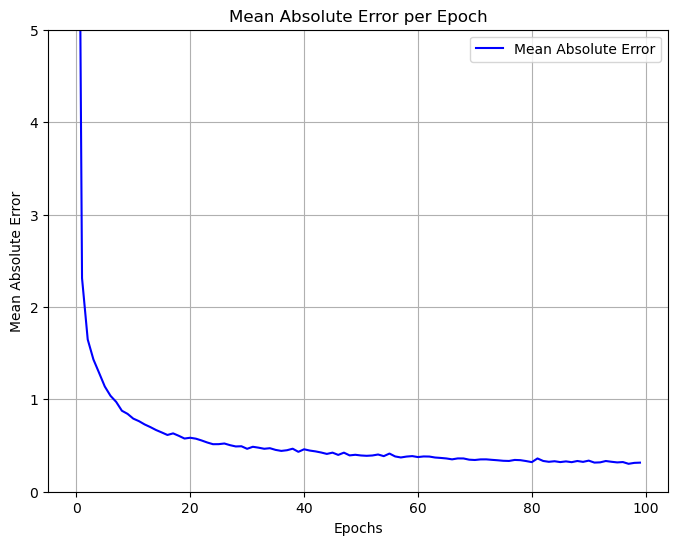

In [173]:
# Set plotting figure
plt.figure(figsize=(8, 6)) 
plt.plot(MAE_list, label='Mean Absolute Error', color='blue')  # Plot MAE_list
plt.ylim(0,5)

# Labels, titles and legends
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')  
plt.title('Mean Absolute Error per Epoch') 
plt.legend() 
plt.grid(True) 

# Show plot
plt.show()


The MAE values are decreasing per epooch, which means the neural network is working properly. We should check our other respective model evaluation metrics.

In [175]:
# Create predicted values for training and test data
predictions_train = NN_model.predict(X_train_scaled)
predictions_test = NN_model.predict(X_test_scaled)

43/43 [==============================] - 0s 572us/step


In [191]:
# Create predicted values for training and test data
predictions_train = NN_model.predict(X_train_scaled)
predictions_test = NN_model.predict(X_test_scaled)

# Find R squared values
train_R_squared = r2_score(y_train, predictions_train)
test_R_squared = r2_score(y_test, predictions_test)

# Inverse log transform on predictions
predictions_train_original_scale = np.exp(predictions_train)
predictions_test_original_scale = np.exp(predictions_test)

# Calculate MAE on original scale, flatten shape due to output from prediction
train_mae_original_scale = np.mean(abs(np.exp(y_train) - predictions_train_original_scale.flatten()))
test_mae_original_scale = np.mean(abs(np.exp(y_test) - predictions_test_original_scale.flatten()))

# Calculate PMAE on original scale
train_pmae_original_scale = np.mean(abs((np.exp(y_train) - predictions_train_original_scale.flatten()) / np.exp(y_train))) * 100
test_pmae_original_scale = np.mean(abs((np.exp(y_test) - predictions_test_original_scale.flatten()) / np.exp(y_test))) * 100

# Print statements
print(train_R_squared)
print(test_R_squared)
print(train_mae_original_scale)
print(test_mae_original_scale)
print(train_pmae_original_scale)
print(test_pmae_original_scale)

43/43 [==============================] - 0s 572us/step
0.8419687009917713
-0.362548085805811
5946083.592786566
2.8222850399681705e+18
77.96753232123721
24541613969992.414


Looks like this neural network is severely overfitting, to the point that the test accuracy is very poor. We can try fit a new neural network.

In [257]:
# set stopping criteria
callbacks = EarlyStopping(monitor='mean_absolute_error', min_delta=0.1, patience=3)

# Instantiate neural network model
NN_model = Sequential()

# Input layer needs to match number of features
NN_model.add(tf.keras.layers.InputLayer(input_shape = (128,)))

# Add dense layers
NN_model.add(keras.layers.Dense(10, activation= 'relu'))

# Output a single node due to regression
NN_model.add(keras.layers.Dense(1)) # Activation is linear for regression output by default

# Compile the model
NN_model.compile(optimizer = tf.keras.optimizers.Adam(),
                 loss = tf.keras.losses.MeanAbsoluteError(),
                 metrics = [MeanAbsoluteError()])

# Fit the model
history = NN_model.fit(X_train_scaled, y_train, epochs = 100, verbose = 2)

# Store the training history per epoch
MAE_list = []
MAE_list = MAE_list + history.history['mean_absolute_error']


Epoch 1/100
128/128 - 0s - loss: 13.4755 - mean_absolute_error: 13.4755 - 360ms/epoch - 3ms/step
Epoch 2/100
128/128 - 0s - loss: 8.8580 - mean_absolute_error: 8.8580 - 76ms/epoch - 592us/step
Epoch 3/100
128/128 - 0s - loss: 5.8738 - mean_absolute_error: 5.8738 - 77ms/epoch - 600us/step
Epoch 4/100
128/128 - 0s - loss: 4.1351 - mean_absolute_error: 4.1351 - 79ms/epoch - 614us/step
Epoch 5/100
128/128 - 0s - loss: 3.1654 - mean_absolute_error: 3.1654 - 78ms/epoch - 608us/step
Epoch 6/100
128/128 - 0s - loss: 2.7171 - mean_absolute_error: 2.7171 - 77ms/epoch - 602us/step
Epoch 7/100
128/128 - 0s - loss: 2.4598 - mean_absolute_error: 2.4598 - 73ms/epoch - 568us/step
Epoch 8/100
128/128 - 0s - loss: 2.2902 - mean_absolute_error: 2.2902 - 75ms/epoch - 583us/step
Epoch 9/100
128/128 - 0s - loss: 2.1488 - mean_absolute_error: 2.1488 - 75ms/epoch - 582us/step
Epoch 10/100
128/128 - 0s - loss: 2.0374 - mean_absolute_error: 2.0374 - 75ms/epoch - 587us/step
Epoch 11/100
128/128 - 0s - loss: 1.93

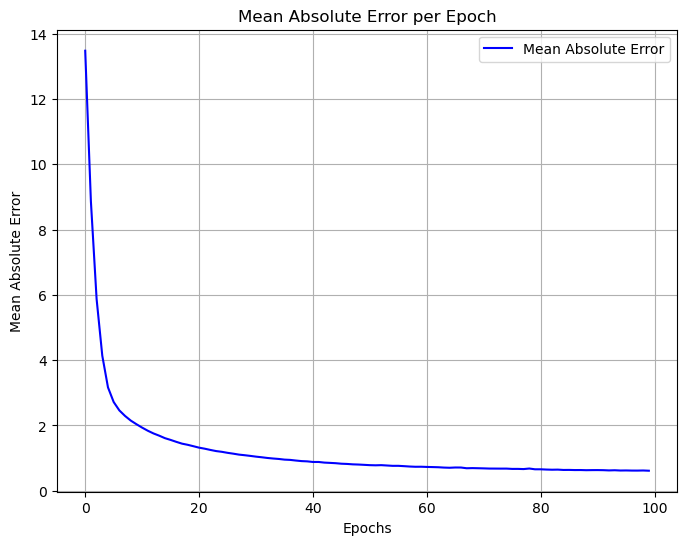

In [259]:
# Set plotting figure
plt.figure(figsize=(8, 6)) 
plt.plot(MAE_list, label='Mean Absolute Error', color='blue')  # Plot MAE_list

# Labels, titles and legends
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')  
plt.title('Mean Absolute Error per Epoch') 
plt.legend() 
plt.grid(True) 

# Show plot
plt.show()


In [261]:
# Create predicted values for training and test data
predictions_train = NN_model.predict(X_train_scaled)
predictions_test = NN_model.predict(X_test_scaled)

# Find R squared values
train_R_squared = r2_score(y_train, predictions_train)
test_R_squared = r2_score(y_test, predictions_test)

# Store adjusted test r squared values
n_test = len(y_test)
k_test = X_test_scaled.shape[1]
adjusted_r_squared_test = 1 - ((1 - test_R_squared) * (n_test - 1) / (n_test - k_test - 1))

# Inverse log transform on predictions
predictions_train_original_scale = np.exp(predictions_train)
predictions_test_original_scale = np.exp(predictions_test)

# Calculate MAE on original scale
train_mae_original_scale = np.mean(abs(np.exp(y_train) - predictions_train_original_scale.flatten()))
test_mae_original_scale = np.mean(abs(np.exp(y_test) - predictions_test_original_scale.flatten()))

# Calculate PMAE on original scale
train_pmae_original_scale = np.mean(abs((np.exp(y_train) - predictions_train_original_scale.flatten()) / np.exp(y_train))) * 100
test_pmae_original_scale = np.mean(abs((np.exp(y_test) - predictions_test_original_scale.flatten()) / np.exp(y_test))) * 100

# Print statements
print(train_R_squared)
print(test_R_squared)
print(adjusted_r_squared_test)
print(train_mae_original_scale)
print(test_mae_original_scale)
print(train_pmae_original_scale)
print(test_pmae_original_scale)

43/43 [==============================] - 0s 580us/step
0.6447015502022544
0.39198477532115306
0.32855694422181125
5212267.17936214
9557184.059747957
94.867768211994
194.3842935488027


In [262]:
# Create a DataFrame for Dec Tree
Neural_Network_results = pd.DataFrame({
    'Model': ['Neural_Network'],
    'R_Squared': [np.round(test_R_squared, 2)],
    'Adj_R_Squared': [np.round(adjusted_r_squared_test, 2)],
    'MAE_train': [round(train_mae_original_scale)],
    'MAE_test': [round(test_mae_original_scale)],
    'PMAE_train': [round(train_pmae_original_scale)],
    'PMAE_test': [round(test_pmae_original_scale)]
})

# Append Dec Tree to model_scores using pd.concat
model_scores = pd.concat([model_scores, Neural_Network_results], ignore_index=True)


In [263]:
model_scores

,Model,R_Squared,Adj_R_Squared,MAE_train,MAE_test,PMAE_train,PMAE_test
0,Linear_Regression,0.64,0.63,5261096,5403643,94.5,142.4
1,Linear_Regression_2,0.64,0.63,5257637,5045466,95.5,139.2
2,Linear_Regression_3,0.64,0.63,5257637,5045466,95.5,139.2
3,Lasso,0.61,0.61,5314341,5031679,96.0,112.9
4,Ridge,0.61,0.61,5267747,4987983,94.8,119.7
5,Decision_Tree,0.56,0.51,5496749,5722089,86.0,98.0
6,Random_Forest,0.68,0.64,2606641,4874101,29.0,78.0
7,Bagging,0.68,0.65,3077737,4899415,37.0,78.0
8,Neural_Network,0.39,0.33,5212267,9557184,95.0,194.0


**Insights**

- Neural networks seems to be heavily overfitting our data.
- Weakest in all metrics so far.
- Will need to be further investigated with different techniques to reduce overfitting.

<a id="Bagging"></a>
# 6. Bagging

Next, we try a bagging algorithm to try predict valuation. This will be very similar to Random Forest, which is already a form of bagging.

In [234]:
%%time

# Set our hyperparamers we want to tune
param_grid = {
    'max_depth': [5,10,20,40],
    'min_samples_leaf': [5,10,20],
    'ccp_alpha': [0,0.0001,0.001,0.01],
    'n_estimators': [100,200,300,400]
}

# Set our gridsearch
bag_search = GridSearchCV(RandomForestRegressor(), param_grid, cv = 5, n_jobs = -1, verbose = 1)
fittedgrid = bag_search.fit(X_train_scaled, y_train)

# Store best parameters and best model
best_params = fittedgrid.best_params_
best_model = fittedgrid.best_estimator_

# Use best model to fit train data
best_model.fit(X_train_scaled, y_train)

# Store train and test r squared values
train_R_squared = best_model.score(X_train_scaled, y_train)
test_R_squared = best_model.score(X_test_scaled, y_test)

# Store adjusted test r squared values
n_test = len(y_test)
k_test = X_test_scaled.shape[1]
adjusted_r_squared_test = 1 - ((1 - test_R_squared) * (n_test - 1) / (n_test - k_test - 1))

print(train_R_squared)
print(test_R_squared)
print(adjusted_r_squared_test)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
0.8963370465848268
0.678705377524665
0.6451880900944752
CPU times: total: 2min 5s
Wall time: 1h 4min 52s


In [236]:
# Print best parameters
print(best_params)

{'ccp_alpha': 0, 'max_depth': 40, 'min_samples_leaf': 5, 'n_estimators': 300}


In [237]:
# Instantiate model with best paramers
bagging = RandomForestRegressor(max_depth = 40, min_samples_leaf = 5, ccp_alpha = 0, n_estimators = 300 , random_state = 100)
bagging_model = bagging.fit(X_train_scaled, y_train)

# Create predicted values for training and test data
predictions_train = bagging_model.predict(X_train_scaled)
predictions_test = bagging_model.predict(X_test_scaled)

# Inverse log transform on predictions
predictions_train_original_scale = np.exp(predictions_train)
predictions_test_original_scale = np.exp(predictions_test)

# Calculate MAE on original scale
train_mae_original_scale = np.mean(abs(np.exp(y_train) - predictions_train_original_scale))
test_mae_original_scale = np.mean(abs(np.exp(y_test) - predictions_test_original_scale))

# Calculate PMAE on original scale
train_pmae_original_scale = np.mean(abs((np.exp(y_train) - predictions_train_original_scale) / np.exp(y_train))) * 100
test_pmae_original_scale = np.mean(abs((np.exp(y_test) - predictions_test_original_scale) / np.exp(y_test))) * 100

# Print statements
print(train_mae_original_scale)
print(test_mae_original_scale)
print(train_pmae_original_scale)
print(test_pmae_original_scale)

3077737.3657617425
4899415.114301342
37.1912614685343
78.11664651255889


In [242]:
# Create a DataFrame for Dec Tree
bagging_results = pd.DataFrame({
    'Model': ['Bagging'],
    'R_Squared': [np.round(test_R_squared, 2)],
    'Adj_R_Squared': [np.round(adjusted_r_squared_test, 2)],
    'MAE_train': [round(train_mae_original_scale)],
    'MAE_test': [round(test_mae_original_scale)],
    'PMAE_train': [round(train_pmae_original_scale)],
    'PMAE_test': [round(test_pmae_original_scale)]
})

# Append Dec Tree to model_scores using pd.concat
model_scores = pd.concat([model_scores, bagging_results], ignore_index=True)


In [243]:
model_scores

,Model,R_Squared,Adj_R_Squared,MAE_train,MAE_test,PMAE_train,PMAE_test
0,Linear_Regression,0.64,0.63,5261096,5403643,94.5,142.4
1,Linear_Regression_2,0.64,0.63,5257637,5045466,95.5,139.2
2,Linear_Regression_3,0.64,0.63,5257637,5045466,95.5,139.2
3,Lasso,0.61,0.61,5314341,5031679,96.0,112.9
4,Ridge,0.61,0.61,5267747,4987983,94.8,119.7
5,Decision_Tree,0.56,0.51,5496749,5722089,86.0,98.0
6,Random_Forest,0.68,0.64,2606641,4874101,29.0,78.0
7,Bagging,0.68,0.65,3077737,4899415,37.0,78.0


**Insight**

- This bagging model has the best R squared and adjusted R squared values so far.
- The MAE and PMAE are very similar to the random forest regression. This sounds realistic as the algorithm is very similar. 
- The time to run this model is quite long. 

<a id="GB"></a>
# 7. Gradient Boosting

Lastly, we can apply a Gradient Boosting regressor. Once again, we apply a gridsearch to model for the valuation.

In [248]:
%%time

# Set our hyperparamers we want to tune
param_grid = {
    'max_depth': [5,10,20,40],
    'min_samples_leaf': [5,10,20],
    'subsample' : [0.5,0.7,0.9],
    'learning_rate': [0.0001,0.001,0.01,0.1]
}

# Set our gridsearch
booster_search = GridSearchCV(GradientBoostingRegressor(), param_grid, cv = 5, n_jobs = -1, verbose = 2)
fittedgrid = booster_search.fit(X_train_scaled, y_train)

# Store best parameters and best model
best_params = fittedgrid.best_params_
best_model = fittedgrid.best_estimator_

# Use best model to fit train data
best_model.fit(X_train_scaled, y_train)

# Store train and test r squared values
train_R_squared = best_model.score(X_train_scaled, y_train)
test_R_squared = best_model.score(X_test_scaled, y_test)

# Store adjusted test r squared values
n_test = len(y_test)
k_test = X_test_scaled.shape[1]
adjusted_r_squared_test = 1 - ((1 - test_R_squared) * (n_test - 1) / (n_test - k_test - 1))

print(train_R_squared)
print(test_R_squared)
print(adjusted_r_squared_test)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
0.8688362041258351
0.7214555170130889
0.6923979018359702
CPU times: total: 20.9 s
Wall time: 21min 55s


In [250]:
# Print the best paramaters
print(best_params)

{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 20, 'subsample': 0.9}


Let's take a look at the other metrics. We will set a booster model with the parameters that led to highest R squared scores.

In [763]:
# Instantiate model with best parameters
booster = GradientBoostingRegressor(max_depth = 5, min_samples_leaf = 20, subsample = 0.9, learning_rate = 0.1, random_state = 100)
booster_model = booster.fit(X_train_scaled, y_train)

# Create predicted values for training and test data
predictions_train = booster_model.predict(X_train_scaled)
predictions_test = booster_model.predict(X_test_scaled)

# Store train and test r squared values
train_R_squared = booster_model.score(X_train_scaled, y_train)
test_R_squared = booster_model.score(X_test_scaled, y_test)

# Store adjusted test r squared values
n_test = len(y_test)
k_test = X_test_scaled.shape[1]
adjusted_r_squared_test = 1 - ((1 - test_R_squared) * (n_test - 1) / (n_test - k_test - 1))

# Inverse log transform on predictions
predictions_train_original_scale = np.exp(predictions_train)
predictions_test_original_scale = np.exp(predictions_test)

# Calculate MAE on original scale
train_mae_original_scale = np.mean(abs(np.exp(y_train) - predictions_train_original_scale))
test_mae_original_scale = np.mean(abs(np.exp(y_test) - predictions_test_original_scale))

# Calculate PMAE on original scale
train_pmae_original_scale = np.mean(abs((np.exp(y_train) - predictions_train_original_scale) / np.exp(y_train))) * 100
test_pmae_original_scale = np.mean(abs((np.exp(y_test) - predictions_test_original_scale) / np.exp(y_test))) * 100

# Print statements
print(train_R_squared)
print(test_R_squared)
print(train_mae_original_scale)
print(test_mae_original_scale)
print(train_pmae_original_scale)
print(test_pmae_original_scale)

0.8655488351187549
0.7190533905929646
3261571.1432048413
4487612.651057239
44.42106685326166
69.27620799229673


In [355]:
# Create a DataFrame for Booster model
booster_results = pd.DataFrame({
    'Model': ['Gradient_Boosting'],
    'R_Squared': [np.round(test_R_squared, 2)],
    'Adj_R_Squared': [np.round(adjusted_r_squared_test, 2)],
    'MAE_train': [round(train_mae_original_scale)],
    'MAE_test': [round(test_mae_original_scale)],
    'PMAE_train': [round(train_pmae_original_scale)],
    'PMAE_test': [round(test_pmae_original_scale)]
})

# Append Booster results to model_scores using pd.concat
model_scores = pd.concat([model_scores, booster_results], ignore_index=True)

In [356]:
model_scores

,Model,R_Squared,Adj_R_Squared,MAE_train,MAE_test,PMAE_train,PMAE_test
0,Linear_Regression,0.64,0.63,5261096,5403643,94.5,142.4
1,Linear_Regression_2,0.64,0.63,5257637,5045466,95.5,139.2
2,Linear_Regression_3,0.64,0.63,5257637,5045466,95.5,139.2
3,Lasso,0.61,0.61,5314341,5031679,96.0,112.9
4,Ridge,0.61,0.61,5267747,4987983,94.8,119.7
5,Decision_Tree,0.56,0.51,5496749,5722089,86.0,98.0
6,Random_Forest,0.68,0.64,2606641,4874101,29.0,78.0
7,Bagging,0.68,0.65,3077737,4899415,37.0,78.0
8,Neural_Network,0.39,0.33,5212267,9557184,95.0,194.0
9,Gradient_Boosting,0.72,0.69,3261571,4487613,44.0,69.0


**Insights**

- Gradient boosting has the highest r squared and adjusted r squared scores. 
- Gradient boosting has the lowest PMAE test scores.
- Gradient boosting has one of the lowest MAE test scores.
- Time to run gradient booster is quite long, but much less than Random Forest and Bagging algorithms.

<a id="MC"></a>
# 8. Model Comparison

After completing all our models, we can now compare the models. We can first take a look at all the model scores and compare within.

In [357]:
model_scores

,Model,R_Squared,Adj_R_Squared,MAE_train,MAE_test,PMAE_train,PMAE_test
0,Linear_Regression,0.64,0.63,5261096,5403643,94.5,142.4
1,Linear_Regression_2,0.64,0.63,5257637,5045466,95.5,139.2
2,Linear_Regression_3,0.64,0.63,5257637,5045466,95.5,139.2
3,Lasso,0.61,0.61,5314341,5031679,96.0,112.9
4,Ridge,0.61,0.61,5267747,4987983,94.8,119.7
5,Decision_Tree,0.56,0.51,5496749,5722089,86.0,98.0
6,Random_Forest,0.68,0.64,2606641,4874101,29.0,78.0
7,Bagging,0.68,0.65,3077737,4899415,37.0,78.0
8,Neural_Network,0.39,0.33,5212267,9557184,95.0,194.0
9,Gradient_Boosting,0.72,0.69,3261571,4487613,44.0,69.0


As we can see, most of our scores for all our models, except neural networks, are quite similar. We can look at each metric indivdually and compare all the models against each other. Afterwards, we can also look at the predictive capabilities of the above models by plotting their predicted values against their actual observed values.

First, we look at our R squared values.

## 8.1 R Squared Values

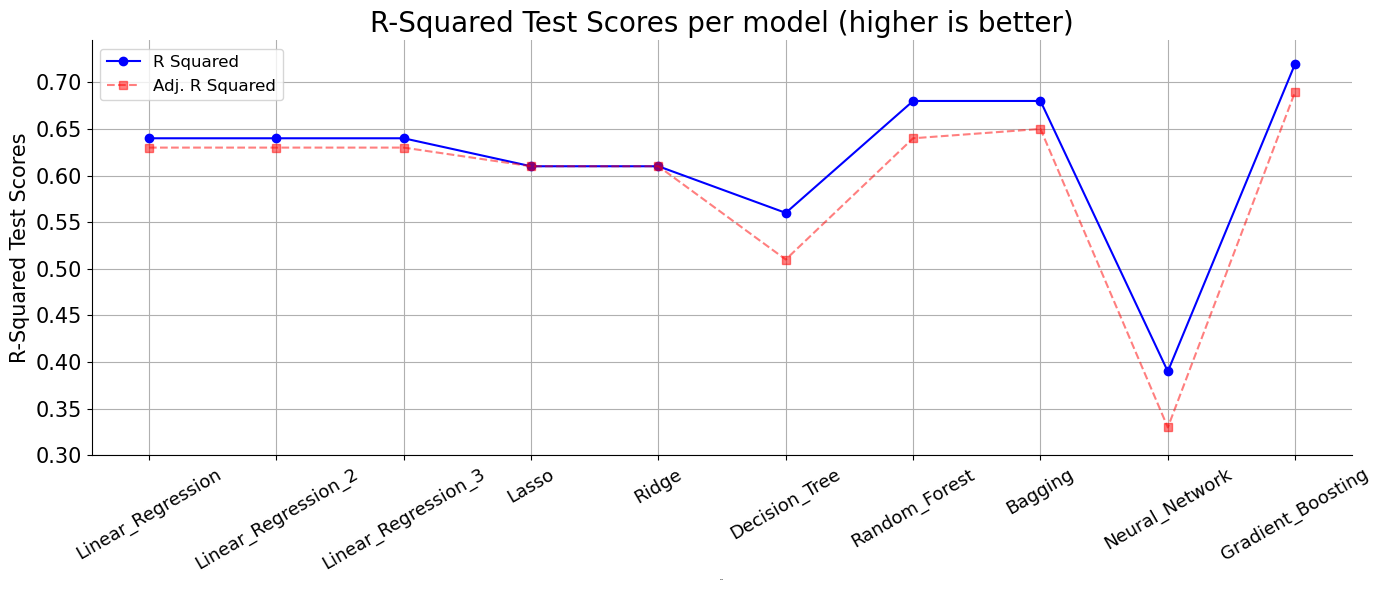

In [641]:
plt.figure(figsize=(14, 6))

# Plot R squared scores against model
plt.plot(model_scores['Model'], model_scores['R_Squared'], marker='o', linestyle='-', color='b', label = 'R Squared')
plt.plot(model_scores['Model'], model_scores['Adj_R_Squared'], marker = 's', linestyle = '--', color = 'red', label = 'Adj. R Squared', alpha = 0.5)

# Plot title and labels
plt.title('R-Squared Test Scores per model (higher is better)', fontsize = 20) 
plt.xlabel('Model', fontsize = 0)  
plt.ylabel('R-Squared Test Scores', fontsize = 15)  

# Make the graph look aesthetically better
plt.ylim(0.30,0.745)
plt.yticks(fontsize = 15)
plt.xticks(rotation=30, fontsize = 13) 
plt.grid(True)  
plt.tight_layout()  
sns.despine()
plt.legend(loc = 'upper left', fontsize = 12)

plt.show()

From the graph above, there are a few insights we can gather:
- Our adjusted R squared and R squared are very similiar in value. This indicates that there are not an excess of unneeded features. It also alludes to the models not overfitting
- Most of our models have R squared values between 0.55 and 0.7. This similarity in scores may indicate that there is not too much room to improve.
- Our best performing model is Graident Boosting, with bagging and random forest as close seconds.

Next, we can plot our mean absolute errors against each other.

## 8.2 MAE Values

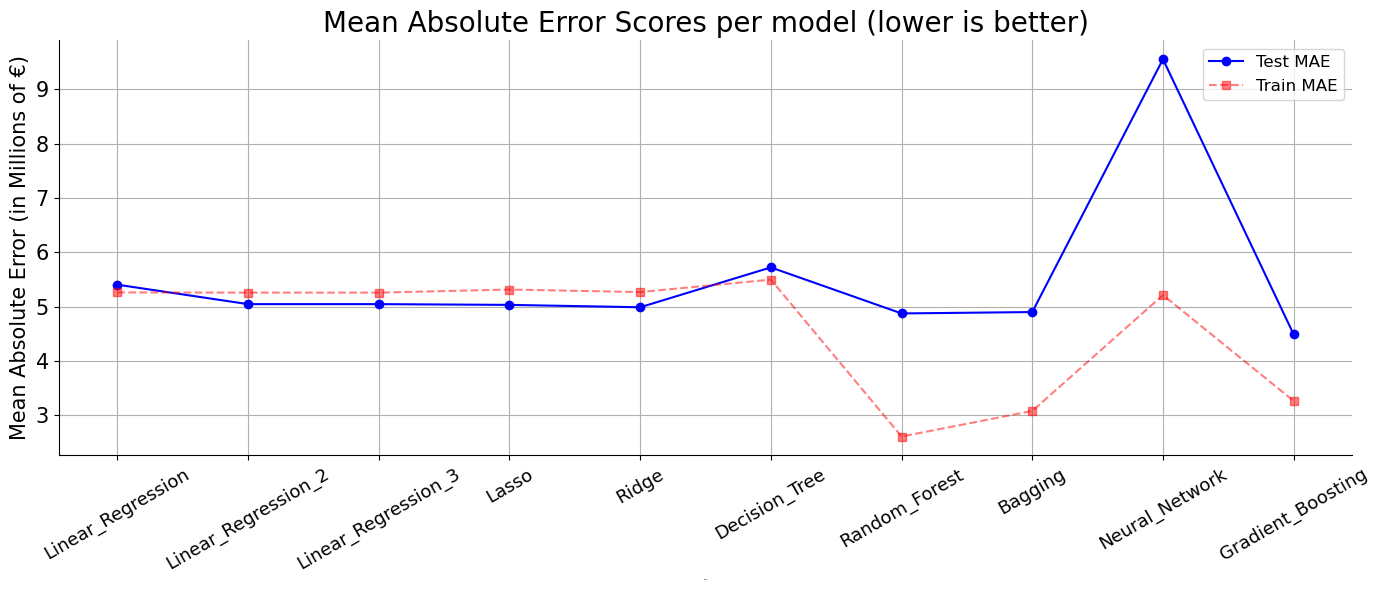

In [642]:
plt.figure(figsize=(14, 6))

# Plot R squared scores against model
plt.plot(model_scores['Model'], model_scores['MAE_test']/ 1_000_000, marker='o', linestyle='-', color='b', label = 'Test MAE')
plt.plot(model_scores['Model'], model_scores['MAE_train']/ 1_000_000, marker = 's', linestyle = '--', color = 'red', label = 'Train MAE', alpha = 0.5)

# Plot title and labels
plt.title('Mean Absolute Error Scores per model (lower is better)', fontsize = 20) 
plt.xlabel('Model', fontsize = 0)  
plt.ylabel('Mean Absolute Error (in Millions of €)', fontsize = 15)  

# Make the graph look aesthetically better
plt.yticks(fontsize = 15)
plt.xticks(rotation=30, fontsize = 13) 
plt.grid(True)  
plt.tight_layout()  
sns.despine()
plt.legend(fontsize = 12)

plt.show()

**Insights** 

- Most of our Mean Absolute Error lies between 4.5 and 5.5 (neural networks is noticably worse).
- Gradient boosting has the lowest mean absolute errors, closely followed by Bagging and Random forest.
- Random forest has the lowest train mean absolute error, but higher test errors, which may indicate overfitting.

Next, we can plot our percentage mean absolute errors against each other.

## 8.3 PMAE Values

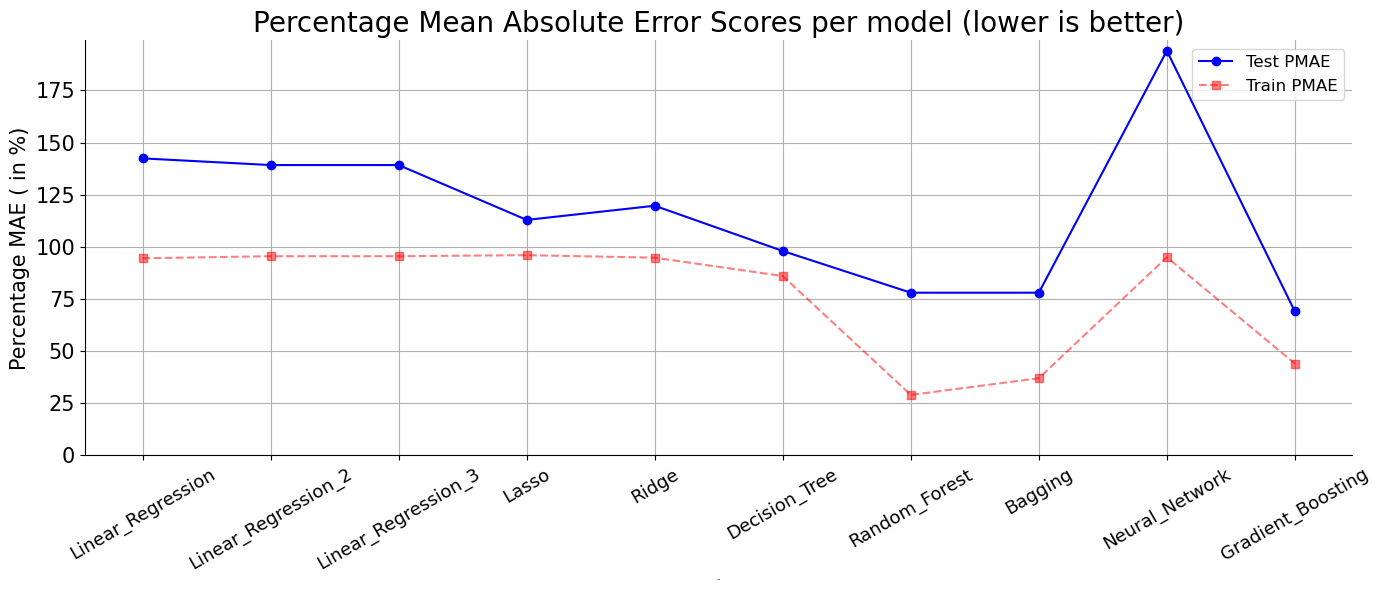

In [646]:
plt.figure(figsize=(14, 6))

# Plot PMAE scores against model
plt.plot(model_scores['Model'], model_scores['PMAE_test'], marker='o', linestyle='-', color='b', label = 'Test PMAE')
plt.plot(model_scores['Model'], model_scores['PMAE_train'], marker = 's', linestyle = '--', color = 'red', label = 'Train PMAE', alpha = 0.5)

# Plot title and labels
plt.title('Percentage Mean Absolute Error Scores per model (lower is better)', fontsize = 20) 
plt.xlabel('Model', fontsize = 0)  
plt.ylabel('Percentage MAE ( in %)', fontsize = 15)  

# Make the graph look aesthetically better
plt.ylim(0,199)
plt.xticks(rotation=30, fontsize = 13)
plt.yticks(fontsize = 15)
plt.grid(True)  
plt.tight_layout()  
sns.despine()
plt.legend(fontsize = 12)

plt.show()

From the graph above, we can observe:
- Gradient Boosting has the lowest percentage mean absolute error.
- The variability of the PMAE values are quite high from 69% to 142% (excluding Neural networks).
- Linear regression is noticably poorer in this metric compared to the other models. 


Lastly, we can plot our predicted values against our actual values and check its spread. 

<a id="VALUES"></a>
## 8.4 Actual Vs Predicted Values 

Lastly, we can create visualizations that show the actual values versus the predicted values for each model. This will give a better idea of how far off the models are for each player.

I will create two sets of subplots:
- One with the 'log' values. This will show a clear depiction of which models perform better.
- One with the values properly transformed into it's original valuations. This will be more chaotic and show the true values.

In [334]:
# Create dataframe with all the test predictions of all the models
pred_test_lr = linear_model.predict(X_test_scaled_constant).ravel()
pred_test_lr2 = linear_model_2.predict(X_test_scaled_constant_drop_2).ravel()
pred_test_lr3 = linear_model_3.predict(X_test_scaled_constant_drop_3).ravel()
pred_test_lasso = lasso.predict(X_test_scaled_constant).ravel()
pred_test_ridge = ridge.predict(X_test_scaled_constant).ravel()
pred_test_dtr = dtr_model.predict(X_test_scaled).ravel()
pred_test_forest = forest_model.predict(X_test_scaled).ravel()
pred_test_nn = NN_model.predict(X_test_scaled).ravel()
pred_test_bagging = bagging_model.predict(X_test_scaled).ravel()
pred_test_booster = booster_model.predict(X_test_scaled).ravel()

# Create dataframe
prediction_data = {
    'pred_test_lr': pred_test_lr,
    'pred_test_lr2': pred_test_lr2,
    'pred_test_lr3': pred_test_lr3,
    'pred_test_lasso' : pred_test_lasso,
    'pred_test_ridge' : pred_test_ridge,
    'pred_test_dtr': pred_test_dtr,
    'pred_test_forest': pred_test_forest,
    'pred_test_nn': pred_test_nn,
    'pred_test_bagging': pred_test_bagging,
    'pred_test_booster': pred_test_booster
}

# Set as dataframe
prediction_df = pd.DataFrame(prediction_data)

# Display dataframe
prediction_df.head(10)

43/43 [==============================] - 0s 561us/step


,pred_test_lr,pred_test_lr2,pred_test_lr3,pred_test_lasso,pred_test_ridge,pred_test_dtr,pred_test_forest,pred_test_nn,pred_test_bagging,pred_test_booster
0,14.878127,14.910123,14.964540,14.893108,14.802308,14.844005,14.953213,14.621668,14.888631,14.823709
1,16.840740,16.816313,16.831987,16.834009,16.834216,16.833232,16.967250,17.289452,16.971849,17.267426
2,15.306953,15.486531,15.570250,15.340330,15.339609,14.837798,14.069180,14.330130,14.143572,14.682170
3,16.466650,16.473634,16.539846,16.532662,16.411378,16.914270,17.187540,16.840801,17.170324,17.075154
4,15.298145,15.348504,15.350611,15.127931,15.306246,15.034066,15.258323,15.837317,15.176159,15.178009
5,15.458149,15.482847,15.472157,15.295447,15.446064,16.277264,15.585948,14.544928,15.681402,15.686243
6,16.449260,16.314832,16.383201,16.291297,16.322051,16.326131,16.593539,16.496664,16.542713,16.522676
7,16.308384,16.242712,16.194289,16.144063,16.181226,15.926953,16.378784,16.448036,16.358101,16.567066
8,16.667071,16.703843,16.660483,16.683077,16.630517,16.611043,16.668145,16.962795,16.615633,16.894773
9,14.530067,14.406339,14.427379,14.368148,14.374286,15.146824,14.652748,14.142027,14.623283,14.746656


Let's save the dataframe in case of any errors.

In [335]:
# Save prediction table
prediction_df.to_csv("Data/prediction_df.csv", index = False)

Now we can plot the actual values versus the predicted values.

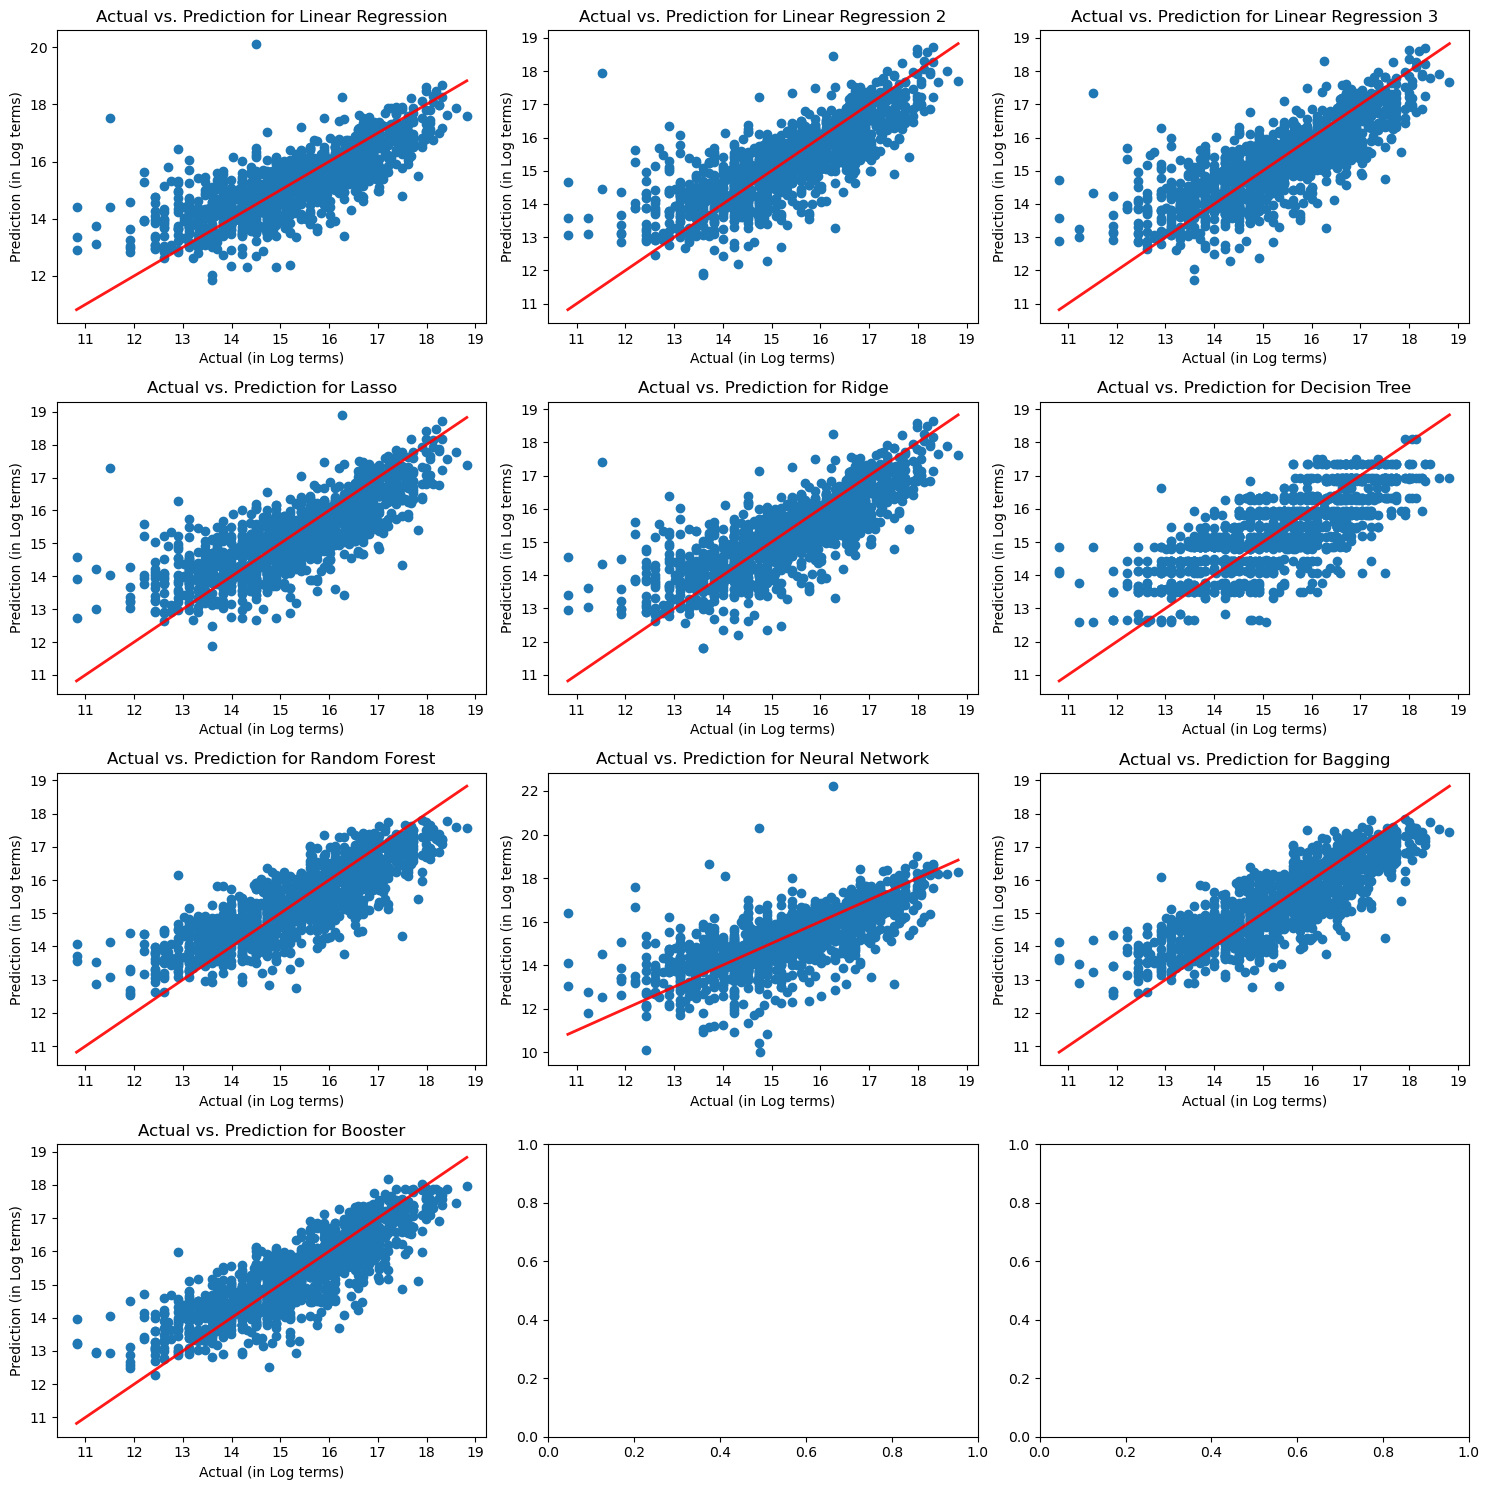

In [338]:
models_name=['Linear Regression', 'Linear Regression 2', 'Linear Regression 3', 'Lasso', 'Ridge', 'Decision Tree', 'Random Forest', 'Neural Network', 'Bagging', 'Booster']

# We will plot these in a subplot format
plt.subplots(4,3, figsize=(15,15))

j=1  # Initialize a counter for subplot placement

# Iterate through each model's predictions
for i in range(len(models_name)):
    
    # Creating a scatter plot for every iteration
    plt.subplot(4,3,j)
    plt.scatter(x = y_test, y=prediction_df.iloc[:,i])
    
    # Set the titles and labels
    plt.title(f'Actual vs. Prediction for {models_name[i]}')
    plt.xlabel('Actual (in Log terms)')
    plt.ylabel('Prediction (in Log terms)')
    
    #Add 45 degree line
    xp = np.linspace(y_test.min(), y_test.max(), 100)
    plt.plot(xp, xp, alpha = 0.9, linewidth = 2, color = 'red')
    j+=1

# Adjust subplot layout for better spacing
plt.tight_layout()

plt.show() 

**Insights**

- We can see that the linear regression based models have quite a few outliers. It is likely the linear regression model was not complex enough to predict those situations.
- Most of our models have similar spread, with decision trees having the highest spread. 
- Booster and Bagging models seem to have the lowest spread and least amount of outliers

We can now transform the predicted and actual values into real valuation terms and see how far the distribution is off in dollars.

In [330]:
# Create dataframe with all the test predictions of all the models - transform to original valuation by taking the exponential
pred_test_lr = np.exp(linear_model.predict(X_test_scaled_constant).ravel())
pred_test_lr2 = np.exp(linear_model_2.predict(X_test_scaled_constant_drop_2).ravel())
pred_test_lr3 = np.exp(linear_model_3.predict(X_test_scaled_constant_drop_3).ravel())
pred_test_lasso = np.exp(lasso.predict(X_test_scaled_constant).ravel())
pred_test_ridge = np.exp(ridge.predict(X_test_scaled_constant).ravel())
pred_test_dtr = np.exp(dtr_model.predict(X_test_scaled).ravel()) 
pred_test_forest = np.exp(forest_model.predict(X_test_scaled).ravel())
pred_test_nn = np.exp(NN_model.predict(X_test_scaled).ravel())
pred_test_bagging = np.exp(bagging_model.predict(X_test_scaled).ravel())
pred_test_booster = np.exp(booster_model.predict(X_test_scaled).ravel())

# Create dataframe
prediction_transformed_data = {
    'pred_test_lr': pred_test_lr,
    'pred_test_lr2': pred_test_lr2,
    'pred_test_lr3': pred_test_lr3,
    'pred_test_lasso' : pred_test_lasso,
    'pred_test_ridge' : pred_test_ridge,
    'pred_test_dtr': pred_test_dtr,
    'pred_test_forest': pred_test_forest,
    'pred_test_nn': pred_test_nn,
    'pred_test_bagging': pred_test_bagging,
    'pred_test_booster': pred_test_booster
}

# Set as dataframe
prediction_transformed_df = pd.DataFrame(prediction_transformed_data)

# Display dataframe
prediction_df.head(10)

43/43 [==============================] - 0s 606us/step


,pred_test_lr,pred_test_lr2,pred_test_lr3,pred_test_lasso,pred_test_ridge,pred_test_dtr,pred_test_forest,pred_test_nn,pred_test_bagging,pred_test_booster
0,2.893934e+06,2.988023e+06,3.155129e+06,2.937613e+06,2.682630e+06,2.796851e+06,3.119594e+06,2.239286e+06,2.924491e+06,2.740658e+06
1,2.059874e+07,2.010166e+07,2.041921e+07,2.046054e+07,2.046478e+07,2.044465e+07,2.337668e+07,3.226364e+07,2.348445e+07,3.156079e+07
2,4.443499e+06,5.317593e+06,5.781941e+06,4.594316e+06,4.591004e+06,2.779547e+06,1.288745e+06,1.673001e+06,1.388274e+06,2.378951e+06
3,1.417017e+07,1.426948e+07,1.524627e+07,1.513714e+07,1.340821e+07,2.217044e+07,2.913759e+07,2.059999e+07,2.864025e+07,2.604024e+07
4,4.404536e+06,4.632022e+06,4.641792e+06,3.715156e+06,4.440359e+06,3.382299e+06,4.232583e+06,7.551959e+06,3.898721e+06,3.905939e+06
5,5.168789e+06,5.298039e+06,5.241701e+06,4.392668e+06,5.106700e+06,1.172536e+07,5.873420e+06,2.073871e+06,6.461694e+06,6.493049e+06
6,1.392589e+07,1.217423e+07,1.303568e+07,1.189105e+07,1.226243e+07,1.231257e+07,1.608727e+07,1.460193e+07,1.529004e+07,1.498673e+07
7,1.209598e+07,1.132714e+07,1.079172e+07,1.026307e+07,1.065166e+07,8.260147e+06,1.297823e+07,1.390885e+07,1.271256e+07,1.566699e+07
8,1.731478e+07,1.796333e+07,1.720108e+07,1.759414e+07,1.669329e+07,1.637134e+07,1.733338e+07,2.327279e+07,1.644666e+07,2.174235e+07
9,2.043279e+06,1.805484e+06,1.843873e+06,1.737830e+06,1.748530e+06,3.786011e+06,2.309978e+06,1.386131e+06,2.242906e+06,2.537414e+06


Let's save the dataframe in case of any errors.

In [332]:
# Save prediction table
prediction_transformed_df.to_csv("Data/prediction_transformed_df.csv", index = False)

Now we can plot the actual values versus the predicted values. This will have much more meaning as it is the original scale, in Euros.

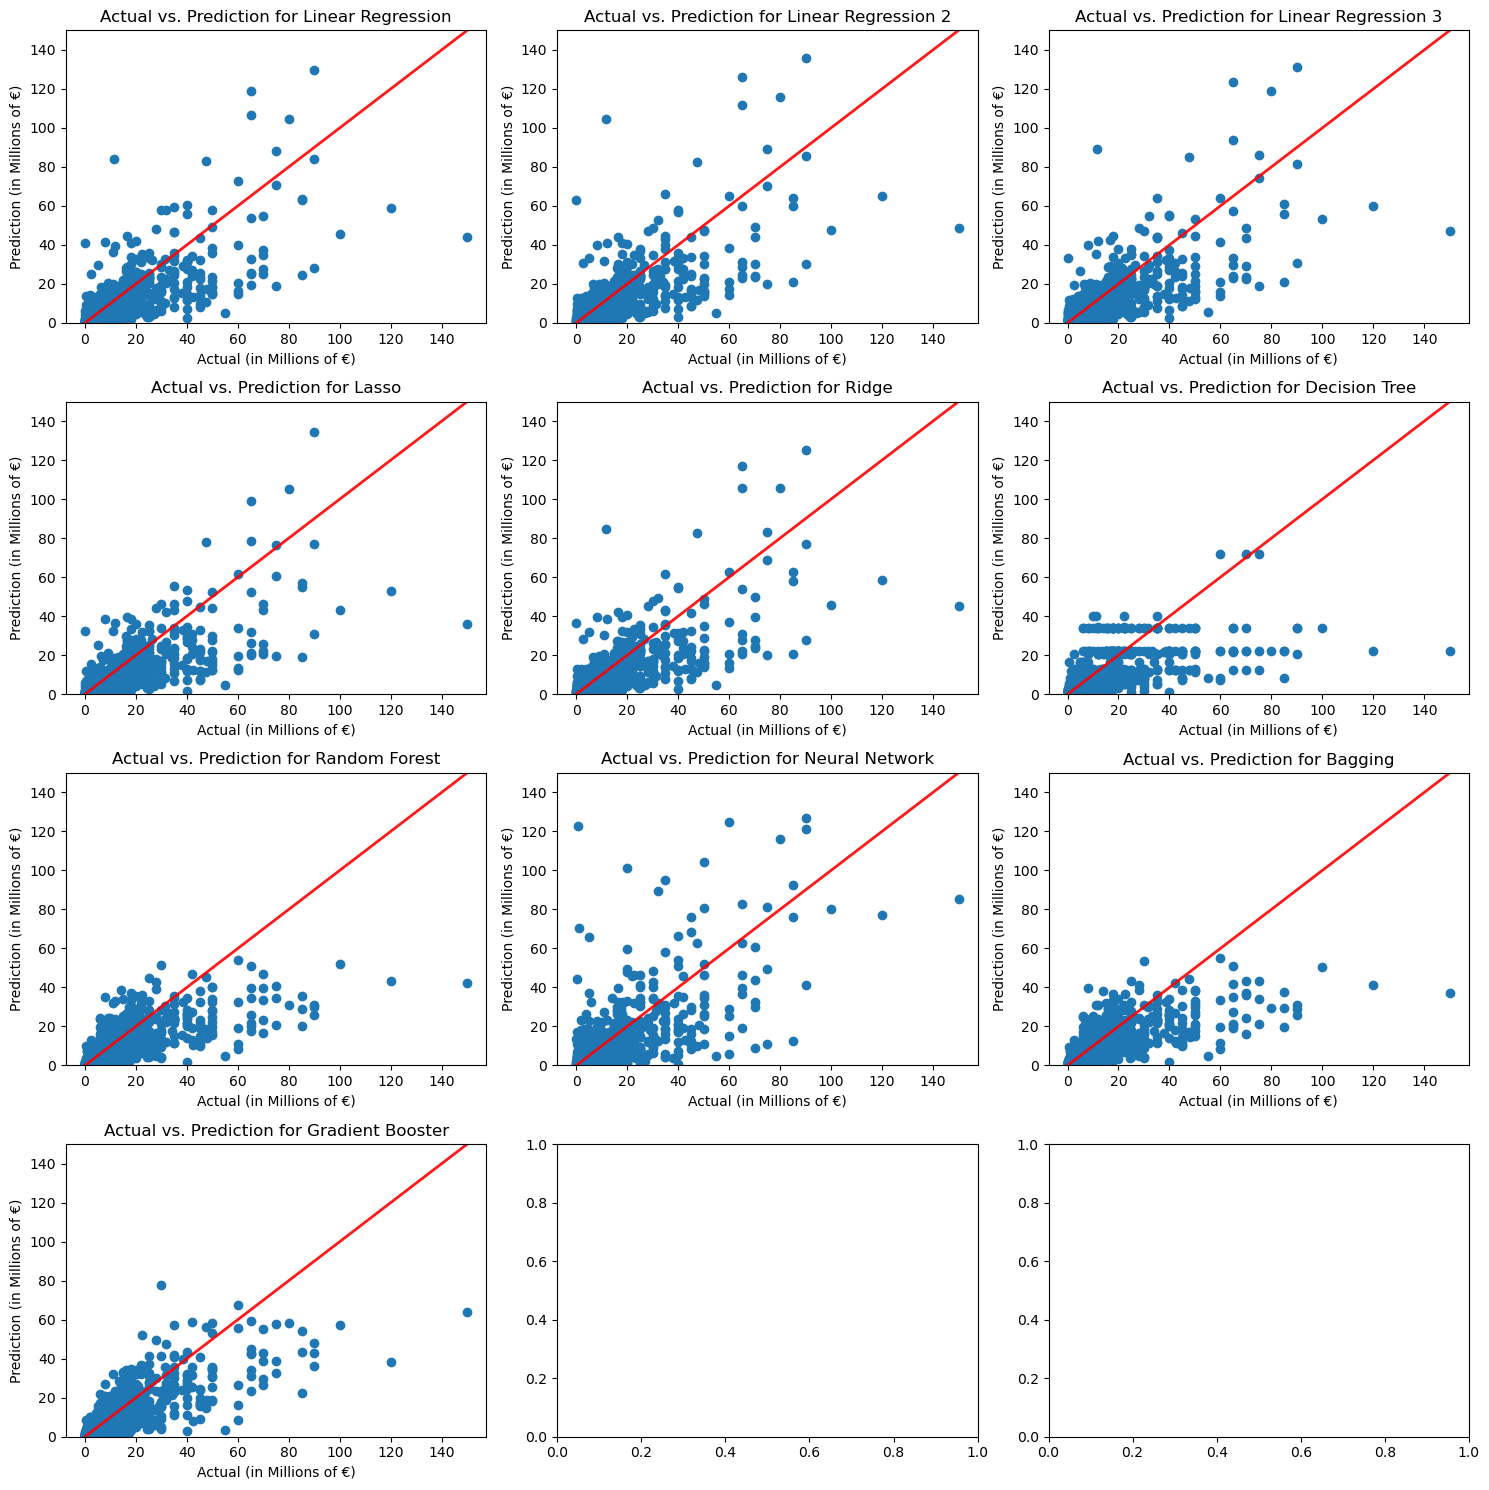

In [366]:
models_name=['Linear Regression', 'Linear Regression 2', 'Linear Regression 3', 'Lasso', 'Ridge', 'Decision Tree', 'Random Forest', 'Neural Network', 'Bagging', 'Gradient Booster']

# We will plot these in a subplot format
plt.subplots(4,3, figsize=(15,15))

j=1  # Initialize a counter for subplot placement

# Iterate through each model's predictions
for i in range(len(models_name)):
    
    # Creating a scatter plot for every iteration
    plt.subplot(4,3,j)
    plt.scatter(x = np.exp(y_test)/1_000_000, y=np.exp(prediction_df.iloc[:,i])/1_000_000)
    
    # Set the titles and labels
    plt.title(f'Actual vs. Prediction for {models_name[i]}')
    plt.xlabel("Actual (in Millions of €)")
    plt.ylabel("Prediction (in Millions of €)")
    plt.ylim(0,150)
    #Add 45 degree line
    xp = np.linspace(np.exp(y_test.min())/1_000_000, np.exp(y_test.max())/1_000_000, 100)
    plt.plot(xp, xp, alpha = 0.9, linewidth = 2, color = 'red')
    j+=1

# Adjust subplot layout for better spacing
plt.tight_layout()

plt.show() 

**Insights**
- All the models were unable to capture the highest valuation players. This is quite interesting as these players may be outliers, of which the model essentially determines so.
- Linear regression models had a higher spread, and managed to capture some higher valuation players.
- Other models generally underpredicted for higher valuation players.
- Neural network was an overall poor model.
- Gradient booster seemed to have most points closest to the red line, indicating it was the most accurate. This model was also unable to capture the higher valued players. 

This finding is actually very interesting - the model determines that most players should be valued less than 80 million, as the highest predicted valuation was less than 80 million. Putting that into football interpretation, the most expensive footballer that was predicted through the players last season statistics was less than 80 million Euros (in terms of the test set). I can see two reasons for this outcome:
1. There is too little data on players worth over 80 million. The model can not accurately determine why players are worth that much.
2. There is no significant difference in statistics between a player worth less than 80 million and those that are worth more. 

My intuition tells me it is a combination of both factors - that the model needs more data but there are also external factors that affect the valuation of especially high valued players. This could be player marketability, contract length, wages and a host of factors outside of on pitch statistics.

I will look further into gradient boosting and perform recursive feature engineering to see if it will improve the model. Afterwards, I will look into the model's most important features through Shap values.

<a id="Optimizing"></a>
# 9. Optimizing Best Model

As we have determined Gradient Boosting is our best model, we can further develop this model and look deeper into the model.
- We will perform recursive feature engineering (RFE) to reduce the number of features.
- We will look at shap values to see which features play the largest role in predicting valuation.
- We will look at specific examples of shap values for several players.

## 9.1 RFE

In [370]:
num_features_to_select = 5 
best_accuracy = 0  
best_selected_features = None  

while num_features_to_select <= 128:  
    
    # Initialize RFE with the GradientBoostingRegressor model and the number of features to select
    rfe = RFE(estimator=booster_model, n_features_to_select=num_features_to_select)
    
    # Fit RFE to your training data
    rfe.fit(X_train_scaled, y_train)
    
    # Get the selected features
    selected_features = X_train.columns[rfe.support_]
    
    # Train the model using selected features and evaluate with your chosen metric
    booster_model.fit(X_train_scaled[selected_features], y_train)
    predictions = booster_model.predict(X_test_scaled[selected_features])
    accuracy = r2_score(y_test, predictions)  
    
    # This is where you decide to stop if the accuracy decreases
    if accuracy < best_accuracy:
        break  # Stop if accuracy decreases
    
    # Update best accuracy and selected features
    best_accuracy = accuracy
    best_selected_features = selected_features
    
    # Increment the number of features to select (you can modify this step based on your strategy)
    num_features_to_select += 5  # Increment by 5 (you can modify this step size)
    
# After the loop, use 'best_selected_features' for further modeling or analysis
print("Best selected features:", best_selected_features)


Best selected features: Index(['Comp_Premier League', 'Team_Middle', 'Team_Top', 'Age', 'Starts',
       '90s', 'Goals', 'Shots', 'PasTotCmp%', 'PasMedCmp%', 'SCA',
       'ScaPassLive', 'GCA', 'TouAtt3rd', 'TouAttPen', 'TouLive', 'Rec',
       'Recov', 'AerWon', '2023'],
      dtype='object')


In [375]:
# Check how many features RFE produced
best_selected_features.shape

(20,)

In [379]:
# Check how the RFE rates each feature
rfe.ranking_

array([104, 103,  71, 100,  98,  97,  95,  94,  93,  92,  32,  23,   1,
        62,   1,   1,  78,   6,  15,  10,   1,   1,   1,   1,   1,   1,
        20,  74,  73,   1,  48,  89,  33,  59,   1,  46,   1,  43,   9,
        56,  52,  28,   1,  54,  24,   1,  39,  11,  29,  76,  44,  21,
        88,  13,  17,  36,   4,  53,  26,   7,  68,  40,  83, 102,  60,
        63,  25,   1,   1,  77,  64,  81,  80,  84,   1,  31,  90,  85,
        87,  82,  96,  61,  70,  16,  57,  75,  72,   3,  69,  27,  58,
        66,  34,  65,  38,  41,  67,  42,  19,  51,   8,   1,   1,   1,
        47,  30,  22,  49,  12,  14,  50,  55,   1,   1,  45,  79, 101,
        18,   2,  37,  91,  99,  86,   1,   1,   5,  35,   1])

In [397]:
rankings = pd.DataFrame(rfe.ranking_, index = X_train_scaled.columns, columns = ['Rank'])
rankings.sort_values(by = 'Rank').head(30)

,Rank
2023,1
90s,1
Goals,1
Shots,1
G/SoT,1
PasTotCmp%,1
PasTotPrgDist,1
PasMedCmp%,1
PasLonCmp%,1
Recov,1


We can check how this model performs with the reduced feature set.

In [765]:
# Save scaler model with less features
X_train_select = X_train[best_selected_features]
X_test_select = X_test[best_selected_features]

# Fit scaler
final_scaler = StandardScaler()
final_scaler.fit(X_train_select)

# Transform train and test using the selected features
X_train_final = final_scaler.transform(X_train_select)
X_test_final = final_scaler.transform(X_test_select)

# Set previous terms
X_train_selected = X_train_final
X_test_selected = X_test_final

# Set our new training and test with reduced features (Original code)
# X_train_selected = X_train_scaled[best_selected_features]
# X_test_selected = X_test_scaled[best_selected_features]

# Fit final booster model
final_booster_model = booster.fit(X_train_selected, y_train)

# Create predicted values for training and test data
predictions_train = final_booster_model.predict(X_train_selected)
predictions_test = final_booster_model.predict(X_test_selected)

# Store train and test r squared values
train_R_squared = final_booster_model.score(X_train_selected, y_train)
test_R_squared = final_booster_model.score(X_test_selected, y_test)

# Store adjusted test r squared values
n_test = len(y_test)
k_test = X_test_selected.shape[1]
adjusted_r_squared_test = 1 - ((1 - test_R_squared) * (n_test - 1) / (n_test - k_test - 1))

# Inverse log transform on predictions
predictions_train_original_scale = np.exp(predictions_train)
predictions_test_original_scale = np.exp(predictions_test)

# Calculate MAE on original scale
train_mae_original_scale = np.mean(abs(np.exp(y_train) - predictions_train_original_scale))
test_mae_original_scale = np.mean(abs(np.exp(y_test) - predictions_test_original_scale))

# Calculate PMAE on original scale
train_pmae_original_scale = np.mean(abs((np.exp(y_train) - predictions_train_original_scale) / np.exp(y_train))) * 100
test_pmae_original_scale = np.mean(abs((np.exp(y_test) - predictions_test_original_scale) / np.exp(y_test))) * 100

# Print statements
print(train_R_squared)
print(test_R_squared)
print(train_mae_original_scale)
print(test_mae_original_scale)
print(train_pmae_original_scale)
print(test_pmae_original_scale)

0.8210159346425178
0.70226610645088
3714943.7570222644
4557021.238208391
53.74958532335664
74.26413633665373


In [744]:
# Save scaler model with less features
X_train_select = X_train[best_selected_features]
X_test_select = X_test[best_selected_features]

# Fit scaler
final_scaler = StandardScaler()
final_scaler.fit(X_train_select)

# Transform train and test using the selected features
X_train_final = final_scaler.transform(X_train_select)
X_test_final = final_scaler.transform(X_test_select)

# Save model
joblib.dump(final_scaler, 'scaler.pkl')

['scaler.pkl']

In [703]:
# Save model for streamlit
joblib.dump(final_booster_model, 'final_model.pkl')

['final_model.pkl']

In [622]:
# Create a DataFrame for Booster model (RFE)
final_booster_results = pd.DataFrame({
    'Model': ['Gradient_Boosting (RFE)'],
    'R_Squared': [np.round(test_R_squared, 2)],
    'Adj_R_Squared': [np.round(adjusted_r_squared_test, 2)],
    'MAE_train': [round(train_mae_original_scale)],
    'MAE_test': [round(test_mae_original_scale)],
    'PMAE_train': [round(train_pmae_original_scale)],
    'PMAE_test': [round(test_pmae_original_scale)]
})

# Append Booster (RFE) results to model_scores using pd.concat
final_model_scores = pd.concat([model_scores, final_booster_results], ignore_index=True)

In [623]:
final_model_scores

,Model,R_Squared,Adj_R_Squared,MAE_train,MAE_test,PMAE_train,PMAE_test
0,Linear_Regression,0.64,0.63,5261096,5403643,94.5,142.4
1,Linear_Regression_2,0.64,0.63,5257637,5045466,95.5,139.2
2,Linear_Regression_3,0.64,0.63,5257637,5045466,95.5,139.2
3,Lasso,0.61,0.61,5314341,5031679,96.0,112.9
4,Ridge,0.61,0.61,5267747,4987983,94.8,119.7
5,Decision_Tree,0.56,0.51,5496749,5722089,86.0,98.0
6,Random_Forest,0.68,0.64,2606641,4874101,29.0,78.0
7,Bagging,0.68,0.65,3077737,4899415,37.0,78.0
8,Neural_Network,0.39,0.33,5212267,9557184,95.0,194.0
9,Gradient_Boosting,0.72,0.69,3261571,4487613,44.0,69.0


**Insights**

- This final model performs slightly worse than the original gradient boosting algorithm, but with only 20 features as opposed to 128 features.
- The 20 features generated by RFE make this model much more explainable.
- Most of the features are offensive statistics; a few of them are categorical features. 

We can take a look at shap values of both the original gradient boosting model, and also the RFE version.

## 9.2 Feature Importance

First, let's take a look at the original dataframe and find the most importance features.

In [664]:
booster_model

GradientBoostingRegressor(max_depth=5, min_samples_leaf=20, random_state=100,
                          subsample=0.9)

In [665]:
booster_model.feature_importances_

array([0.10025171, 0.01354085, 0.14519262, 0.19091911, 0.06717933,
       0.12697018, 0.04568021, 0.02447375, 0.01666656, 0.01554134,
       0.01151694, 0.01576847, 0.09492393, 0.01638946, 0.02715929,
       0.01257533, 0.02745192, 0.01578623, 0.01082122, 0.02119157])

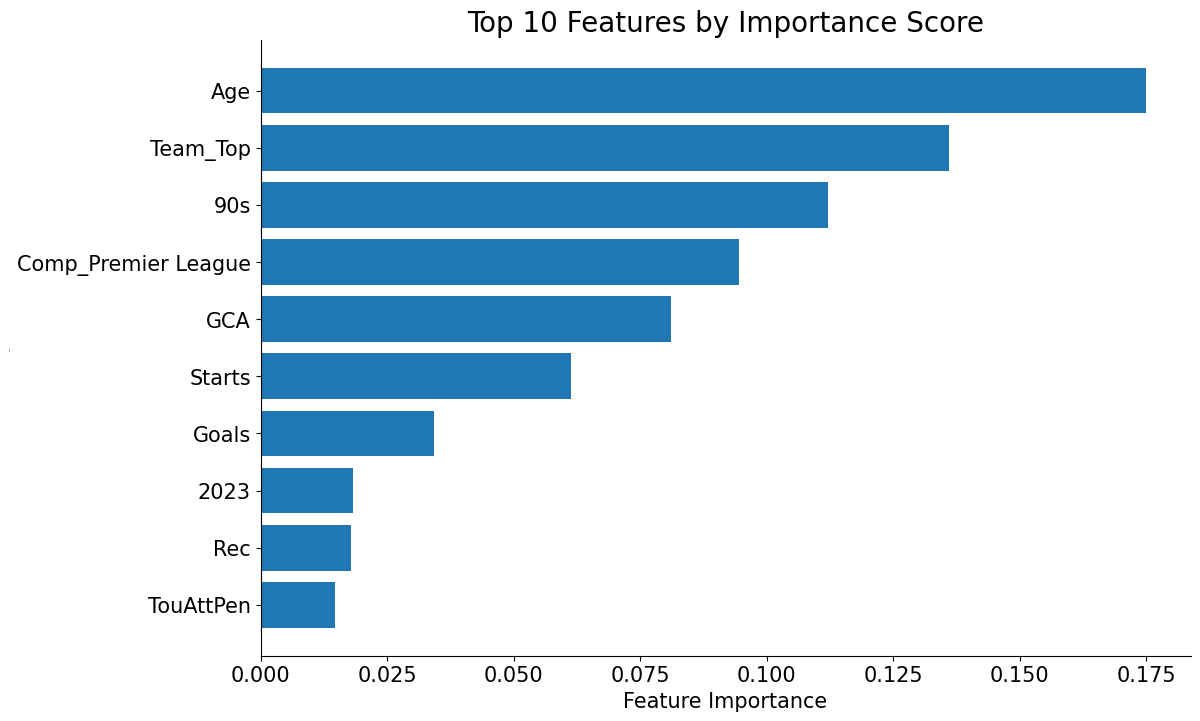

In [683]:
feature_importance = booster_model.feature_importances_

# Creating a DataFrame to display feature importance along with their corresponding names
importance_df = pd.DataFrame({'Feature': X_train_scaled.columns, 'Importance': feature_importance})
top_features = importance_df.nlargest(10, 'Importance').sort_values(by='Importance')

# Plotting feature importance
plt.figure(figsize=(12, 8))
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance', fontsize=15)
plt.ylabel('Feature', fontsize=0)
plt.title('Top 10 Features by Importance Score', fontsize=20)
sns.despine()

plt.show()


In [416]:
importance_df.head(30)

,Feature,Importance
20,Age,0.175031
15,Team_Top,0.135975
23,90s,0.112230
12,Comp_Premier League,0.094561
74,GCA,0.081146
22,Starts,0.061324
24,Goals,0.034243
127,2023,0.018287
112,Rec,0.017821
102,TouAttPen,0.014623


**Insights**

- Outside of the top 6 features, the rest of the features have very low importance when it comes to valuation.
- The features with most importance is 'Age', 'Team_Top', and '90's. This is not surprising as this is quite intuitive within sports. Players that are within a certain age are usually much more valuable than older players. From our earlier EDA, we saw that players that played in top teams have a generally higher valuation. Players that play more minutes naturally should be valued higher.
- The 4th most important feature is if the player plays in the Premier League. This may truly confirm the premier league tax that so many people speculate.

We can also take a look at the shaply values for this model.

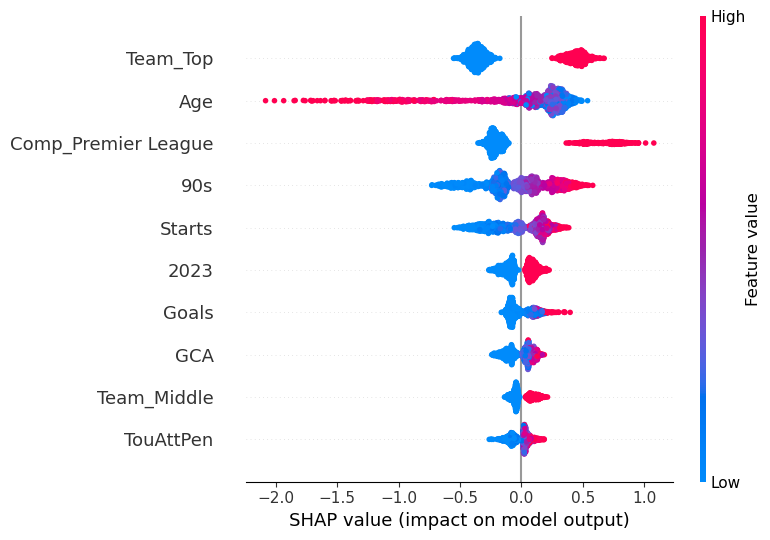

In [444]:
# Create an explainer object using the model and the training data
explainer = shap.Explainer(booster_model, X_train_scaled)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_scaled)

# Create a summary plot
shap.summary_plot(shap_values, X_test_scaled, plot_type='dot', show=False, max_display = 10)


**Insights** 

- This graph shows a lot of interesting information. Looking at the most important feature determined by Shap, 'Team_Top' shows how being part of the top 8 teams positively increases the valuation.
- The age importance is much more nuanced: it seems some players have their valuation decreased massively due to their age. From intuition, this is like to be older players. Then, there is some players that their valuation is quite heavily improved due to their age but also some that has a small increase in valuation due to their age. 
- Players in the premier league has a significant gain in valuation, some by a much larger amount.

Now, we can check the gradient boosting model with RFE implemented.

<Figure size 800x800 with 0 Axes>

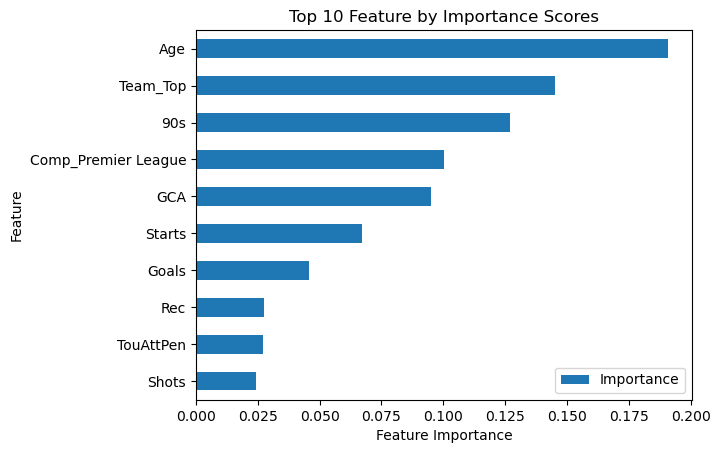

In [436]:
# Find importance scores
feature_importance = final_booster_model.feature_importances_

# Creating a DataFrame to display feature importance along with their corresponding names
importance_df = pd.DataFrame({'Feature': best_selected_features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize = (8,8))
importance_df.sort_values(by = 'Importance', ascending = False).head(10).sort_values(by = 'Importance', ascending = True).plot(kind = 'barh', x = 'Feature', y = 'Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature by Importance Scores')

plt.show()


In [437]:
importance_df.sort_values(by = 'Importance', ascending = False).head(10)

,Feature,Importance
3,Age,0.190919
2,Team_Top,0.145193
5,90s,0.126970
0,Comp_Premier League,0.100252
12,GCA,0.094924
4,Starts,0.067179
6,Goals,0.045680
16,Rec,0.027452
14,TouAttPen,0.027159
7,Shots,0.024474


**Insights**

- The features are quite similar to the earlier booster, but with higher scores.
- Generally, the features all all offensive statistics.

Lastly, we can take a quick look at the shap values.

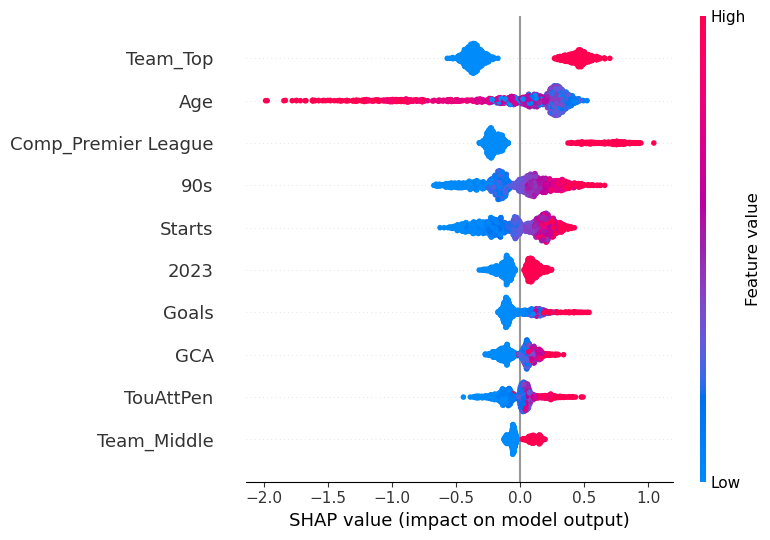

In [783]:
# Create an explainer object using the model and the training data
explainer = shap.Explainer(final_booster_model, X_train_selected)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_selected)

# Create a summary plot
shap.summary_plot(shap_values, X_test_selected, plot_type='dot', show=False, max_display = 10)


There is very little difference between this visualization and the one for the earlier model.

For some further analysis, we can look at some individual players.

## 9.3 Player Examples

Let's find a few players to investigate our model with.

In [463]:
# Let's find Canadian player Alphonso Davies & ensure it is in test set
df1[df1.index.isin(X_test_scaled.index) & (df1['Name'] == 'Alphonso Davies')]

,Name,Height,Valuation,Nation,Pos,Squad,Comp,Age,Born,MP,...,Off,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%,2023,Team
540,Alphonso Davies,183.0,70000000.0,CAN,DF,Bayern Munich,Bundesliga,22.0,2000,17,...,0.13,0.0,0.0,0.0,8.77,0.19,0.26,42.9,1,Top


Let's look at the shap values (feature importance) for Alphonso Davies, a Canadian footballer who plays for Bayern Munich. First, we look at our original model.

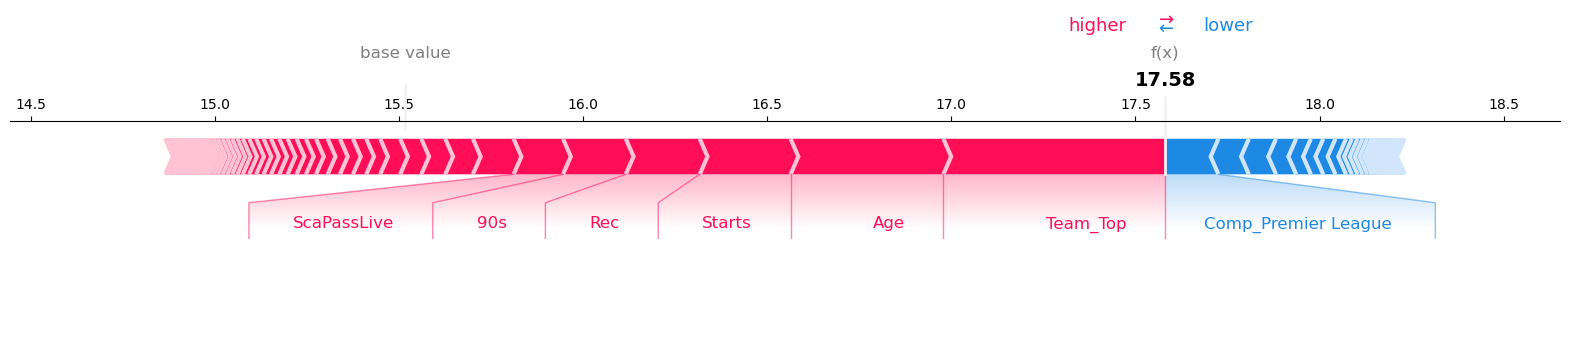

In [569]:
# Create an explainer object using the model and the training data
explainer = shap.Explainer(booster_model, X_train_scaled)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_scaled)
shap_values_df = pd.DataFrame(shap_values, columns=X_test_scaled.columns)
shap_values_df.index = X_test_scaled.index

# Set index for player to look at
index = 540

# Set shap value for required player
shap_values_alphonso = shap_values_df.loc[index].values.reshape(1,-1)


shap.initjs()
force_plot = shap.force_plot(explainer.expected_value, shap_values_alphonso, X_train_scaled.columns, matplotlib = True)



In [579]:
# Check the explainer expected value - this is the baseline value if no features are present
explainer.expected_value

15.515561642392946

In [580]:
# Check to see if the function is correctly calculated
explainer.expected_value + np.sum(shap_values_alphonso)

17.580187306802195

In [575]:
# Find predicted value for Davies through Shap
np.exp(np.sum(shap_values_alphonso) + explainer.expected_value)

43149755.39665436

**Insights**

- This above diagram shows how the valuation for Alphonso Davies specifically is derived. The red parts show which features improved the valuation. The larger the arrow, the larger the effect. Conversely, the blue arrows show the features that reduced the valuation, with the largest factor being that he is not in the Premier League.
- Greatest postive factors are 'Team_Top','Age', and 'Starts'. This makes a lot of sense from a footballing standpoint.

Let's take a quick look at what our boosting algorithm predicted for Alphonso Davies.

In [690]:
X_test_scaled[X_test_scaled.index == specific_index]

,Pos_DFFW,Pos_DFMF,Pos_FW,Pos_FWDF,Pos_FWMF,Pos_GK,Pos_GKMF,Pos_MF,Pos_MFDF,Pos_MFFW,...,Fld,Off,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%,2023
540,-0.117099,-0.175878,-0.415658,-0.105789,-0.326643,-0.276615,0.0,-0.517544,-0.154672,-0.28929,...,0.066914,-0.131748,-0.075218,-0.20218,-0.154938,0.715468,-0.765345,-0.689789,0.029675,1.067181


In [691]:
# Select specific index
specific_index = 540

# Extract the specific row from X_test_scaled
specific_data = X_test_scaled[X_test_scaled.index == specific_index]

# Use the booster_model to predict for the specific row
predicted_value_specific_index = booster_model.predict(specific_data)

# Inverse log transform if needed
predicted_value_specific_index_original_scale = np.exp(predicted_value_specific_index)

# Print the predicted value for the specific index
print("Predicted value for index {}: {}".format(specific_index, predicted_value_specific_index_original_scale))


Predicted value for index 540: [43149754.93708012]


**Insights**

- We are quite far from the valuation for Alphonso Davies.
- The boosting algorithm and shap produced nearly identical values.
- Note our model underpredicts majority of high valued players.

In [584]:
# Find another player
df1[df1.index.isin(X_test_scaled.index) & (df1['Squad'] == 'Manchester Utd')]

,Name,Height,Valuation,Nation,Pos,Squad,Comp,Age,Born,MP,...,Off,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%,2023,Team
800,Fred,169.0,20000000.0,BRA,MF,Manchester Utd,Premier League,29.0,1993,19,...,0.00,0.00,0.00,0.0,8.71,0.71,0.94,42.9,1,Top
845,David de Gea,189.0,13000000.0,ESP,GK,Manchester Utd,Premier League,32.0,1990,22,...,0.00,0.00,0.00,0.0,0.73,0.14,0.00,100.0,1,Top
1289,Victor Lindelof,187.0,18000000.0,SWE,DF,Manchester Utd,Premier League,28.0,1994,8,...,0.00,0.00,0.00,0.0,5.20,2.40,1.00,70.6,1,Top
1462,Scott McTominay,191.0,25000000.0,SCO,MF,Manchester Utd,Premier League,26.0,1996,15,...,0.00,0.00,0.12,0.0,5.95,2.38,1.67,58.8,1,Top
1835,Marcus Rashford,185.0,80000000.0,ENG,FW,Manchester Utd,Premier League,25.0,1997,22,...,0.45,0.00,0.00,0.0,2.96,0.85,1.51,36.2,1,Top
1968,Jadon Sancho,180.0,45000000.0,ENG,FW,Manchester Utd,Premier League,22.0,2000,11,...,0.36,0.00,0.00,0.0,4.70,0.24,0.96,20.0,1,Top
2030,Luke Shaw,178.0,42000000.0,ENG,DF,Manchester Utd,Premier League,27.0,1995,18,...,0.00,0.00,0.00,0.0,6.83,1.44,1.08,57.1,1,Top
2333,Aaron Wan-Bissaka,183.0,25000000.0,ENG,DF,Manchester Utd,Premier League,25.0,1997,8,...,0.00,0.00,0.00,0.0,5.15,0.74,1.03,41.7,1,Top
2341,Wout Weghorst,197.0,12000000.0,NED,FW,Manchester Utd,Premier League,30.0,1992,4,...,0.67,0.00,0.00,0.0,4.00,1.33,2.67,33.3,1,Top
3434,Alejandro Garnacho,180.0,3000000.0,ESP,FW,Manchester Utd,Premier League,17.0,2004,2,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0,Top


Let's take a look at one of my favorite players 'Luke Shaw' and the model shap values.

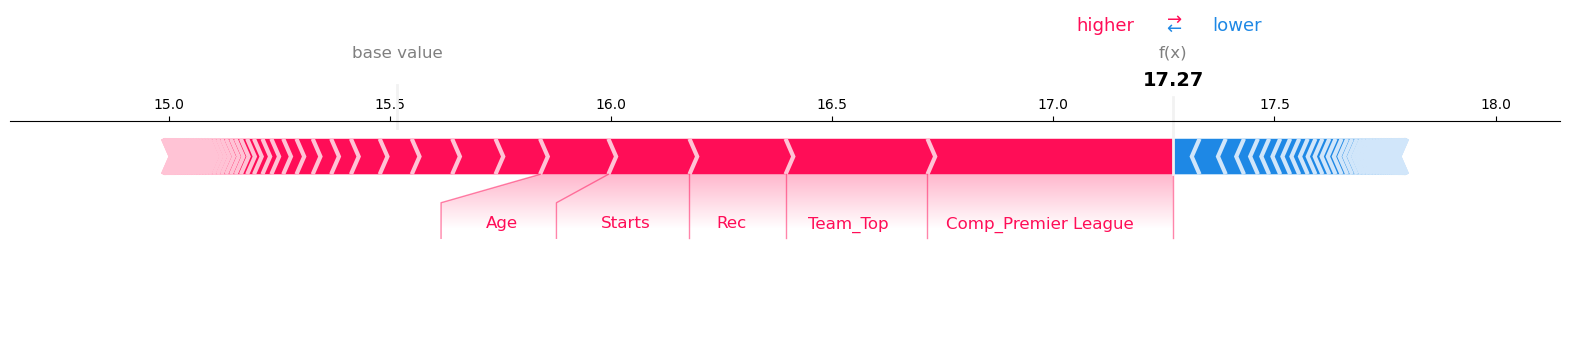

In [764]:
# Create an explainer object using the model and the training data
explainer = shap.Explainer(booster_model, X_train_scaled)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_scaled)
shap_values_df = pd.DataFrame(shap_values, columns=X_test_scaled.columns)
shap_values_df.index = X_test_scaled.index

# Set index for player to look at
index = 2030

# Set shap value for required player
shap_values_shaw = shap_values_df.loc[index].values.reshape(1,-1)

# Plot shap plot
shap.initjs()
force_plot = shap.force_plot(explainer.expected_value, shap_values_shaw, X_train_scaled.columns, matplotlib = True)

In [587]:
# Find predicted value for Shaw through Shap
np.exp(np.sum(shap_values_shaw) + explainer.expected_value)

31660413.136937786

Let's see what our booster algorithm predicted.

In [693]:
# Select specific index
specific_index = 2030

# Extract the specific row from X_test_scaled
specific_data = X_test_scaled[X_test_scaled.index == specific_index]

# Use the booster_model to predict for the specific row
predicted_value_specific_index = booster_model.predict(specific_data)

# Inverse log transform if needed
predicted_value_specific_index_original_scale = np.exp(predicted_value_specific_index)

# Print the predicted value for the specific index
print("Predicted value for index {}: {}".format(specific_index, predicted_value_specific_index_original_scale))


Predicted value for index 2030: [31660411.90484097]


In [694]:
# Look for Shaw valuation
df1[df1.index == 2030][['Name','Valuation']]

,Name,Valuation
2030,Luke Shaw,42000000.0


**Insights**

- In this case, the valuation between the booster model and shap values were almost identical.
- Both values underpredicted by quite a large margin.
- Playing in the Premier League, and for a top team increased valuation greatly.

Lastly, let's try and use the RFE booster version and look at Davies shap visualization.

In [773]:
# Initiate repeat model
# Save scaler model with less features
X_train_select = X_train[best_selected_features]
X_test_select = X_test[best_selected_features]

# Fit scaler
final_scaler = StandardScaler()
final_scaler.fit(X_train_select)

# Transform train and test using the selected features
X_train_final = final_scaler.transform(X_train_select)
X_test_final = final_scaler.transform(X_test_select)

# Set previous terms
X_train_selected = X_train_final
X_test_selected = X_test_final

# Convert scaled arrays back to DataFrames with column names
X_train_selected = pd.DataFrame(X_train_final, columns=best_selected_features, index = X_train.index)
X_test_selected = pd.DataFrame(X_test_final, columns=best_selected_features, index = X_test.index)

# Set our new training and test with reduced features (Original code)
# X_train_selected = X_train_scaled[best_selected_features]
# X_test_selected = X_test_scaled[best_selected_features]

# Fit final booster model
final_booster_model = booster.fit(X_train_selected, y_train)

# Create predicted values for training and test data
predictions_train = final_booster_model.predict(X_train_selected)
predictions_test = final_booster_model.predict(X_test_selected)

# Store train and test r squared values
train_R_squared = final_booster_model.score(X_train_selected, y_train)
test_R_squared = final_booster_model.score(X_test_selected, y_test)

# Store adjusted test r squared values
n_test = len(y_test)
k_test = X_test_selected.shape[1]
adjusted_r_squared_test = 1 - ((1 - test_R_squared) * (n_test - 1) / (n_test - k_test - 1))

# Inverse log transform on predictions
predictions_train_original_scale = np.exp(predictions_train)
predictions_test_original_scale = np.exp(predictions_test)

# Calculate MAE on original scale
train_mae_original_scale = np.mean(abs(np.exp(y_train) - predictions_train_original_scale))
test_mae_original_scale = np.mean(abs(np.exp(y_test) - predictions_test_original_scale))

# Calculate PMAE on original scale
train_pmae_original_scale = np.mean(abs((np.exp(y_train) - predictions_train_original_scale) / np.exp(y_train))) * 100
test_pmae_original_scale = np.mean(abs((np.exp(y_test) - predictions_test_original_scale) / np.exp(y_test))) * 100

# Print statements
print(train_R_squared)
print(test_R_squared)
print(train_mae_original_scale)
print(test_mae_original_scale)
print(train_pmae_original_scale)
print(test_pmae_original_scale)

0.8210159346425178
0.70226610645088
3714943.7570222644
4557021.238208391
53.74958532335664
74.26413633665373


In [778]:
# Save my explainer to use in streamlit
explainer = shap.Explainer(final_booster_model, X_train_selected)

joblib.dump(explainer,'shap_explainer.pkl')

['shap_explainer.pkl']

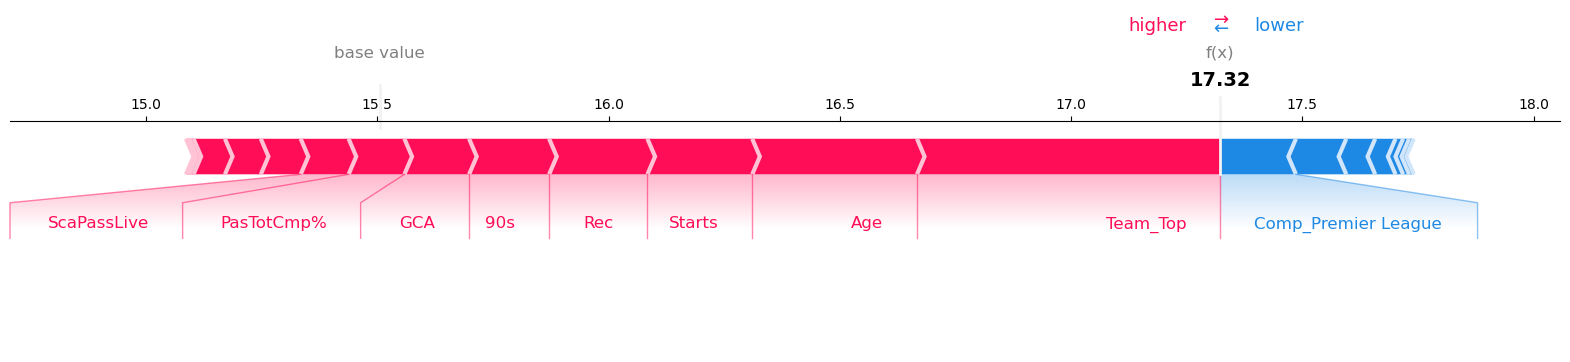

In [774]:
# Create an explainer object using the model and the training data
explainer = shap.Explainer(final_booster_model, X_train_selected)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_selected)
shap_values_df = pd.DataFrame(shap_values, columns=X_test_selected.columns)
shap_values_df.index = X_test_selected.index

# Set index for player to look at
index = 540

# Set shap value for required player
shap_values_alphonso = shap_values_df.loc[index].values.reshape(1,-1)

# Plot shap plot
shap.initjs()
force_plot = shap.force_plot(explainer.expected_value, shap_values_alphonso, X_train_selected.columns, matplotlib = True)



In [775]:
# Check explainer expected value for RFE booster model
explainer.expected_value

15.504897509976972

In [776]:
# Find predicted value for Davies through Shap
np.exp(np.sum(shap_values_alphonso) + explainer.expected_value)

33334641.48658989

Once again, we can look at the RFE booster prediction.

In [695]:
# Select specific index
specific_index = 540

# Extract the specific row from X_test_scaled
specific_data = X_test_selected[X_test_selected.index == specific_index]

# Use the booster_model to predict for the specific row
predicted_value_specific_index = final_booster_model.predict(specific_data)

# Inverse log transform if needed
predicted_value_specific_index_original_scale = np.exp(predicted_value_specific_index)

# Print the predicted value for the specific index
print("Predicted value for index {}: {}".format(specific_index, predicted_value_specific_index_original_scale))


Predicted value for index 540: [33334641.28607681]


**Insights**

- This shap value takes in much less features - in turn, the remaining features are more important.
- Our model severely underestimated the valuation of Alphonso Davies. This is interesting as to why that may be the case. Perhaps the player statistics estimate Davies to be worth this new valuation, but other factors push his valuation to much higher. His marketability, contract length, wages can all be significant factors that lead to a higher valuation.

<a id="CONCLUSION"></a>
# 10. Conclusion

**Project Overview**

This project has started with a goal of predicting valuation through player statistics. We have used four datasets to get started. Two of them are player statistics datasets for football players in the top 5 leagues for the last two years respectively. We have one dataset that shows the valuation of footballers over the last 20 years with a player id, and another dataset with the player id and their respective name.

After preprocessing, we reached a final dataframe which had both of our player statistics dataframe stacked vertically, that has been succesfully merged with our valuation dataframe by player name. Simply speaking, we have a dataframe where each row is a player with their respective season stats and valuation.

From here, we proceeded to model. With this being a regression problem, we set our evaluation metrics as R squared, mean absolute error and percentage mean absolute error. After all testing, we found the bagging regressor algorithm to have the best results in all three metrics and it fared best when comparing the predicted values of the model to the actual values. 

We proceeded to perform Recursive Feature Engineering (RFE) to simplify the model, which reduced the feature set to the 20 most important features. The accuracy has suffered slightly, but not significantly. 

Lastly, we looked at shap values which showed the most important features in determining valuation. This included 'Age', 'Top_Teams', '90s' and 'Comp_Premier_League', all of which makes a lot of sense. We then looked at a few specific players and looked at how they were valued. There are some visualizations which show the importance of said features for Alphonso Davies and Luke Shaw.

**Ethical Considerations**

It is important to consider the ethical impications of this model. In the end, we are putting a value on a player - a human life - which can bear unintended consequences. Exploitation of footballers have been an ongoing issue, especially in underdeveloped nations, and a football valuation tool may aid these causes. It is very important to keep this tool under stricter supervision with regards to who may have access to it.



**Future steps**

In the future, it could be beneficial to compare our models to transfer fees that occured in the last two years.

We could also find more ways of improving the model. Additional hyperparameter tuning, especially for neural networks, may yield better results. 

Collecting additional data may also prove invaluable to the model. Our most important features had many categorical features that were not player statistcs, but profile attributes, such as playing in a top 8 team, playing for a premier league team etc. Information regarding marketing potential, contract length, wages may help this model further.

**Dashboard**

A temporary solution has been created to showcase the model. However, further development into applications can prove useful. This can be used by football clubs: transfer specialists as well as scouts may find this application extremely useful for their work.

# Appendix

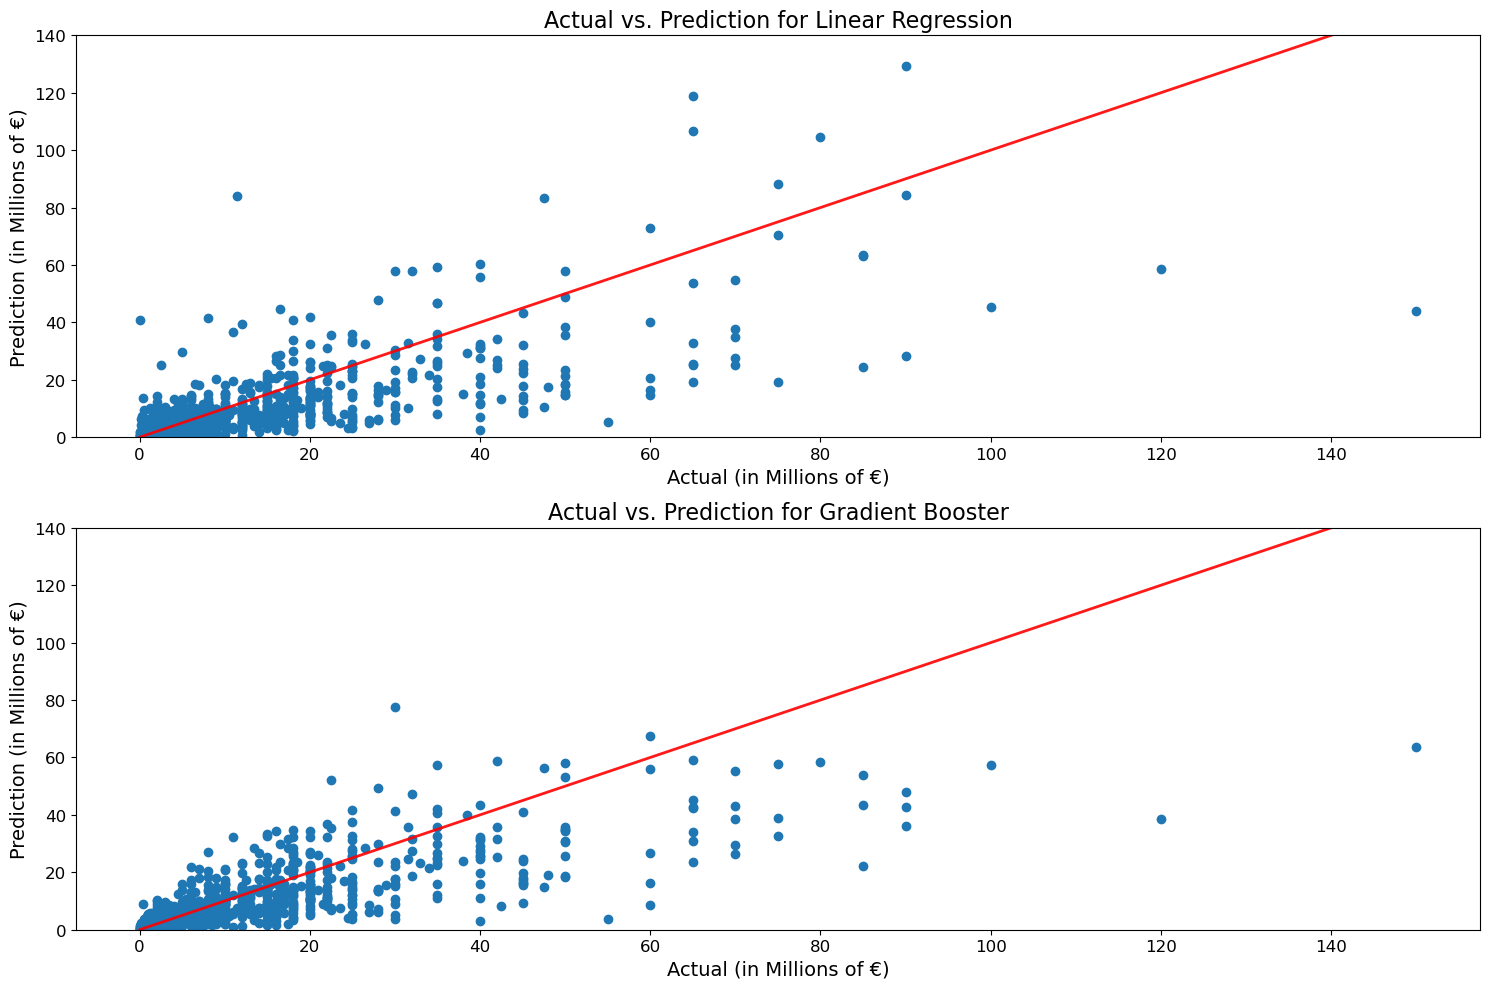

In [662]:
# For plotting purposes

models_name = ['Linear Regression', 'Linear Regression 2', 'Linear Regression 3', 'Lasso', 'Ridge',
               'Decision Tree', 'Random Forest', 'Neural Network', 'Bagging', 'Gradient Booster']

# Create a figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 10))  # 2 rows, 1 column

# Plot the first model (Linear Regression)
axes[0].scatter(x=np.exp(y_test) / 1_000_000, y=np.exp(prediction_df.iloc[:, 0]) / 1_000_000)
axes[0].set_title(f'Actual vs. Prediction for {models_name[0]}', fontsize=16)  # Set title font size
axes[0].set_xlabel("Actual (in Millions of €)", fontsize=14)  # Set x-axis label font size
axes[0].set_ylabel("Prediction (in Millions of €)", fontsize=14)  # Set y-axis label font size
axes[0].tick_params(axis='both', which='major', labelsize=12)  # Set tick label font size
axes[0].set_ylim(0, 140)
xp = np.linspace(np.exp(y_test.min()) / 1_000_000, np.exp(y_test.max()) / 1_000_000, 100)
axes[0].plot(xp, xp, alpha=0.9, linewidth=2, color='red')

# Plot the last model (Gradient Booster)
axes[1].scatter(x=np.exp(y_test) / 1_000_000, y=np.exp(prediction_df.iloc[:, -1]) / 1_000_000)
axes[1].set_title(f'Actual vs. Prediction for {models_name[-1]}', fontsize=16)  # Set title font size
axes[1].set_xlabel("Actual (in Millions of €)", fontsize=14)  # Set x-axis label font size
axes[1].set_ylabel("Prediction (in Millions of €)", fontsize=14)  # Set y-axis label font size
axes[1].tick_params(axis='both', which='major', labelsize=12)  # Set tick label font size
axes[1].set_ylim(0, 140)
xp = np.linspace(np.exp(y_test.min()) / 1_000_000, np.exp(y_test.max()) / 1_000_000, 100)
axes[1].plot(xp, xp, alpha=0.9, linewidth=2, color='red')

# Adjust subplot layout for better spacing
plt.tight_layout()

plt.show()


In [ ]:
# Plot the last model (Gradient Booster)
plt.figure(figsize=(12, 6))
actual = np.exp(y_test.values) / 1_000_000
predicted = np.exp(prediction_df.iloc[:, -1].values) / 1_000_000

# Scatter plot with different colors for overvalued and undervalued points
scatter = plt.scatter(x=actual, y=predicted, c=['green' if p < a else 'blue' for a, p in zip(actual, predicted)])
plt.title(f'Actual Valuation vs. Predicted Valuation', fontsize=16)
plt.xlabel("Actual Valuation (in Millions of €)", fontsize=14)
plt.ylabel("Predicted Valuation (in Millions of €)", fontsize=14)
plt.ylim(0, 140)
xp = np.linspace(actual.min(), actual.max(), len(actual))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Plot the red line for perfect valuation and add it to the legend
perfect_valuation, = plt.plot(xp, xp, alpha=0.9, linewidth=2, color='red')
undervalued_patch = mpatches.Patch(color='green', label='Undervalued')
overvalued_patch = mpatches.Patch(color='blue', label='Overvalued')
plt.legend(handles=[undervalued_patch, overvalued_patch, perfect_valuation], 
           labels=['Undervalued', 'Overvalued', 'Perfect Valuation'], loc='upper left', fontsize = 15)

# Adjust subplot layout for better spacing
plt.tight_layout()

plt.show()
